<a href="https://colab.research.google.com/github/bmcs-ux/YouTube/blob/main/VARX_REGRESION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fredapi
!pip install arch

In [2]:
# cell_id: ueDnerbGuoPP
#@title Granger Causality and Signal Generation
# forex_multitf_granger.py
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
from scipy.signal import argrelextrema
import warnings
from fredapi import Fred
warnings.filterwarnings("ignore")

In [3]:
# cell_id: uhNywmy65k_k
# ============================================================
# ⚙️ Persiapan Dasar
# ============================================================


import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

plt.style.use("seaborn-v0_8-darkgrid")

In [4]:
# cell_id: JGemPprTvBcw
# --------------------------------
# PARAMETERS (ubah sesuai kebutuhan)
# --------------------------------
PAIRS = {
    #"EUR/USD": "EURUSD=X",
    #"GBP/USD": "GBPUSD=X",
    "USD/CHF": "USDCHF=X",
    "USD/JPY": "JPY=X",
    "AUD/USD": "AUDUSD=X",
    "XAU/USD": "GC=F",
    "BTC/USD": "BTC-USD",
}

# Data window & base interval to download
lookback_days = 200           # rentang data historis (hari)
base_interval = "1d"         # ambil data base: '1m','2m','5m','15m','30m','60m','90m' (sesuaikan)
# Timeframes we will analyse (mapping ke faktor resample)
TF_MAP = {
    "M1": "1min",
    "M5": "5min",
    "M15": "15min",
    "H1": "60min",
    "H4": "240min"   # will be created by resampling the base data
}
# Note: yfinance intervals use strings like '1m','5m','15m','60m'. We will resample using pandas offsets.

# Granger params
maxlag_test = 12             # max lag (jumlah observation lag) untuk uji Granger
alpha = 0.05                 # signifikansi Granger
min_obs_for_granger = 50     # minimal observasi supaya Granger bermakna

# Prediction params
accum_window = 18             # untuk rolling sum of log returns (dalam unit base interval)
min_events_for_effective_time = 3   # minimal jumlah kejadian agar rata2 waktu efektif bisa dihitung

# Technical params
ma_short = 10
ma_long = 30
slope_window = 5

# Support/Resistance detection
sr_local_window = 12          # window untuk mencari local extrema (nilai ini dalam bars pada timeframe tsb)
pivot_lookback = 30          # untuk menghitung pivot points (high/low/close over last N bars)

# P&L / order params
RR = 2.0                    # TakeProfit : StopLoss ratio

# Output files
OUTPUT_CSV = "granger_forecasts_multitf.csv"

In [5]:
# cell_id: HYcYVva61v1i
#id series_parameter
FRED_SERIES = {
    "Secured Overnight Financing Rate": "SOFR",     # CPI AS (index, bisa dipakai hitung inflasi YoY)
    "S&P 500": "SP500",    # Federal Funds Rate
    "Currency Conversions: US Dollar Exchange Rate": "CYPCCUSMA02STQ",              # 10-year Treasury yield
    "US Corporate Index Semi-Annual Yi": "BAMLC0A4CBBBSYTW",
    "Index Semi-Annual" :  "BAMLH0A0HYM2SYTW",
    "Emerging Markets Corporate": "BAMLEM5BCOCRPISYTW",
    "Markets Corporate Plus" : "BAMLEMRECRPIEMEASYTW",
    "Financial US Emerging Markets Liquiq" : "BAMLEMFLFLCRPIUSSYTW",
    "Daily Sterling Overnight Index Average (SONIA)...": "IUDSOIA",
}

FRED_API_KEY = "987d18495a386165f0be970f8a733562"

In [6]:
# cell_id: TMxoZtryorwm
#id_series_search
from fredapi import Fred
# Inisialisasi objek Fred
fred = Fred(api_key=FRED_API_KEY)

fred.search('Daily').T

series id                                                             T10Y2Y  \
id                                                                    T10Y2Y   
realtime_start                                           2025-10-23 00:00:00   
realtime_end                                             2025-10-23 00:00:00   
title                      10-Year Treasury Constant Maturity Minus 2-Yea...   
observation_start                                        1976-06-01 00:00:00   
observation_end                                          2025-10-22 00:00:00   
frequency                                                              Daily   
frequency_short                                                            D   
units                                                                Percent   
units_short                                                                %   
seasonal_adjustment                                  Not Seasonally Adjusted   
seasonal_adjustment_short                                                NSA   
last_updated                                       2025-10-22 16:37:45-05:00   
popularity                                                               100   
notes                      Starting with the update on June 21, 2019, the...   

series id                                                                DFF  \
id                                                                       DFF   
realtime_start                                           2025-10-23 00:00:00   
realtime_end                                             2025-10-23 00:00:00   
title                                           Federal Funds Effective Rate   
observation_start                                        1954-07-01 00:00:00   
observation_end                                          2025-10-21 00:00:00   
frequency                                                       Daily, 7-Day   
frequency_short                                                            D   
units                                                                Percent   
units_short                                                                %   
seasonal_adjustment                                  Not Seasonally Adjusted   
seasonal_adjustment_short                                                NSA   
last_updated                                       2025-10-22 15:16:40-05:00   
popularity                                                                88   
notes                       Daily Federal Funds Rate from 1928-1954 (http...   

series id                                                       BAMLH0A0HYM2  \
id                                                              BAMLH0A0HYM2   
realtime_start                                           2025-10-23 00:00:00   
realtime_end                                             2025-10-23 00:00:00   
title                      ICE BofA US High Yield Index Option-Adjusted S...   
observation_start                                        1996-12-31 00:00:00   
observation_end                                          2025-10-22 00:00:00   
frequency                                                       Daily, Close   
frequency_short                                                            D   
units                                                                Percent   
units_short                                                                %   
seasonal_adjustment                                  Not Seasonally Adjusted   
seasonal_adjustment_short                                                NSA   
last_updated                                       2025-10-23 09:16:51-05:00   
popularity                                                                99   
notes                      The ICE BofA Option-Adjusted Spreads (OASs) ar...   

series id                                                          RIFSPFFNB  \
id                                                                 RIFSPFFNB 

In [7]:
# cell_id: r2H7WBnEvX_V

#(pandas_freq_from_tf)
def pandas_freq_from_tf(tf):
    """Return a pandas offset alias for given TF key."""
    if tf.endswith("min") or tf.endswith("min"):
        return tf
    mapping = {
        "1min": "1min",
        "5min": "5min",
        "15min": "15min",
        "60min": "60min",
        "240min": "240min"
    }
    return mapping.get(tf, tf)

In [8]:
# cell_id: uxhukrSSvjjM

#(resample_to_tf)
def resample_to_tf(df, target_minutes):
    """Resample base-minute DataFrame (index DatetimeIndex) to timeframe target_minutes (int)."""
    rule = f"{target_minutes}T"
    o = df.resample(rule).agg({"Open":"first","High":"max","Low":"min","Close":"last","Volume":"sum"})
    o.dropna(how="any", inplace=True)
    return o

In [9]:
# cell_id: IJHTxLbZv4SY

#(compute_pivot_levels)
def compute_pivot_levels(series_high, series_low, series_close):
    high = float(series_high.max())
    low = float(series_low.min())
    close = float(series_close.iloc[-1])
    PP = (high + low + close) / 3.0
    R1 = (2 * PP) - low
    S1 = (2 * PP) - high
    R2 = PP + (high - low)
    S2 = PP - (high - low)
    return {"PP":PP,"R1":R1,"S1":S1,"R2":R2,"S2":S2, "High":high, "Low":low, "Close":close}

In [10]:
# cell_id: tJ2ShOZzwON2

#(find_best_granger_lag)
def find_local_sr_levels(price_series, order=3):
    """Return arrays of local support (min) and resistance (max) levels (values)."""
    arr = price_series.values
    if len(arr) < order * 2 + 1:
        return [], []
    # local maxima
    local_max_idx = argrelextrema(arr, np.greater, order=order)[0]
    local_min_idx = argrelextrema(arr, np.less, order=order)[0]
    resistances = list(price_series.iloc[local_max_idx].round(6))
    supports = list(price_series.iloc[local_min_idx].round(6))
    return supports, resistances

In [11]:
# cell_id: cniOsa45wrBI

#(linear_slope)
def linear_slope(arr):
    """Return slope of linear regression for 1D array (last axis as y)."""
    if len(arr) < 2:
        return 0.0
    X = np.arange(len(arr)).reshape(-1,1)
    y = np.array(arr).reshape(-1,1)
    m = LinearRegression().fit(X,y).coef_[0][0]
    return float(m)

1. **Unduh data FRED melalui API**

   * Gunakan `fredapi` dengan daftar ID terstruktur.
   * Ambil metadata rilis (release date, frequency).

2. **Sinkronisasi tanggal rilis (release-based alignment)**

   * Alih-alih forward-fill, buat kolom `release_date` dan `effective_until_next_release`.
   * Merge ke harga berdasarkan tanggal rilis yang *sudah diketahui pasar*.

In [12]:

# cell_id: Q1YkA5Nh1N3z
# ============================================================
# 📦 FRED DATA DOWNLOAD (Final Robust Version) + Date Range Filter
# ============================================================


end_date = datetime.now()
start_date = end_date - timedelta(days=lookback_days)

print(f"📅 Mengambil data dari {start_date.date()} hingga {end_date.date()}")

fred = Fred(api_key=FRED_API_KEY)
fred_data = []
fred_metadata = []

for name, series_id in FRED_SERIES.items():
    try:
        # 1️⃣ Ambil metadata
        info = fred.get_series_info(series_id)
        meta = {
            "series_name": name,
            "series_id": series_id,
            "title": getattr(info, "title", None),
            "frequency": getattr(info, "frequency", None),
            "units": getattr(info, "units", None),
            "seasonal_adjustment": getattr(info, "seasonal_adjustment", None),
            "last_updated": getattr(info, "last_updated", None),
            "notes": getattr(info, "notes", None),
        }
        fred_metadata.append(meta)

        # 2️⃣ Ambil data (utamakan realtime, fallback ke simple)
        try:
            df = fred.get_series_all_releases(series_id)
            mode = "all_releases"
        except Exception as e:
            print(f"⚠️ Fallback {name} ({series_id}) ke simple mode: {e}")
            df = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
            mode = "simple_series"

        if df is None or len(df) == 0:
            print(f"⚠️ Tidak ada data untuk {name} ({series_id})")
            continue

        # 3️⃣ Normalisasi format DataFrame
        if isinstance(df, pd.Series):
            # Simple mode
            df = df.to_frame(name='value')
            df['release_date'] = pd.to_datetime(df.index)
            df['effective_until_next_release'] = pd.NaT
            df['date'] = df['release_date']
        else:
            # Realtime mode
            if 'realtime_start' not in df.columns:
                df['release_date'] = pd.to_datetime(df['date'], errors='coerce')
            else:
                df['release_date'] = pd.to_datetime(df['realtime_start'], errors='coerce')

            if 'realtime_end' in df.columns:
                df['effective_until_next_release'] = pd.to_datetime(df['realtime_end'], errors='coerce')
            else:
                df = df.sort_values('release_date')
                df['effective_until_next_release'] = df['release_date'].shift(-1)

            if 'date' not in df.columns:
                df['date'] = df['release_date']

            if 'value' not in df.columns:
                df.rename(columns={df.columns[-1]: 'value'}, inplace=True)

        # 4️⃣ Konversi tipe dan bersihkan
        for col in ['release_date', 'effective_until_next_release', 'date']:
            df[col] = pd.to_datetime(df[col], errors='coerce').dt.tz_localize("UTC", nonexistent='shift_forward', ambiguous='NaT')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')

        # 5️⃣ Filter berdasarkan rentang waktu
        df = df[(df['release_date'] >= pd.Timestamp(start_date, tz='UTC')) &
                (df['release_date'] <= pd.Timestamp(end_date, tz='UTC'))]

        df = df.dropna(subset=['value']).sort_values(['release_date'])
        df = df.drop_duplicates(subset=['release_date'], keep='last')
        df = df.rename(columns={'value': name})

        fred_data.append(df[['release_date', 'effective_until_next_release', 'date', name]])
        print(f"✅ {name}: {len(df)} observasi ({mode}), freq={meta['frequency']}")

    except Exception as e:
        print(f"⚠️ Gagal ambil {name} ({series_id}): {e}")

📅 Mengambil data dari 2025-04-06 hingga 2025-10-23
✅ Secured Overnight Financing Rate: 138 observasi (all_releases), freq=Daily
⚠️ Fallback S&P 500 (SP500) ke simple mode: Bad Request.  The series does not exist in ALFRED but may exist in FRED.  Try setting realtime_start and realtime_end to today's date or removing the realtime_start and realtime_end variables.
✅ S&P 500: 138 observasi (simple_series), freq=Daily, Close
✅ Currency Conversions: US Dollar Exchange Rate: 0 observasi (all_releases), freq=Quarterly
⚠️ Fallback US Corporate Index Semi-Annual Yi (BAMLC0A4CBBBSYTW) ke simple mode: Bad Request.  There are 3007 vintage dates in the specified real-time period: 1776-07-04 to 9999-12-31.  This exceeds the maximum number of vintage dates allowed for this file type (2000).
✅ US Corporate Index Semi-Annual Yi: 144 observasi (simple_series), freq=Daily, Close
⚠️ Fallback Index Semi-Annual (BAMLH0A0HYM2SYTW) ke simple mode: Bad Request.  There are 3008 vintage dates in the specified re

In [13]:
# cell_id: display_fred_data_variable
# ============================================================
# 📊 Tampilkan Variabel fred_data Setelah Pengunduhan
# ============================================================

print("\n📋 Menampilkan isi variabel 'fred_data' setelah sel Q1YkA5Nh1N3z:")

if 'fred_data' in globals():
    display(fred_data)
else:
    print("⚠️ Variabel 'fred_data' tidak ditemukan.")

print("\n✅ Tampilan variabel fred_data selesai.")


📋 Menampilkan isi variabel 'fred_data' setelah sel Q1YkA5Nh1N3z:


[                  release_date effective_until_next_release  \
 1828 2025-04-07 00:00:00+00:00    2025-04-08 00:00:00+00:00   
 1829 2025-04-08 00:00:00+00:00    2025-04-09 00:00:00+00:00   
 1830 2025-04-09 00:00:00+00:00    2025-04-10 00:00:00+00:00   
 1831 2025-04-10 00:00:00+00:00    2025-04-11 00:00:00+00:00   
 1832 2025-04-11 00:00:00+00:00    2025-04-14 00:00:00+00:00   
 ...                        ...                          ...   
 1967 2025-10-17 00:00:00+00:00    2025-10-20 00:00:00+00:00   
 1968 2025-10-20 00:00:00+00:00    2025-10-21 00:00:00+00:00   
 1969 2025-10-21 00:00:00+00:00    2025-10-22 00:00:00+00:00   
 1970 2025-10-22 00:00:00+00:00    2025-10-23 00:00:00+00:00   
 1971 2025-10-23 00:00:00+00:00                          NaT   
 
                           date  Secured Overnight Financing Rate  
 1828 2025-04-04 00:00:00+00:00                              4.35  
 1829 2025-04-07 00:00:00+00:00                              4.33  
 1830 2025-04-08 00:00:00+


✅ Tampilan variabel fred_data selesai.


In [14]:
# cell_id: L2M_XQRn9FeQ
# (fred_df)
# ============================================================
# 🔁 Gabungkan semua seri berdasarkan tanggal rilis (versi kausal & aman)
# ============================================================

if fred_data and isinstance(fred_data, list) and len(fred_data) > 0:
    clean_data = []

    for i, df in enumerate(fred_data):
        if not isinstance(df, pd.DataFrame) or df.empty:
            print(f"⚠️ Seri ke-{i} kosong atau bukan DataFrame — dilewati.")
            continue

        # Pastikan tidak ada duplikasi kolom
        df = df.loc[:, ~df.columns.duplicated()].copy()

        # Pastikan kolom release_date ada
        if "release_date" not in df.columns:
            if "date" in df.columns:
                df = df.rename(columns={"date": "release_date"})
            else:
                print(f"⚠️ Seri ke-{i} tidak memiliki kolom tanggal — dilewati.")
                continue

        # Tambahkan kolom batas efektif
        if "effective_until_next_release" not in df.columns:
            df = df.sort_values("release_date")
            df["effective_until_next_release"] = df["release_date"].shift(-1)
            df["effective_until_next_release"].fillna(
                df["release_date"].max() + pd.Timedelta(days=7), inplace=True
            )

        # Pilih hanya kolom penting: release_date, effective_until_next_release, dan value
        value_cols = [c for c in df.columns if c not in ["release_date", "effective_until_next_release", "date"]]
        if len(value_cols) == 0:
            print(f"⚠️ Seri ke-{i} tidak memiliki kolom nilai — dilewati.")
            continue

        value_col = value_cols[0]
        df = df[["release_date", "effective_until_next_release", value_col]]
        clean_data.append(df.rename(columns={value_col: f"series_{i}"}))

    if not clean_data:
        fred_df = pd.DataFrame()
        print("⚠️ Tidak ada seri valid untuk digabungkan.")
    else:
        # Mulai dengan seri pertama
        fred_df = clean_data[0].copy()

        # Gabungkan seri lainnya secara asof (berdasarkan release_date)
        for subdf in clean_data[1:]:
            fred_df = pd.merge_asof(
                fred_df.sort_values("release_date"),
                subdf.sort_values("release_date"),
                on="release_date",
                direction="backward",
                suffixes=("", "_dup")
            )
            # Hapus duplikat kolom hasil merge
            dup_cols = [c for c in fred_df.columns if c.endswith("_dup")]
            if dup_cols:
                fred_df.drop(columns=dup_cols, inplace=True)

        # Pastikan tidak ada kolom duplikat
        fred_df = fred_df.loc[:, ~fred_df.columns.duplicated()]

        # Sortir dan reset index
        fred_df = fred_df.sort_values("release_date").reset_index(drop=True)

        # Pastikan timezone aman
        fred_df["release_date"] = pd.to_datetime(fred_df["release_date"], errors="coerce")
        fred_df["effective_until_next_release"] = pd.to_datetime(
            fred_df["effective_until_next_release"], errors="coerce"
        )

        # Rapikan nilai NaN pada series (jika ada, isi dengan last known)
        value_cols = [c for c in fred_df.columns if c.startswith("series_")]
        fred_df[value_cols] = fred_df[value_cols].ffill()

        print(f"\n📊 Total gabungan FRED data: {fred_df.shape}")
        print(f"📅 Periode: {fred_df['release_date'].min().date()} → {fred_df['release_date'].max().date()}")
        print(f"🕒 Kolom efektif: release_date, effective_until_next_release ({len(value_cols)} seri)")
        display(fred_df.head())
        display(fred_df.tail())

else:
    fred_df = pd.DataFrame()
    print("⚠️ Tidak ada data FRED yang valid dari langkah pengunduhan.")

# --- Pastikan index fred_df adalah datetime index valid ---
if not isinstance(fred_df.index, pd.DatetimeIndex):
    # Coba cari kolom tanggal rilis dari FRED API
    if "release_date" in fred_df.columns:
        fred_df["release_date"] = pd.to_datetime(fred_df["release_date"], errors="coerce", utc=True)
        fred_df.set_index("release_date", inplace=True)
    elif "date" in fred_df.columns:
        fred_df["date"] = pd.to_datetime(fred_df["date"], errors="coerce", utc=True)
        fred_df.set_index("date", inplace=True)
    else:
        # fallback jika tidak ada kolom tanggal
        fred_df.index = pd.to_datetime(fred_df.index, errors="coerce", utc=True)

# Drop baris invalid (NaT)
fred_df = fred_df[~fred_df.index.isna()]

# Pastikan timezone UTC
if fred_df.index.tz is None:
    fred_df = fred_df.tz_localize("UTC", nonexistent='shift_forward', ambiguous='NaT')

# --- Rename kolom FRED agar sesuai ID-nya ---
# Find the columns that are value columns (likely starting with 'series_')
value_cols_to_rename = [col for col in fred_df.columns if col.startswith('series_')]
if len(value_cols_to_rename) == len(FRED_SERIES):
    # Create a renaming map from the current series names to the FRED_SERIES keys
    rename_map = {value_cols_to_rename[i]: list(FRED_SERIES.keys())[i] for i in range(len(FRED_SERIES))}
    fred_df.rename(columns=rename_map, inplace=True)
    print("✅ Kolom FRED berhasil di-rename.")
elif len(value_cols_to_rename) < len(FRED_SERIES):
    print(f"⚠️ Jumlah kolom FRED yang terdeteksi ({len(value_cols_to_rename)}) lebih sedikit dari jumlah series di FRED_SERIES ({len(FRED_SERIES)}). Cek urutan merge atau data.")
    # Attempt to rename based on the detected value columns
    rename_map = {value_cols_to_rename[i]: list(FRED_SERIES.keys())[i] for i in range(len(value_cols_to_rename))}
    fred_df.rename(columns=rename_map, inplace=True)
    print(f"ℹ️ Kolom yang terdeteksi ({value_cols_to_rename}) telah di-rename.")

else:
     print(f"⚠️ Jumlah kolom FRED yang terdeteksi ({len(value_cols_to_rename)}) lebih banyak dari jumlah series di FRED_SERIES ({len(FRED_SERIES)}). Cek urutan merge atau data.")


print("\n📊 FRED data final setelah koreksi index dan rename kolom:")
display(fred_df.head())
display(fred_df.tail())

⚠️ Seri ke-2 kosong atau bukan DataFrame — dilewati.

📊 Total gabungan FRED data: (138, 10)
📅 Periode: 2025-04-07 → 2025-10-23
🕒 Kolom efektif: release_date, effective_until_next_release (8 seri)


release_date effective_until_next_release  series_0  series_1  \
0 2025-04-07 00:00:00+00:00    2025-04-08 00:00:00+00:00      4.35   5062.25   
1 2025-04-08 00:00:00+00:00    2025-04-09 00:00:00+00:00      4.33   4982.77   
2 2025-04-09 00:00:00+00:00    2025-04-10 00:00:00+00:00      4.40   5456.90   
3 2025-04-10 00:00:00+00:00    2025-04-11 00:00:00+00:00      4.42   5268.05   
4 2025-04-11 00:00:00+00:00    2025-04-14 00:00:00+00:00      4.37   5363.36   

   series_3  series_4  series_5  series_6  series_7  series_8  
0      5.63      8.66      6.46      5.94      5.70    4.4553  
1      5.66      8.63      6.48      5.98      5.72    4.4554  
2      5.76      8.53      6.64      6.12      5.87    4.4561  
3      5.79      8.59      6.56      6.09      5.80    4.4565  
4      5.86      8.55      6.63      6.14      5.85    4.4565

release_date effective_until_next_release  series_0  \
133 2025-10-17 00:00:00+00:00    2025-10-20 00:00:00+00:00      4.30   
134 2025-10-20 00:00:00+00:00    2025-10-21 00:00:00+00:00      4.18   
135 2025-10-21 00:00:00+00:00    2025-10-22 00:00:00+00:00      4.16   
136 2025-10-22 00:00:00+00:00    2025-10-23 00:00:00+00:00      4.23   
137 2025-10-23 00:00:00+00:00                          NaT      4.21   

     series_1  series_3  series_4  series_5  series_6  series_7  series_8  
133   6664.01      4.92      6.79      5.41      5.06      5.00    3.9671  
134   6735.13      4.90      6.73      5.39      5.04      4.99    3.9676  
135   6735.35      4.88      6.70      5.36      5.01      4.96    3.9682  
136   6699.40      4.89      6.73      5.38      5.00      4.96    4.0490  
137   6699.40      4.89      6.73      5.38      5.00      4.96    3.9688

⚠️ Jumlah kolom FRED yang terdeteksi (8) lebih sedikit dari jumlah series di FRED_SERIES (9). Cek urutan merge atau data.
ℹ️ Kolom yang terdeteksi (['series_0', 'series_1', 'series_3', 'series_4', 'series_5', 'series_6', 'series_7', 'series_8']) telah di-rename.

📊 FRED data final setelah koreksi index dan rename kolom:


effective_until_next_release  \
release_date                                             
2025-04-07 00:00:00+00:00    2025-04-08 00:00:00+00:00   
2025-04-08 00:00:00+00:00    2025-04-09 00:00:00+00:00   
2025-04-09 00:00:00+00:00    2025-04-10 00:00:00+00:00   
2025-04-10 00:00:00+00:00    2025-04-11 00:00:00+00:00   
2025-04-11 00:00:00+00:00    2025-04-14 00:00:00+00:00   

                           Secured Overnight Financing Rate  S&P 500  \
release_date                                                           
2025-04-07 00:00:00+00:00                              4.35  5062.25   
2025-04-08 00:00:00+00:00                              4.33  4982.77   
2025-04-09 00:00:00+00:00                              4.40  5456.90   
2025-04-10 00:00:00+00:00                              4.42  5268.05   
2025-04-11 00:00:00+00:00                              4.37  5363.36   

                           Currency Conversions: US Dollar Exchange Rate  \
release_date                                                               
2025-04-07 00:00:00+00:00                                           5.63   
2025-04-08 00:00:00+00:00                                           5.66   
2025-04-09 00:00:00+00:00                                           5.76   
2025-04-10 00:00:00+00:00                                           5.79   
2025-04-11 00:00:00+00:00                                           5.86   

                           US Corporate Index Semi-Annual Yi  \
release_date                                                   
2025-04-07 00:00:00+00:00                               8.66   
2025-04-08 00:00:00+00:00                               8.63   
2025-04-09 00:00:00+00:00                               8.53   
2025-04-10 00:00:00+00:00                               8.59   
2025-04-11 00:00:00+00:00                               8.55   

                           Index Semi-Annual  Emerging Markets Corporate  \
release_date                                                               
2025-04-07 00:00:00+00:00               6.46                        5.94   
2025-04-08 00:00:00+00:00               6.48                        5.98   
2025-04-09 00:00:00+00:00               6.64                        6.12   
2025-04-10 00:00:00+00:00               6.56                        6.09   
2025-04-11 00:00:00+00:00               6.63                        6.14   

                           Markets Corporate Plus  \
release_date                                        
2025-04-07 00:00:00+00:00                    5.70   
2025-04-08 00:00:00+00:00                    5.72   
2025-04-09 00:00:00+00:00                    5.87   
2025-04-10 00:00:00+00:00                    5.80   
2025-04-11 00:00:00+00:00                    5.85   

                           Financial US Emerging Markets Liquiq  
release_date                                                     
2025-04-07 00:00:00+00:00                                4.4553  
2025-04-08 00:00:00+00:00                                4.4554  
2025-04-09 00:00:00+00:00                                4.4561  
2025-04-10 00:00:00+00:00                                4.4565  
2025-04-11 00:00:00+00:00                                4.4565

effective_until_next_release  \
release_date                                             
2025-10-17 00:00:00+00:00    2025-10-20 00:00:00+00:00   
2025-10-20 00:00:00+00:00    2025-10-21 00:00:00+00:00   
2025-10-21 00:00:00+00:00    2025-10-22 00:00:00+00:00   
2025-10-22 00:00:00+00:00    2025-10-23 00:00:00+00:00   
2025-10-23 00:00:00+00:00                          NaT   

                           Secured Overnight Financing Rate  S&P 500  \
release_date                                                           
2025-10-17 00:00:00+00:00                              4.30  6664.01   
2025-10-20 00:00:00+00:00                              4.18  6735.13   
2025-10-21 00:00:00+00:00                              4.16  6735.35   
2025-10-22 00:00:00+00:00                              4.23  6699.40   
2025-10-23 00:00:00+00:00                              4.21  6699.40   

                           Currency Conversions: US Dollar Exchange Rate  \
release_date                                                               
2025-10-17 00:00:00+00:00                                           4.92   
2025-10-20 00:00:00+00:00                                           4.90   
2025-10-21 00:00:00+00:00                                           4.88   
2025-10-22 00:00:00+00:00                                           4.89   
2025-10-23 00:00:00+00:00                                           4.89   

                           US Corporate Index Semi-Annual Yi  \
release_date                                                   
2025-10-17 00:00:00+00:00                               6.79   
2025-10-20 00:00:00+00:00                               6.73   
2025-10-21 00:00:00+00:00                               6.70   
2025-10-22 00:00:00+00:00                               6.73   
2025-10-23 00:00:00+00:00                               6.73   

                           Index Semi-Annual  Emerging Markets Corporate  \
release_date                                                               
2025-10-17 00:00:00+00:00               5.41                        5.06   
2025-10-20 00:00:00+00:00               5.39                        5.04   
2025-10-21 00:00:00+00:00               5.36                        5.01   
2025-10-22 00:00:00+00:00               5.38                        5.00   
2025-10-23 00:00:00+00:00               5.38                        5.00   

                           Markets Corporate Plus  \
release_date                                        
2025-10-17 00:00:00+00:00                    5.00   
2025-10-20 00:00:00+00:00                    4.99   
2025-10-21 00:00:00+00:00                    4.96   
2025-10-22 00:00:00+00:00                    4.96   
2025-10-23 00:00:00+00:00                    4.96   

                           Financial US Emerging Markets Liquiq  
release_date                                                     
2025-10-17 00:00:00+00:00                                3.9671  
2025-10-20 00:00:00+00:00                                3.9676  
2025-10-21 00:00:00+00:00                                3.9682  
2025-10-22 00:00:00+00:00                                4.0490  
2025-10-23 00:00:00+00:00                                3.9688

In [15]:
print("Data for fred_df:")
display(fred_df.tail())

Data for fred_df:


effective_until_next_release  \
release_date                                             
2025-10-17 00:00:00+00:00    2025-10-20 00:00:00+00:00   
2025-10-20 00:00:00+00:00    2025-10-21 00:00:00+00:00   
2025-10-21 00:00:00+00:00    2025-10-22 00:00:00+00:00   
2025-10-22 00:00:00+00:00    2025-10-23 00:00:00+00:00   
2025-10-23 00:00:00+00:00                          NaT   

                           Secured Overnight Financing Rate  S&P 500  \
release_date                                                           
2025-10-17 00:00:00+00:00                              4.30  6664.01   
2025-10-20 00:00:00+00:00                              4.18  6735.13   
2025-10-21 00:00:00+00:00                              4.16  6735.35   
2025-10-22 00:00:00+00:00                              4.23  6699.40   
2025-10-23 00:00:00+00:00                              4.21  6699.40   

                           Currency Conversions: US Dollar Exchange Rate  \
release_date                                                               
2025-10-17 00:00:00+00:00                                           4.92   
2025-10-20 00:00:00+00:00                                           4.90   
2025-10-21 00:00:00+00:00                                           4.88   
2025-10-22 00:00:00+00:00                                           4.89   
2025-10-23 00:00:00+00:00                                           4.89   

                           US Corporate Index Semi-Annual Yi  \
release_date                                                   
2025-10-17 00:00:00+00:00                               6.79   
2025-10-20 00:00:00+00:00                               6.73   
2025-10-21 00:00:00+00:00                               6.70   
2025-10-22 00:00:00+00:00                               6.73   
2025-10-23 00:00:00+00:00                               6.73   

                           Index Semi-Annual  Emerging Markets Corporate  \
release_date                                                               
2025-10-17 00:00:00+00:00               5.41                        5.06   
2025-10-20 00:00:00+00:00               5.39                        5.04   
2025-10-21 00:00:00+00:00               5.36                        5.01   
2025-10-22 00:00:00+00:00               5.38                        5.00   
2025-10-23 00:00:00+00:00               5.38                        5.00   

                           Markets Corporate Plus  \
release_date                                        
2025-10-17 00:00:00+00:00                    5.00   
2025-10-20 00:00:00+00:00                    4.99   
2025-10-21 00:00:00+00:00                    4.96   
2025-10-22 00:00:00+00:00                    4.96   
2025-10-23 00:00:00+00:00                    4.96   

                           Financial US Emerging Markets Liquiq  
release_date                                                     
2025-10-17 00:00:00+00:00                                3.9671  
2025-10-20 00:00:00+00:00                                3.9676  
2025-10-21 00:00:00+00:00                                3.9682  
2025-10-22 00:00:00+00:00                                4.0490  
2025-10-23 00:00:00+00:00                                3.9688

3. **Unduh data harga dari Yahoo Finance**

   * Gunakan `yfinance` untuk `forex`, `commodity`, `crypto`.
   * Periksa timezone dan ubah ke UTC.
   * Resample ke frekuensi harian atau mingguan agar sebanding dengan data makro.

In [16]:
# cell_id: download_base_symbol
def download_base_symbol(symbol, lookback_days, interval):
    """
    Downloads historical data for a given symbol from Yahoo Finance.
    Returns a pandas DataFrame.
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=lookback_days)
    try:
        # yf.download returns a DataFrame with a MultiIndex if there are multiple symbols,
        # but we are downloading one symbol at a time here.
        # Ensure timezone is UTC
        data = yf.download(symbol, start=start_date, end=end_date, interval=interval, progress=False)
        if data is not None and not data.empty:
             # Ensure the index is a DatetimeIndex and timezone-aware (UTC)
             if not isinstance(data.index, pd.DatetimeIndex):
                  data.index = pd.to_datetime(data.index, errors='coerce', utc=True)
             elif data.index.tz is None:
                  data.index = data.index.tz_localize('UTC', nonexistent='shift_forward', ambiguous='NaT')
             else:
                  data.index = data.index.tz_convert('UTC')

             # Drop rows with invalid timestamps
             data = data[~data.index.isna()]

             return data
        else:
            print(f"⚠️ Tidak ada data yang diunduh untuk {symbol} dengan interval {interval} dalam {lookback_days} hari terakhir.")
            return None
    except Exception as e:
        print(f"⚠️ Gagal mengunduh data untuk {symbol}: {e}")
        return None

In [17]:
# cell_id: uF4WSh9lxqo2
# --------------------------------
# MAIN: load data for all pairs (base_dfs)
# --------------------------------
print("🔁 Mengunduh data base untuk semua pair...")
base_dfs = {}

for name, sym in PAIRS.items():
    df_base = download_base_symbol(sym, lookback_days, base_interval)
    if df_base is None or df_base.empty:
        print(f"⚠️ Data kosong untuk {name} ({sym}). Coba ubah base_interval atau lookback_days.")
        continue

    # Flatten MultiIndex columns (kalau ada)
    if isinstance(df_base.columns, pd.MultiIndex):
        df_base.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_base.columns]
        ohlcv_cols = {}
        for col in df_base.columns:
            if "Open" in col:
                ohlcv_cols[col] = "Open"
            elif "High" in col:
                ohlcv_cols[col] = "High"
            elif "Low" in col:
                ohlcv_cols[col] = "Low"
            elif "Close" in col:
                ohlcv_cols[col] = "Close"
            elif "Volume" in col:
                ohlcv_cols[col] = "Volume"
        df_base = df_base[list(ohlcv_cols.keys())].rename(columns=ohlcv_cols)

    # ===============================================================
    # Sinkronisasi waktu dengan data FRED terdekat
    # ===============================================================
    if fred_df is not None and not fred_df.empty:
        try:
            # --- Pastikan FRED index tz-aware ---
            fred_index = fred_df.index
            base_tz = getattr(df_base.index, "tzinfo", None)

            # Jika FRED index tidak punya timezone
            if fred_index.tz is None:
                try:
                    # Fallback versi lama pandas tanpa argumen errors
                    fred_index = fred_index.tz_localize(base_tz if base_tz else "UTC")
                except Exception:
                    # Jika gagal lokalize (misal sudah aware)
                    fred_index = fred_index.tz_convert(base_tz) if base_tz else fred_index.tz_convert("UTC")
            else:
                # Jika sudah aware tapi berbeda
                if base_tz and fred_index.tz != base_tz:
                    fred_index = fred_index.tz_convert(base_tz)

            # Replace index baru
            fred_df_localized = fred_df.copy()
            fred_df_localized.index = fred_index

            # Filter waktu sesuai periode harga
            start_time, end_time = df_base.index.min(), df_base.index.max()
            sub_fred = fred_df_localized.loc[(fred_index >= start_time) & (fred_index <= end_time)].copy()

            if sub_fred.empty:
                print(f"⚠️ Tidak ada data FRED dalam jangkauan waktu {name}.")
                sub_fred = None
            else:
                # Sinkronkan (align) dengan timestamp harga
                sub_fred = sub_fred.reindex(df_base.index, method="ffill")
                # Jika ingin langsung merge, uncomment ini:
                # df_base = df_base.join(sub_fred, how="left")
                # print(f"✅ Data FRED disisipkan ke {name} (tanpa shift).")
        except Exception as e:
            print(f"⚠️ Error during FRED data synchronization for {name}: {e}")
            sub_fred = None
    else:
        print(f"⚠️ Melewati integrasi FRED untuk {name} karena data kosong.")
        sub_fred = None

    base_dfs[name] = df_base
    print(f"  • {name}: {len(df_base)} bars (base interval {base_interval})")

if not base_dfs:
    raise SystemExit("Tidak ada data base yang valid. Periksa koneksi / simbol / parameter.")

🔁 Mengunduh data base untuk semua pair...
  • USD/CHF: 141 bars (base interval 1d)
  • USD/JPY: 141 bars (base interval 1d)
  • AUD/USD: 141 bars (base interval 1d)
  • XAU/USD: 140 bars (base interval 1d)
  • BTC/USD: 201 bars (base interval 1d)


In [18]:
# Display the contents of the base_dfs dictionary
for pair, df in base_dfs.items():
    print(f"Data for {pair}:")
    display(df.tail())
    print("\n")

Data for USD/CHF:


Close     High      Low     Open  Volume
Date                                                                 
2025-10-16 00:00:00+00:00  0.79655  0.79831  0.79337  0.79655       0
2025-10-17 00:00:00+00:00  0.79183  0.79320  0.78726  0.79183       0
2025-10-20 00:00:00+00:00  0.79359  0.79428  0.79070  0.79359       0
2025-10-21 00:00:00+00:00  0.79240  0.79585  0.79140  0.79240       0
2025-10-22 00:00:00+00:00  0.79670  0.79733  0.79490  0.79670       0



Data for USD/JPY:


Close        High         Low        Open  \
Date                                                                        
2025-10-16 00:00:00+00:00  150.973999  151.391998  150.522003  150.973999   
2025-10-17 00:00:00+00:00  150.119995  150.585007  149.406998  150.119995   
2025-10-20 00:00:00+00:00  150.899994  151.199005  150.285995  150.899994   
2025-10-21 00:00:00+00:00  150.774002  152.160004  150.492004  150.774002   
2025-10-22 00:00:00+00:00  151.893005  152.026993  151.507004  151.893005   

                           Volume  
Date                               
2025-10-16 00:00:00+00:00       0  
2025-10-17 00:00:00+00:00       0  
2025-10-20 00:00:00+00:00       0  
2025-10-21 00:00:00+00:00       0  
2025-10-22 00:00:00+00:00       0



Data for AUD/USD:


Close      High       Low      Open  Volume
Date                                                                     
2025-10-16 00:00:00+00:00  0.650800  0.651619  0.648269  0.650670       0
2025-10-17 00:00:00+00:00  0.648240  0.650220  0.644550  0.648088       0
2025-10-20 00:00:00+00:00  0.650170  0.652039  0.648590  0.650050       0
2025-10-21 00:00:00+00:00  0.651631  0.652530  0.647440  0.651590       0
2025-10-22 00:00:00+00:00  0.649190  0.651190  0.648280  0.649292       0



Data for XAU/USD:


Close         High          Low         Open  \
Date                                                                            
2025-10-17 00:00:00+00:00  4189.899902  4358.000000  4182.200195  4354.700195   
2025-10-20 00:00:00+00:00  4336.399902  4356.600098  4214.600098  4244.100098   
2025-10-21 00:00:00+00:00  4087.699951  4332.700195  4087.699951  4332.700195   
2025-10-22 00:00:00+00:00  4044.399902  4148.500000  4006.000000  4109.700195   
2025-10-23 00:00:00+00:00  4164.600098  4171.500000  4079.600098  4114.799805   

                           Volume  
Date                               
2025-10-17 00:00:00+00:00    4060  
2025-10-20 00:00:00+00:00    1750  
2025-10-21 00:00:00+00:00    2943  
2025-10-22 00:00:00+00:00    2943  
2025-10-23 00:00:00+00:00  189919



Data for BTC/USD:


Close           High            Low  \
Date                                                                     
2025-10-19 00:00:00+00:00  108666.710938  109488.992188  106157.789062   
2025-10-20 00:00:00+00:00  110588.929688  111711.031250  107485.015625   
2025-10-21 00:00:00+00:00  108476.890625  113996.343750  107534.750000   
2025-10-22 00:00:00+00:00  107688.585938  109115.132812  106778.000000   
2025-10-23 00:00:00+00:00  109473.656250  110291.937500  107598.218750   

                                    Open        Volume  
Date                                                    
2025-10-19 00:00:00+00:00  107204.312500   47657008953  
2025-10-20 00:00:00+00:00  108667.445312   63507793085  
2025-10-21 00:00:00+00:00  110587.632812  101194375480  
2025-10-22 00:00:00+00:00  108491.531250   80807013218  
2025-10-23 00:00:00+00:00  107609.437500   64180895744

4. **Normalisasi dan transformasi**

   * Terapkan log-return (`log(price_t / price_{t-1})`) untuk harga.
   * Lakukan differencing atau log transform pada seri FRED agar stasioner.

In [19]:
# cell_id: apply_log_return_to_price
# ============================================================
# 📈 Terapkan Log-Return pada Data Harga
# ============================================================

print("\n📐 Menerapkan transformasi log-return pada data harga...")

log_return_dfs = {}
for pair_name, df_base in base_dfs.items():
    if df_base is not None and not df_base.empty and "Close" in df_base.columns:
        try:
            # Hitung log return
            # log(price_t / price_{t-1}) = log(price_t) - log(price_{t-1})
            df_base['Log_Return'] = np.log(df_base['Close'] / df_base['Close'].shift(1))
            # Drop the first row which will have NaN after shift(1)
            df_log_return = df_base.dropna(subset=['Log_Return'])
            log_return_dfs[pair_name] = df_log_return[['Log_Return']] # Store only the Log_Return column
            print(f"  • {pair_name}: Log-return dihitung ({len(df_log_return)} observasi)")
        except Exception as e:
            print(f"⚠️ Gagal hitung log-return untuk {pair_name}: {e}")
            log_return_dfs[pair_name] = pd.DataFrame() # Store empty DataFrame on failure
    else:
        print(f"⚠️ Data harga tidak valid atau kosong untuk {pair_name}. Melewati log-return.")
        log_return_dfs[pair_name] = pd.DataFrame() # Store empty DataFrame

print("\n✅ Proses log-return selesai.")

# Optional: Display head of one of the log-return dataframes to verify
if log_return_dfs:
    first_pair = list(log_return_dfs.keys())[0]
    if not log_return_dfs[first_pair].empty:
        print(f"\nContoh data Log-Return ({first_pair}):")
        display(log_return_dfs[first_pair].head())
    else:
        print("\nTidak ada data log-return yang berhasil dihitung untuk ditampilkan.")
else:
    print("\nTidak ada data log-return yang berhasil dihitung.")


📐 Menerapkan transformasi log-return pada data harga...
  • USD/CHF: Log-return dihitung (140 observasi)
  • USD/JPY: Log-return dihitung (140 observasi)
  • AUD/USD: Log-return dihitung (140 observasi)
  • XAU/USD: Log-return dihitung (139 observasi)
  • BTC/USD: Log-return dihitung (200 observasi)

✅ Proses log-return selesai.

Contoh data Log-Return (USD/CHF):


Log_Return
Date                                 
2025-04-08 00:00:00+00:00    0.009466
2025-04-09 00:00:00+00:00   -0.016478
2025-04-10 00:00:00+00:00    0.011510
2025-04-11 00:00:00+00:00   -0.041397
2025-04-14 00:00:00+00:00   -0.003295

In [20]:
# cell_id: transform_fred_data
# ============================================================
# 🔄 Terapkan Transformasi pada Data FRED (Differencing / Log Transform)
# ============================================================

print("\n🔄 Menerapkan transformasi pada data FRED agar stasioner...")

transformed_fred_data = {}

# Helper function to apply transformation
def apply_transformation(series, series_name, freq):
    """Applies differencing or log transform based on series name and frequency."""
    # Simple heuristic: Apply log transform to index-like series, differencing to others
    # Adjust this logic based on actual series characteristics if needed
    if "Index" in series_name or "WEI" in series_name:
        print(f"  • Menerapkan Log Transform pada {series_name}")
        # Add a small constant to handle zero or negative values if necessary
        transformed_series = np.log(series.clip(lower=1e-9))
    else:
        print(f"  • Menerapkan Differencing pada {series_name}")
        transformed_series = series.diff().dropna()

    # Optional: Apply seasonal differencing if frequency is known and applicable
    # For weekly/monthly data, seasonal differencing (e.g., .diff(freq=...)) might be needed
    # if "Weekly" in freq:
    #     transformed_series = transformed_series.diff(periods=52).dropna() # Weekly
    # elif "Monthly" in freq:
    #      transformed_series = transformed_series.diff(periods=12).dropna() # Monthly


    return transformed_series

# Iterate through the downloaded FRED data
# Modified to iterate through the list structure of fred_data
# We need to link the DataFrame back to its series name and metadata
if isinstance(fred_data, list):
    print("ℹ️ Iterating through FRED data (list format)...")
    for i, df_series in enumerate(fred_data):
        # Attempt to get the series name from the DataFrame columns
        # Assuming the value column was renamed to the series name during download
        value_cols = [col for col in df_series.columns if col not in ["release_date", "effective_until_next_release", "date"]]
        if len(value_cols) == 1:
            name = value_cols[0]
            series_id = FRED_SERIES.get(name) # Get series_id from FRED_SERIES dict
        else:
            # Fallback if column name doesn't match FRED_SERIES keys
            # Or if there are multiple value columns unexpectedly
            print(f"⚠️ Could not determine series name for DataFrame at index {i}. Skipping.")
            continue

        if df_series is not None and not df_series.empty and name in df_series.columns:
            try:
                # Get metadata to infer frequency if available
                meta = None
                if series_id:
                     # Find metadata from the list (assuming fred_metadata is populated)
                     if 'fred_metadata' in globals() and isinstance(fred_metadata, list):
                         for m in fred_metadata:
                             if m.get("series_id") == series_id:
                                 meta = m
                                 break
                freq = meta.get("frequency", "Unknown") if meta else "Unknown"


                # Apply transformation to the value column
                transformed_series = apply_transformation(df_series[name], name, freq)

                if transformed_series is not None and not transformed_series.empty:
                     # Create a new DataFrame for the transformed series, keeping index
                     transformed_df = transformed_series.to_frame(name=f"{name}_Transformed")
                     # Keep the effective_until_next_release column if it exists and align indices
                     if "effective_until_next_release" in df_series.columns:
                         # Need to align the effective dates with the transformed series index
                         transformed_df = transformed_df.join(df_series["effective_until_next_release"], how="left")
                         # Fill NaT in effective_until_next_release after differencing if needed
                         transformed_df["effective_until_next_release"].ffill(inplace=True)


                     transformed_fred_data[name] = transformed_df
                     print(f"  • {name}: Transformasi berhasil ({len(transformed_df)} observasi)")

                else:
                     print(f"⚠️ Transformasi menghasilkan data kosong untuk {name}.")
                     transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame

            except Exception as e:
                print(f"⚠️ Gagal menerapkan transformasi untuk {name}: {e}")
                transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame on failure
        else:
            print(f"⚠️ Data FRED tidak valid atau kosong untuk {name}. Melewati transformasi.")
            transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame
elif isinstance(fred_data, dict):
     print("ℹ️ Iterating through FRED data (dictionary format)...")
     # Original logic for dictionary format (if download method changes later)
     for name, df_series in fred_data.items():
        if df_series is not None and not df_series.empty and name in df_series.columns:
            try:
                # Get metadata to infer frequency if available
                series_id = FRED_SERIES.get(name)
                meta = None
                if series_id:
                     # Find metadata from the list (assuming fred_metadata is populated)
                     if 'fred_metadata' in globals() and isinstance(fred_metadata, list):
                         for m in fred_metadata:
                             if m.get("series_id") == series_id:
                                 meta = m
                                 break
                freq = meta.get("frequency", "Unknown") if meta else "Unknown"

                # Apply transformation to the value column
                transformed_series = apply_transformation(df_series[name], name, freq)

                if transformed_series is not None and not transformed_series.empty:
                     # Create a new DataFrame for the transformed series, keeping index
                     transformed_df = transformed_series.to_frame(name=f"{name}_Transformed")
                     # Keep the effective_until_next_release column if it exists and align indices
                     if "effective_until_next_release" in df_series.columns:
                          # Need to align the effective dates with the transformed series index
                         transformed_df = transformed_df.join(df_series["effective_until_next_release"], how="left")
                         # Fill NaT in effective_until_next_release after differencing if needed
                         transformed_df["effective_until_next_release"].ffill(inplace=True)

                     transformed_fred_data[name] = transformed_df
                     print(f"  • {name}: Transformasi berhasil ({len(transformed_df)} observasi)")

                else:
                     print(f"⚠️ Transformasi menghasilkan data kosong untuk {name}.")
                     transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame

            except Exception as e:
                print(f"⚠️ Gagal menerapkan transformasi untuk {name}: {e}")
                transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame on failure
        else:
            print(f"⚠️ Data FRED tidak valid atau kosong untuk {name}. Melewati transformasi.")
            transformed_fred_data[name] = pd.DataFrame() # Store empty DataFrame

else:
    print("⚠️ Variabel 'fred_data' bukan list atau dictionary yang diharapkan.")


print("\n✅ Proses transformasi data FRED selesai.")

# Optional: Display head of one of the transformed FRED dataframes to verify
if transformed_fred_data:
    first_series = list(transformed_fred_data.keys())[0]
    if not transformed_fred_data[first_series].empty:
        print(f"\nContoh data FRED yang ditransformasi ({first_series}):")
        display(transformed_fred_data[first_series].head())
    else:
        print("\nTidak ada data FRED yang berhasil ditransformasi untuk ditampilkan.")
else:
    print("\nTidak ada data FRED yang berhasil ditransformasi.")


🔄 Menerapkan transformasi pada data FRED agar stasioner...
ℹ️ Iterating through FRED data (list format)...
  • Menerapkan Differencing pada Secured Overnight Financing Rate
  • Secured Overnight Financing Rate: Transformasi berhasil (137 observasi)
  • Menerapkan Differencing pada S&P 500
  • S&P 500: Transformasi berhasil (137 observasi)
⚠️ Data FRED tidak valid atau kosong untuk Currency Conversions: US Dollar Exchange Rate. Melewati transformasi.
  • Menerapkan Log Transform pada US Corporate Index Semi-Annual Yi
  • US Corporate Index Semi-Annual Yi: Transformasi berhasil (144 observasi)
  • Menerapkan Log Transform pada Index Semi-Annual
  • Index Semi-Annual: Transformasi berhasil (144 observasi)
  • Menerapkan Differencing pada Emerging Markets Corporate
  • Emerging Markets Corporate: Transformasi berhasil (143 observasi)
  • Menerapkan Differencing pada Markets Corporate Plus
  • Markets Corporate Plus: Transformasi berhasil (143 observasi)
  • Menerapkan Differencing pada Fi

Secured Overnight Financing Rate_Transformed  \
1829                                         -0.02   
1830                                          0.07   
1831                                          0.02   
1832                                         -0.05   
1833                                         -0.04   

     effective_until_next_release  
1829    2025-04-09 00:00:00+00:00  
1830    2025-04-10 00:00:00+00:00  
1831    2025-04-11 00:00:00+00:00  
1832    2025-04-14 00:00:00+00:00  
1833    2025-04-15 00:00:00+00:00

## **2. Data Quality & Stationarity Check**

### 🎯 Tujuan: Memastikan seluruh seri memenuhi syarat uji Granger dan VARX.

**Langkah:**

1. Uji **stasioneritas** setiap seri dengan **ADF/PP test**.

   * Jika non-stasioner → lakukan differencing atau gunakan model VECM.

2. Uji **kointegrasi antar variabel** (Johansen Test).

   * Jika signifikan → gunakan VECM, bukan VARX.

3. Drop seri dengan banyak missing data (>30%) atau gunakan interpolasi logik.

---

In [21]:
# cell_id: handle_missing_fred_data
# ============================================================
# 🧹 Menangani Missing Data pada Data FRED yang Ditransformasi
# ============================================================

print("\n🧹 Menangani missing data pada data FRED yang ditransformasi...")

cleaned_transformed_fred_data = {}
missing_threshold = 0.30 # Ambang batas missing data (30%)
series_to_drop = []

if transformed_fred_data:
    for series_name, df_transformed in transformed_fred_data.items():
        if df_transformed is not None and not df_transformed.empty:
            # Calculate percentage of missing values in the transformed value column
            transformed_col_name = f"{series_name}_Transformed"
            if transformed_col_name in df_transformed.columns:
                missing_percentage = df_transformed[transformed_col_name].isnull().mean()

                if missing_percentage > missing_threshold:
                    print(f"⚠️ Seri '{series_name}' memiliki {missing_percentage:.2%} missing data, melebihi ambang batas {missing_threshold:.0%}. Menandai untuk dihapus.")
                    series_to_drop.append(series_name)
                else:
                    # Apply interpolation (forward fill) for series not marked for dropping
                    # We apply ffill on the transformed value column
                    df_cleaned = df_transformed.copy()
                    df_cleaned[transformed_col_name] = df_cleaned[transformed_col_name].ffill()
                    # Also forward fill the effective_until_next_release column if it exists
                    if "effective_until_next_release" in df_cleaned.columns:
                         df_cleaned["effective_until_next_release"].ffill(inplace=True)

                    cleaned_transformed_fred_data[series_name] = df_cleaned
                    print(f"  • Seri '{series_name}': Missing data ({missing_percentage:.2%}) diisi dengan forward fill.")
            else:
                 print(f"⚠️ Kolom nilai transformasi '{transformed_col_name}' tidak ditemukan di DataFrame '{series_name}'. Melewati penanganan missing data.")
                 # Keep the original data in case the column name was unexpected
                 cleaned_transformed_fred_data[series_name] = df_transformed.copy()

        else:
            print(f"⚠️ Data FRED yang ditransformasi kosong atau tidak valid untuk '{series_name}'. Melewati penanganan missing data.")
            cleaned_transformed_fred_data[series_name] = pd.DataFrame() # Store empty if original was empty

    # Remove series marked for dropping from the cleaned data dictionary
    for series_name in series_to_drop:
        if series_name in cleaned_transformed_fred_data:
            del cleaned_transformed_fred_data[series_name]
            print(f"🗑️ Seri '{series_name}' dihapus karena missing data.")

else:
    print("ℹ️ Tidak ada data FRED yang ditransformasi untuk ditangani missing datanya.")


print("\n📊 Ringkasan Data FRED Setelah Penanganan Missing Data:")
if cleaned_transformed_fred_data:
    for name, df in cleaned_transformed_fred_data.items():
        if not df.empty:
            transformed_col_name = f"{name}_Transformed"
            if transformed_col_name in df.columns:
                remaining_missing_percentage = df[transformed_col_name].isnull().mean()
                print(f"  • {name}: {len(df)} observasi, {remaining_missing_percentage:.2%} missing data.")
            else:
                print(f"  • {name}: {len(df)} observasi, kolom nilai transformasi tidak ditemukan.")
        else:
            print(f"  • {name}: Data kosong.")
else:
    print("ℹ️ Tidak ada data FRED yang berhasil ditangani missing datanya.")


print("\n✅ Penanganan missing data selesai.")


🧹 Menangani missing data pada data FRED yang ditransformasi...
  • Seri 'Secured Overnight Financing Rate': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'S&P 500': Missing data (0.00%) diisi dengan forward fill.
⚠️ Data FRED yang ditransformasi kosong atau tidak valid untuk 'Currency Conversions: US Dollar Exchange Rate'. Melewati penanganan missing data.
  • Seri 'US Corporate Index Semi-Annual Yi': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'Index Semi-Annual': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'Emerging Markets Corporate': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'Markets Corporate Plus': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'Financial US Emerging Markets Liquiq': Missing data (0.00%) diisi dengan forward fill.
  • Seri 'Daily Sterling Overnight Index Average (SONIA)...': Missing data (0.00%) diisi dengan forward fill.

📊 Ringkasan Data FRED Setelah Penanganan Missing Data:
  • Secured Overnight Fi

In [22]:
# cell_id: stationarity_test
# ============================================================
# 📈 Uji Stasioneritas dengan ADF dan PP Test & Otomatis Differencing jika Perlu
# ============================================================

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

print("\n🔬 Melakukan uji stasioneritas (ADF dan PP test) dan differencing jika perlu...")

stationarity_results = []
final_stationarized_fred_data = {} # New dictionary to store the final stationarized FRED data

# Test Price Log Returns (should already be stationary)
print("\n--- Menguji Stasioneritas Log Return Harga ---")
for pair_name, df_log_return in log_return_dfs.items():
    if df_log_return is not None and not df_log_return.empty and 'Log_Return' in df_log_return.columns:
        series = df_log_return['Log_Return'].dropna()
        if len(series) > 10: # Need enough observations for the tests
            try:
                # ADF Test
                adf_result = adfuller(series)
                adf_pvalue = adf_result[1]
                is_adf_stationary = adf_pvalue < alpha # Using the global alpha

                # PP Test
                pp_result = PhillipsPerron(series)
                pp_pvalue = pp_result.pvalue
                is_pp_stationary = pp_pvalue < alpha # Using the global alpha

                stationarity_results.append({
                    "Series": pair_name + " (Log Return)",
                    "Test": "ADF",
                    "PValue": adf_pvalue,
                    "Is_Stationary": is_adf_stationary
                })
                stationarity_results.append({
                    "Series": pair_name + " (Log Return)",
                    "Test": "PP",
                    "PValue": pp_pvalue,
                    "Is_Stationary": is_pp_stationary
                })
                print(f"  • {pair_name} (Log Return): ADF p={adf_pvalue:.4f} ({'Stationary' if is_adf_stationary else 'Non-Stationary'}), PP p={pp_pvalue:.4f} ({'Stationary' if is_pp_stationary else 'Non-Stationary'})")

            except Exception as e:
                print(f"⚠️ Gagal melakukan uji stasioneritas untuk {pair_name} (Log Return): {e}")
        else:
            print(f"ℹ️ Data tidak cukup untuk uji stasioneritas untuk {pair_name} (Log Return).")
    else:
        print(f"⚠️ Data log return tidak valid atau kosong untuk {pair_name}.")


# Test and potentially re-transform FRED Data
print("\n--- Menguji Stasioneritas Data FRED yang Ditransformasi & Differencing Otomatis ---")
if transformed_fred_data:
    for series_name, df_transformed in transformed_fred_data.items():
        transformed_col_name = f"{series_name}_Transformed"
        if df_transformed is not None and not df_transformed.empty and transformed_col_name in df_transformed.columns:
            original_transformed_series = df_transformed[transformed_col_name].dropna()
            current_series = original_transformed_series.copy()
            is_stationary = False
            attempts = 0
            max_attempts = 2 # Try differencing up to 2 times if needed

            series_test_results = []

            while not is_stationary and attempts < max_attempts and len(current_series) > 10:
                prefix = "" if attempts == 0 else f"Differenced (Order {attempts}) "
                print(f"  • Menguji {prefix}{series_name} (Transformed FRED)...")

                try:
                    # ADF Test
                    adf_result = adfuller(current_series)
                    adf_pvalue = adf_result[1]
                    is_adf_stationary = adf_pvalue < alpha

                    # PP Test
                    pp_result = PhillipsPerron(current_series)
                    pp_pvalue = pp_result.pvalue
                    is_pp_stationary = pp_pvalue < alpha

                    is_stationary = is_adf_stationary and is_pp_stationary # Consider stationary if BOTH tests pass

                    series_test_results.append({
                        "Series": f"{series_name} (Transformed FRED){' ' + prefix.strip() if prefix else ''}",
                        "Test": "ADF",
                        "PValue": adf_pvalue,
                        "Is_Stationary": is_adf_stationary
                    })
                    series_test_results.append({
                        "Series": f"{series_name} (Transformed FRED){' ' + prefix.strip() if prefix else ''}",
                        "Test": "PP",
                        "PValue": pp_pvalue,
                        "Is_Stationary": is_pp_stationary
                    })

                    print(f"    ADF p={adf_pvalue:.4f} ({'Stationary' if is_adf_stationary else 'Non-Stationary'}), PP p={pp_pvalue:.4f} ({'Stationary' if is_pp_stationary else 'Non-Stationary'})")

                    if not is_stationary and attempts < max_attempts -1:
                         print(f"    -> Tidak stasioner. Menerapkan differencing order {attempts + 1}...")
                         current_series = current_series.diff().dropna()
                         attempts += 1
                    elif not is_stationary and attempts == max_attempts -1:
                        print(f"    -> Masih tidak stasioner setelah {max_attempts} kali differencing.")
                        attempts += 1 # Increment attempts to exit loop

                except Exception as e:
                    print(f"⚠️ Gagal melakukan uji stasioneritas atau differencing untuk {series_name}: {e}")
                    break # Exit while loop on error

            # Add results of all attempts for this series to the main results list
            stationarity_results.extend(series_test_results)

            # Store the final (hopefully stationarized) series
            if is_stationary:
                 final_stationarized_fred_data[series_name] = current_series.to_frame(name=f"{series_name}_FinalTransformed")
                 # Need to re-align effective_until_next_release index if differenced
                 if attempts > 0 and "effective_until_next_release" in df_transformed.columns:
                     # Pastikan index terurut naik (monotonic increasing)
                     eff_dates = df_transformed["effective_until_next_release"].sort_index()
                     current_idx = current_series.index.sort_values()

                     # Reindex dengan forward-fill yang aman
                     aligned_effective_dates = eff_dates.reindex(current_idx, method="ffill")

                     # Sesuaikan kembali urutan ke index asli jika perlu
                     aligned_effective_dates = aligned_effective_dates.reindex(current_series.index)

                     final_stationarized_fred_data[series_name]["effective_until_next_release"] = aligned_effective_dates

            else:
                 print(f"⚠️ {series_name} tetap tidak stasioner setelah {max_attempts} kali differencing. Tidak menyertakan dalam data final.")
                 final_stationarized_fred_data[series_name] = pd.DataFrame() # Store empty if not stationary


        else:
            print(f"⚠️ Data FRED yang ditransformasi awal tidak valid atau kosong untuk {series_name}.")
            final_stationarized_fred_data[series_name] = pd.DataFrame() # Store empty if initial data is bad

else:
    print("\nℹ️ Tidak ada data FRED yang ditransformasi awal untuk diuji.")


# Display results in a DataFrame
stationarity_df = pd.DataFrame(stationarity_results)
if not stationarity_df.empty:
    print("\n📋 Ringkasan Hasil Uji Stasioneritas:")
    # Format PValue for better readability
    stationarity_df['PValue'] = stationarity_df['PValue'].apply(lambda x: f"{x:.4f}")
    display(stationarity_df)
else:
    print("\nℹ️ Tidak ada hasil uji stasioneritas yang tersedia.")

# Display information about final stationarized data
print("\n📊 Data FRED Final Stationer:")
if final_stationarized_fred_data:
    for name, df in final_stationarized_fred_data.items():
        if not df.empty:
            print(f"  • {name}: {len(df)} observasi, kolom: {list(df.columns)}")
            # Optional: display head of the final data
            # display(df.head())
        else:
            print(f"  • {name}: Data kosong (tidak mencapai stasioneritas).")
else:
    print("ℹ️ Tidak ada data FRED yang berhasil distasionerkan.")


print("\n✅ Uji stasioneritas dan differencing otomatis selesai.")


🔬 Melakukan uji stasioneritas (ADF dan PP test) dan differencing jika perlu...

--- Menguji Stasioneritas Log Return Harga ---
  • USD/CHF (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • USD/JPY (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • AUD/USD (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • XAU/USD (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • BTC/USD (Log Return): ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)

--- Menguji Stasioneritas Data FRED yang Ditransformasi & Differencing Otomatis ---
  • Menguji Secured Overnight Financing Rate (Transformed FRED)...
    ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
  • Menguji S&P 500 (Transformed FRED)...
    ADF p=0.0000 (Stationary), PP p=0.0000 (Stationary)
⚠️ Data FRED yang ditransformasi awal tidak valid atau kosong untuk Currency Conversions: US Dollar Exchange Rate.
  • Menguji US Corporate Index Semi-Annual Yi (Transformed FR

Series Test  PValue  \
0                                USD/CHF (Log Return)  ADF  0.0000   
1                                USD/CHF (Log Return)   PP  0.0000   
2                                USD/JPY (Log Return)  ADF  0.0000   
3                                USD/JPY (Log Return)   PP  0.0000   
4                                AUD/USD (Log Return)  ADF  0.0000   
5                                AUD/USD (Log Return)   PP  0.0000   
6                                XAU/USD (Log Return)  ADF  0.0000   
7                                XAU/USD (Log Return)   PP  0.0000   
8                                BTC/USD (Log Return)  ADF  0.0000   
9                                BTC/USD (Log Return)   PP  0.0000   
10  Secured Overnight Financing Rate (Transformed ...  ADF  0.0000   
11  Secured Overnight Financing Rate (Transformed ...   PP  0.0000   
12                         S&P 500 (Transformed FRED)  ADF  0.0000   
13                         S&P 500 (Transformed FRED)   PP  0.0000   
14  US Corporate Index Semi-Annual Yi (Transformed...  ADF  0.8167   
15  US Corporate Index Semi-Annual Yi (Transformed...   PP  0.9086   
16  US Corporate Index Semi-Annual Yi (Transformed...  ADF  0.0000   
17  US Corporate Index Semi-Annual Yi (Transformed...   PP  0.0000   
18               Index Semi-Annual (Transformed FRED)  ADF  0.0076   
19               Index Semi-Annual (Transformed FRED)   PP  0.0059   
20      Emerging Markets Corporate (Transformed FRED)  ADF  0.0000   
21      Emerging Markets Corporate (Transformed FRED)   PP  0.0000   
22          Markets Corporate Plus (Transformed FRED)  ADF  0.0000   
23          Markets Corporate Plus (Transformed FRED)   PP  0.0000   
24  Financial US Emerging Markets Liquiq (Transfor...  ADF  0.0000   
25  Financial US Emerging Markets Liquiq (Transfor...   PP  0.0000   
26  Daily Sterling Overnight Index Average (SONIA)...  ADF  0.5609   
27  Daily Sterling Overnight Index Average (SONIA)...   PP  0.5967   
28  Daily Sterling Overnight Index Average (SONIA)...  ADF  0.0000   
29  Daily Sterling Overnight Index Average (SONIA)...   PP  0.0000   

    Is_Stationary  
0            True  
1            True  
2            True  
3            True  
4            True  
5            True  
6            True  
7            True  
8            True  
9            True  
10           True  
11           True  
12           True  
13           True  
14          False  
15          False  
16           True  
17           True  
18           True  
19           True  
20           True  
21           True  
22           True  
23           True  
24           True  
25           True  
26          False  
27          False  
28           True  
29           True


📊 Data FRED Final Stationer:
  • Secured Overnight Financing Rate: 137 observasi, kolom: ['Secured Overnight Financing Rate_FinalTransformed']
  • S&P 500: 137 observasi, kolom: ['S&P 500_FinalTransformed']
  • Currency Conversions: US Dollar Exchange Rate: Data kosong (tidak mencapai stasioneritas).
  • US Corporate Index Semi-Annual Yi: 143 observasi, kolom: ['US Corporate Index Semi-Annual Yi_FinalTransformed', 'effective_until_next_release']
  • Index Semi-Annual: 144 observasi, kolom: ['Index Semi-Annual_FinalTransformed']
  • Emerging Markets Corporate: 143 observasi, kolom: ['Emerging Markets Corporate_FinalTransformed']
  • Markets Corporate Plus: 143 observasi, kolom: ['Markets Corporate Plus_FinalTransformed']
  • Financial US Emerging Markets Liquiq: 143 observasi, kolom: ['Financial US Emerging Markets Liquiq_FinalTransformed']
  • Daily Sterling Overnight Index Average (SONIA)...: 137 observasi, kolom: ['Daily Sterling Overnight Index Average (SONIA)..._FinalTransformed',

In [23]:
if attempts > 0 and "effective_until_next_release" in df_transformed.columns:
    # Pastikan index terurut naik (monotonic increasing)
    eff_dates = df_transformed["effective_until_next_release"].sort_index()
    current_idx = current_series.index.sort_values()

    # Reindex dengan forward-fill yang aman
    aligned_effective_dates = eff_dates.reindex(current_idx, method="ffill")

    # Sesuaikan kembali urutan ke index asli jika perlu
    aligned_effective_dates = aligned_effective_dates.reindex(current_series.index)

    final_stationarized_fred_data[series_name]["effective_until_next_release"] = aligned_effective_dates


In [24]:
# cell_id: combine_log_returns
# ============================================================
# 📊 Data Preparation for Pair-Pair Granger Test
# ============================================================

print("\n📊 Menggabungkan data log return dari semua pair...")

combined_log_returns_df = pd.DataFrame()

if 'log_return_dfs' in globals() and log_return_dfs:
    first_pair = True
    for pair_name, df_log_return in log_return_dfs.items():
        if df_log_return is not None and not df_log_return.empty and 'Log_Return' in df_log_return.columns:
            # Rename the 'Log_Return' column to the pair name
            df_renamed = df_log_return.rename(columns={'Log_Return': pair_name})

            if first_pair:
                combined_log_returns_df = df_renamed.copy()
                first_pair = False
            else:
                # Merge with the combined DataFrame based on index (datetime)
                # Use outer merge to keep all timestamps and forward fill later if needed
                combined_log_returns_df = combined_log_returns_df.merge(
                    df_renamed,
                    left_index=True,
                    right_index=True,
                    how="outer"
                )
        else:
            print(f"⚠️ Data log return kosong atau tidak valid untuk {pair_name}. Dilewati penggabungan.")

    # After merging, forward fill any NaNs that resulted from the outer merge
    # This assumes that if a timestamp exists for one pair, the economic condition
    # represented by other pairs' log returns persists until the next available data.
    # You might consider other imputation methods depending on your data characteristics.
    combined_log_returns_df.ffill(inplace=True)
    combined_log_returns_df.dropna(inplace=True) # Drop rows where ffill couldn't fill (very beginning)


    if not combined_log_returns_df.empty:
        print(f"✅ Data log return gabungan berhasil dibuat. Shape: {combined_log_returns_df.shape}")
        print(f"📅 Periode: {combined_log_returns_df.index.min().date()} → {combined_log_returns_df.index.max().date()}")
        display(combined_log_returns_df.head())
        display(combined_log_returns_df.tail())
    else:
        print("⚠️ DataFrame log return gabungan kosong.")

else:
    print("⚠️ Variabel 'log_return_dfs' tidak ditemukan atau kosong. Jalankan sel 'apply_log_return_to_price' terlebih dahulu.")

print("\n✅ Data preparation untuk Pair-Pair Granger Test selesai.")


📊 Menggabungkan data log return dari semua pair...
✅ Data log return gabungan berhasil dibuat. Shape: (199, 5)
📅 Periode: 2025-04-08 → 2025-10-23


USD/CHF   USD/JPY   AUD/USD   XAU/USD   BTC/USD
Date                                                                       
2025-04-08 00:00:00+00:00  0.009466  0.016070  0.001654  0.005777 -0.038117
2025-04-09 00:00:00+00:00 -0.016478 -0.013241 -0.007082  0.029247  0.079389
2025-04-10 00:00:00+00:00  0.011510  0.010599  0.029505  0.031781 -0.036352
2025-04-11 00:00:00+00:00 -0.041397 -0.025088  0.014531  0.021012  0.046364
2025-04-12 00:00:00+00:00 -0.041397 -0.025088  0.014531  0.021012  0.022317

USD/CHF   USD/JPY   AUD/USD   XAU/USD   BTC/USD
Date                                                                       
2025-10-19 00:00:00+00:00 -0.005943 -0.005673 -0.003942 -0.021323  0.013605
2025-10-20 00:00:00+00:00  0.002220  0.005182  0.002973  0.034368  0.017534
2025-10-21 00:00:00+00:00 -0.001501 -0.000835  0.002245 -0.059062 -0.019283
2025-10-22 00:00:00+00:00  0.005412  0.007394 -0.003753 -0.010649 -0.007294
2025-10-23 00:00:00+00:00  0.005412  0.007394 -0.003753  0.029287  0.016440


✅ Data preparation untuk Pair-Pair Granger Test selesai.



📊 Menampilkan dan memvisualisasikan data yang telah ditransformasi dan dibersihkan...

--- Output dari log_return_dfs (Log Return Harga) ---

Log-Return untuk USD/CHF (Head):


Log_Return
Date                                 
2025-04-08 00:00:00+00:00    0.009466
2025-04-09 00:00:00+00:00   -0.016478
2025-04-10 00:00:00+00:00    0.011510
2025-04-11 00:00:00+00:00   -0.041397
2025-04-14 00:00:00+00:00   -0.003295


Log-Return untuk USD/CHF (Tail):


Log_Return
Date                                 
2025-10-16 00:00:00+00:00   -0.006233
2025-10-17 00:00:00+00:00   -0.005943
2025-10-20 00:00:00+00:00    0.002220
2025-10-21 00:00:00+00:00   -0.001501
2025-10-22 00:00:00+00:00    0.005412


Log-Return untuk USD/JPY (Head):


Log_Return
Date                                 
2025-04-08 00:00:00+00:00    0.016070
2025-04-09 00:00:00+00:00   -0.013241
2025-04-10 00:00:00+00:00    0.010599
2025-04-11 00:00:00+00:00   -0.025088
2025-04-14 00:00:00+00:00   -0.000355


Log-Return untuk USD/JPY (Tail):


Log_Return
Date                                 
2025-10-16 00:00:00+00:00   -0.005002
2025-10-17 00:00:00+00:00   -0.005673
2025-10-20 00:00:00+00:00    0.005182
2025-10-21 00:00:00+00:00   -0.000835
2025-10-22 00:00:00+00:00    0.007394


Log-Return untuk AUD/USD (Head):


Log_Return
Date                                 
2025-04-08 00:00:00+00:00    0.001654
2025-04-09 00:00:00+00:00   -0.007082
2025-04-10 00:00:00+00:00    0.029505
2025-04-11 00:00:00+00:00    0.014531
2025-04-14 00:00:00+00:00    0.012443


Log-Return untuk AUD/USD (Tail):


Log_Return
Date                                 
2025-10-16 00:00:00+00:00    0.002569
2025-10-17 00:00:00+00:00   -0.003942
2025-10-20 00:00:00+00:00    0.002973
2025-10-21 00:00:00+00:00    0.002245
2025-10-22 00:00:00+00:00   -0.003753


Log-Return untuk XAU/USD (Head):


Log_Return
Date                                 
2025-04-08 00:00:00+00:00    0.005777
2025-04-09 00:00:00+00:00    0.029247
2025-04-10 00:00:00+00:00    0.031781
2025-04-11 00:00:00+00:00    0.021012
2025-04-14 00:00:00+00:00   -0.005415


Log-Return untuk XAU/USD (Tail):


Log_Return
Date                                 
2025-10-17 00:00:00+00:00   -0.021323
2025-10-20 00:00:00+00:00    0.034368
2025-10-21 00:00:00+00:00   -0.059062
2025-10-22 00:00:00+00:00   -0.010649
2025-10-23 00:00:00+00:00    0.029287


Log-Return untuk BTC/USD (Head):


Log_Return
Date                                 
2025-04-07 00:00:00+00:00    0.012968
2025-04-08 00:00:00+00:00   -0.038117
2025-04-09 00:00:00+00:00    0.079389
2025-04-10 00:00:00+00:00   -0.036352
2025-04-11 00:00:00+00:00    0.046364


Log-Return untuk BTC/USD (Tail):


Log_Return
Date                                 
2025-10-19 00:00:00+00:00    0.013605
2025-10-20 00:00:00+00:00    0.017534
2025-10-21 00:00:00+00:00   -0.019283
2025-10-22 00:00:00+00:00   -0.007294
2025-10-23 00:00:00+00:00    0.016440

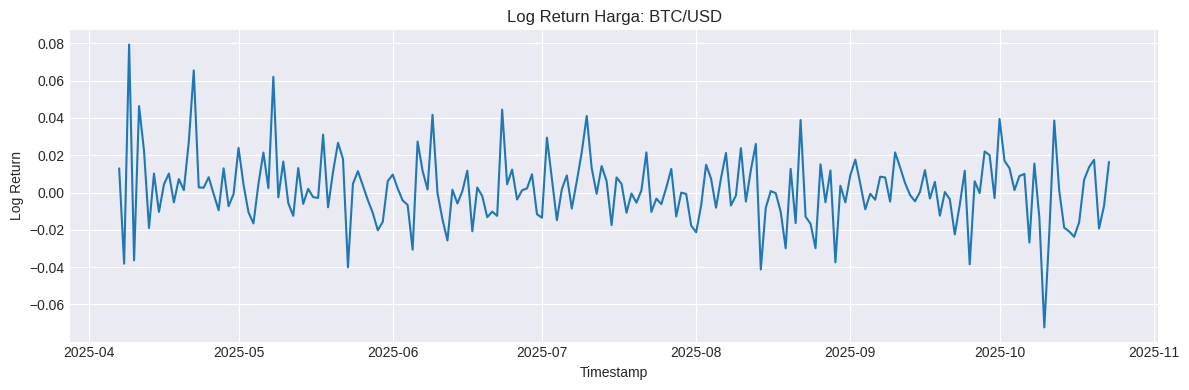


--- Output dari transformed_fred_data (Data FRED Setelah Transformasi Awal) ---

Data FRED yang Ditransformasi Awal untuk Secured Overnight Financing Rate (Head):


Secured Overnight Financing Rate_Transformed  \
1829                                         -0.02   
1830                                          0.07   
1831                                          0.02   
1832                                         -0.05   
1833                                         -0.04   

     effective_until_next_release  
1829    2025-04-09 00:00:00+00:00  
1830    2025-04-10 00:00:00+00:00  
1831    2025-04-11 00:00:00+00:00  
1832    2025-04-14 00:00:00+00:00  
1833    2025-04-15 00:00:00+00:00


Data FRED yang Ditransformasi Awal untuk Secured Overnight Financing Rate (Tail):


Secured Overnight Financing Rate_Transformed  \
1967                                          0.01   
1968                                         -0.12   
1969                                         -0.02   
1970                                          0.07   
1971                                         -0.02   

     effective_until_next_release  
1967    2025-10-20 00:00:00+00:00  
1968    2025-10-21 00:00:00+00:00  
1969    2025-10-22 00:00:00+00:00  
1970    2025-10-23 00:00:00+00:00  
1971    2025-10-23 00:00:00+00:00


Data FRED yang Ditransformasi Awal untuk S&P 500 (Head):


S&P 500_Transformed effective_until_next_release
2025-04-08               -79.48                          NaT
2025-04-09               474.13                          NaT
2025-04-10              -188.85                          NaT
2025-04-11                95.31                          NaT
2025-04-14                42.61                          NaT


Data FRED yang Ditransformasi Awal untuk S&P 500 (Tail):


S&P 500_Transformed effective_until_next_release
2025-10-16               -41.99                          NaT
2025-10-17                34.94                          NaT
2025-10-20                71.12                          NaT
2025-10-21                 0.22                          NaT
2025-10-22               -35.95                          NaT


Data FRED yang Ditransformasi Awal untuk US Corporate Index Semi-Annual Yi (Head):


US Corporate Index Semi-Annual Yi_Transformed  \
2025-04-07                                       1.728109   
2025-04-08                                       1.733424   
2025-04-09                                       1.750937   
2025-04-10                                       1.756132   
2025-04-11                                       1.768150   

           effective_until_next_release  
2025-04-07                          NaT  
2025-04-08                          NaT  
2025-04-09                          NaT  
2025-04-10                          NaT  
2025-04-11                          NaT


Data FRED yang Ditransformasi Awal untuk US Corporate Index Semi-Annual Yi (Tail):


US Corporate Index Semi-Annual Yi_Transformed  \
2025-10-16                                       1.587192   
2025-10-17                                       1.593309   
2025-10-20                                       1.589235   
2025-10-21                                       1.585145   
2025-10-22                                       1.587192   

           effective_until_next_release  
2025-10-16                          NaT  
2025-10-17                          NaT  
2025-10-20                          NaT  
2025-10-21                          NaT  
2025-10-22                          NaT


Data FRED yang Ditransformasi Awal untuk Index Semi-Annual (Head):


Index Semi-Annual_Transformed effective_until_next_release
2025-04-07                       2.158715                          NaT
2025-04-08                       2.155245                          NaT
2025-04-09                       2.143589                          NaT
2025-04-10                       2.150599                          NaT
2025-04-11                       2.145931                          NaT


Data FRED yang Ditransformasi Awal untuk Index Semi-Annual (Tail):


Index Semi-Annual_Transformed effective_until_next_release
2025-10-16                       1.909543                          NaT
2025-10-17                       1.915451                          NaT
2025-10-20                       1.906575                          NaT
2025-10-21                       1.902108                          NaT
2025-10-22                       1.906575                          NaT

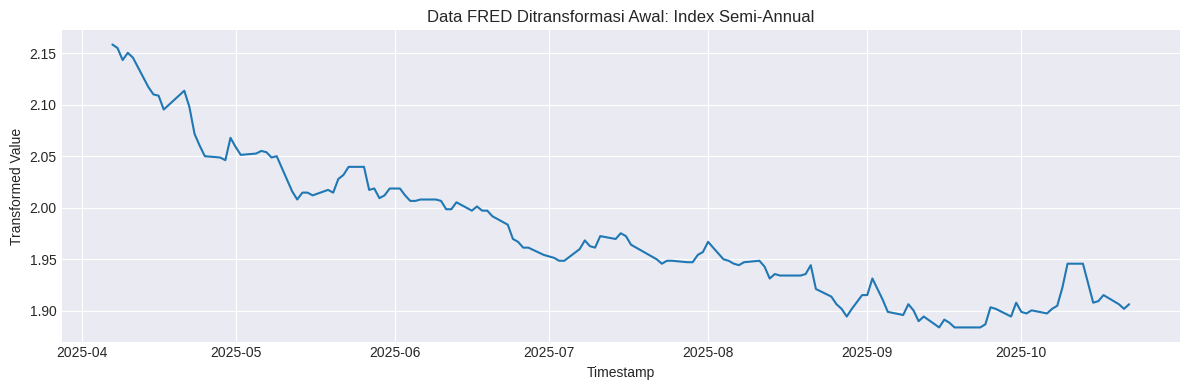


Data FRED yang Ditransformasi Awal untuk Emerging Markets Corporate (Head):


Emerging Markets Corporate_Transformed  \
2025-04-08                                    0.02   
2025-04-09                                    0.16   
2025-04-10                                   -0.08   
2025-04-11                                    0.07   
2025-04-14                                   -0.10   

           effective_until_next_release  
2025-04-08                          NaT  
2025-04-09                          NaT  
2025-04-10                          NaT  
2025-04-11                          NaT  
2025-04-14                          NaT


Data FRED yang Ditransformasi Awal untuk Emerging Markets Corporate (Tail):


Emerging Markets Corporate_Transformed  \
2025-10-16                                   -0.02   
2025-10-17                                    0.01   
2025-10-20                                   -0.02   
2025-10-21                                   -0.03   
2025-10-22                                    0.02   

           effective_until_next_release  
2025-10-16                          NaT  
2025-10-17                          NaT  
2025-10-20                          NaT  
2025-10-21                          NaT  
2025-10-22                          NaT


Data FRED yang Ditransformasi Awal untuk Markets Corporate Plus (Head):


Markets Corporate Plus_Transformed effective_until_next_release
2025-04-08                                0.04                          NaT
2025-04-09                                0.14                          NaT
2025-04-10                               -0.03                          NaT
2025-04-11                                0.05                          NaT
2025-04-14                               -0.04                          NaT


Data FRED yang Ditransformasi Awal untuk Markets Corporate Plus (Tail):


Markets Corporate Plus_Transformed effective_until_next_release
2025-10-16                               -0.02                          NaT
2025-10-17                                0.01                          NaT
2025-10-20                               -0.02                          NaT
2025-10-21                               -0.03                          NaT
2025-10-22                               -0.01                          NaT


Data FRED yang Ditransformasi Awal untuk Financial US Emerging Markets Liquiq (Head):


Financial US Emerging Markets Liquiq_Transformed  \
2025-04-08                                              0.02   
2025-04-09                                              0.15   
2025-04-10                                             -0.07   
2025-04-11                                              0.05   
2025-04-14                                             -0.05   

           effective_until_next_release  
2025-04-08                          NaT  
2025-04-09                          NaT  
2025-04-10                          NaT  
2025-04-11                          NaT  
2025-04-14                          NaT


Data FRED yang Ditransformasi Awal untuk Financial US Emerging Markets Liquiq (Tail):


Financial US Emerging Markets Liquiq_Transformed  \
2025-10-16                                             -0.03   
2025-10-17                                              0.01   
2025-10-20                                             -0.01   
2025-10-21                                             -0.03   
2025-10-22                                              0.00   

           effective_until_next_release  
2025-10-16                          NaT  
2025-10-17                          NaT  
2025-10-20                          NaT  
2025-10-21                          NaT  
2025-10-22                          NaT


Data FRED yang Ditransformasi Awal untuk Daily Sterling Overnight Index Average (SONIA)... (Head):


Daily Sterling Overnight Index Average (SONIA)..._Transformed  \
7520                                           1.494094               
7521                                           1.494117               
7522                                           1.494274               
7523                                           1.494364               
7524                                           1.494364               

     effective_until_next_release  
7520    2025-04-08 00:00:00+00:00  
7521    2025-04-09 00:00:00+00:00  
7522    2025-04-10 00:00:00+00:00  
7523    2025-04-11 00:00:00+00:00  
7524    2025-04-14 00:00:00+00:00


Data FRED yang Ditransformasi Awal untuk Daily Sterling Overnight Index Average (SONIA)... (Tail):


Daily Sterling Overnight Index Average (SONIA)..._Transformed  \
7671                                           1.378035               
7672                                           1.378161               
7673                                           1.378313               
1659                                           1.398470               
7675                                           1.378464               

     effective_until_next_release  
7671    2025-10-20 00:00:00+00:00  
7672    2025-10-21 00:00:00+00:00  
7673    2025-10-22 00:00:00+00:00  
1659    2025-10-22 00:00:00+00:00  
7675    2025-10-22 00:00:00+00:00


--- Output dari stationarity_df (Hasil Uji Stasioneritas) ---

📋 Ringkasan Hasil Uji Stasioneritas:


Series Test  PValue  \
0                                USD/CHF (Log Return)  ADF  0.0000   
1                                USD/CHF (Log Return)   PP  0.0000   
2                                USD/JPY (Log Return)  ADF  0.0000   
3                                USD/JPY (Log Return)   PP  0.0000   
4                                AUD/USD (Log Return)  ADF  0.0000   
5                                AUD/USD (Log Return)   PP  0.0000   
6                                XAU/USD (Log Return)  ADF  0.0000   
7                                XAU/USD (Log Return)   PP  0.0000   
8                                BTC/USD (Log Return)  ADF  0.0000   
9                                BTC/USD (Log Return)   PP  0.0000   
10  Secured Overnight Financing Rate (Transformed ...  ADF  0.0000   
11  Secured Overnight Financing Rate (Transformed ...   PP  0.0000   
12                         S&P 500 (Transformed FRED)  ADF  0.0000   
13                         S&P 500 (Transformed FRED)   PP  0.0000   
14  US Corporate Index Semi-Annual Yi (Transformed...  ADF  0.8167   
15  US Corporate Index Semi-Annual Yi (Transformed...   PP  0.9086   
16  US Corporate Index Semi-Annual Yi (Transformed...  ADF  0.0000   
17  US Corporate Index Semi-Annual Yi (Transformed...   PP  0.0000   
18               Index Semi-Annual (Transformed FRED)  ADF  0.0076   
19               Index Semi-Annual (Transformed FRED)   PP  0.0059   
20      Emerging Markets Corporate (Transformed FRED)  ADF  0.0000   
21      Emerging Markets Corporate (Transformed FRED)   PP  0.0000   
22          Markets Corporate Plus (Transformed FRED)  ADF  0.0000   
23          Markets Corporate Plus (Transformed FRED)   PP  0.0000   
24  Financial US Emerging Markets Liquiq (Transfor...  ADF  0.0000   
25  Financial US Emerging Markets Liquiq (Transfor...   PP  0.0000   
26  Daily Sterling Overnight Index Average (SONIA)...  ADF  0.5609   
27  Daily Sterling Overnight Index Average (SONIA)...   PP  0.5967   
28  Daily Sterling Overnight Index Average (SONIA)...  ADF  0.0000   
29  Daily Sterling Overnight Index Average (SONIA)...   PP  0.0000   

    Is_Stationary  
0            True  
1            True  
2            True  
3            True  
4            True  
5            True  
6            True  
7            True  
8            True  
9            True  
10           True  
11           True  
12           True  
13           True  
14          False  
15          False  
16           True  
17           True  
18           True  
19           True  
20           True  
21           True  
22           True  
23           True  
24           True  
25           True  
26          False  
27          False  
28           True  
29           True


--- Output dari cleaned_transformed_fred_data (Data FRED Setelah Penanganan Missing Data) ---

Data FRED yang Dibersihkan untuk Secured Overnight Financing Rate (Head):


Secured Overnight Financing Rate_Transformed  \
1829                                         -0.02   
1830                                          0.07   
1831                                          0.02   
1832                                         -0.05   
1833                                         -0.04   

     effective_until_next_release  
1829    2025-04-09 00:00:00+00:00  
1830    2025-04-10 00:00:00+00:00  
1831    2025-04-11 00:00:00+00:00  
1832    2025-04-14 00:00:00+00:00  
1833    2025-04-15 00:00:00+00:00


Data FRED yang Dibersihkan untuk Secured Overnight Financing Rate (Tail):


Secured Overnight Financing Rate_Transformed  \
1967                                          0.01   
1968                                         -0.12   
1969                                         -0.02   
1970                                          0.07   
1971                                         -0.02   

     effective_until_next_release  
1967    2025-10-20 00:00:00+00:00  
1968    2025-10-21 00:00:00+00:00  
1969    2025-10-22 00:00:00+00:00  
1970    2025-10-23 00:00:00+00:00  
1971    2025-10-23 00:00:00+00:00


Data FRED yang Dibersihkan untuk S&P 500 (Head):


S&P 500_Transformed effective_until_next_release
2025-04-08               -79.48                          NaT
2025-04-09               474.13                          NaT
2025-04-10              -188.85                          NaT
2025-04-11                95.31                          NaT
2025-04-14                42.61                          NaT


Data FRED yang Dibersihkan untuk S&P 500 (Tail):


S&P 500_Transformed effective_until_next_release
2025-10-16               -41.99                          NaT
2025-10-17                34.94                          NaT
2025-10-20                71.12                          NaT
2025-10-21                 0.22                          NaT
2025-10-22               -35.95                          NaT

ℹ️ cleaned_transformed_fred_data kosong atau belum terisi untuk Currency Conversions: US Dollar Exchange Rate.

Data FRED yang Dibersihkan untuk US Corporate Index Semi-Annual Yi (Head):


US Corporate Index Semi-Annual Yi_Transformed  \
2025-04-07                                       1.728109   
2025-04-08                                       1.733424   
2025-04-09                                       1.750937   
2025-04-10                                       1.756132   
2025-04-11                                       1.768150   

           effective_until_next_release  
2025-04-07                          NaT  
2025-04-08                          NaT  
2025-04-09                          NaT  
2025-04-10                          NaT  
2025-04-11                          NaT


Data FRED yang Dibersihkan untuk US Corporate Index Semi-Annual Yi (Tail):


US Corporate Index Semi-Annual Yi_Transformed  \
2025-10-16                                       1.587192   
2025-10-17                                       1.593309   
2025-10-20                                       1.589235   
2025-10-21                                       1.585145   
2025-10-22                                       1.587192   

           effective_until_next_release  
2025-10-16                          NaT  
2025-10-17                          NaT  
2025-10-20                          NaT  
2025-10-21                          NaT  
2025-10-22                          NaT


Data FRED yang Dibersihkan untuk Index Semi-Annual (Head):


Index Semi-Annual_Transformed effective_until_next_release
2025-04-07                       2.158715                          NaT
2025-04-08                       2.155245                          NaT
2025-04-09                       2.143589                          NaT
2025-04-10                       2.150599                          NaT
2025-04-11                       2.145931                          NaT


Data FRED yang Dibersihkan untuk Index Semi-Annual (Tail):


Index Semi-Annual_Transformed effective_until_next_release
2025-10-16                       1.909543                          NaT
2025-10-17                       1.915451                          NaT
2025-10-20                       1.906575                          NaT
2025-10-21                       1.902108                          NaT
2025-10-22                       1.906575                          NaT

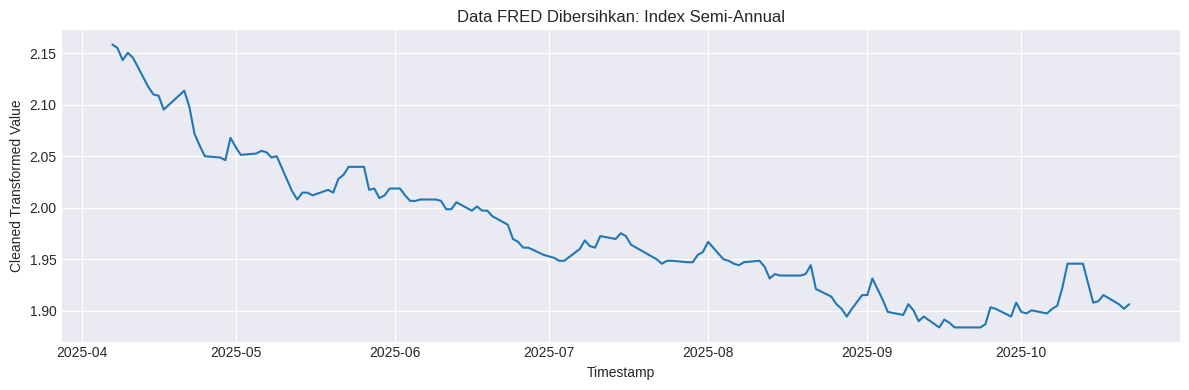


Data FRED yang Dibersihkan untuk Emerging Markets Corporate (Head):


Emerging Markets Corporate_Transformed  \
2025-04-08                                    0.02   
2025-04-09                                    0.16   
2025-04-10                                   -0.08   
2025-04-11                                    0.07   
2025-04-14                                   -0.10   

           effective_until_next_release  
2025-04-08                          NaT  
2025-04-09                          NaT  
2025-04-10                          NaT  
2025-04-11                          NaT  
2025-04-14                          NaT


Data FRED yang Dibersihkan untuk Emerging Markets Corporate (Tail):


Emerging Markets Corporate_Transformed  \
2025-10-16                                   -0.02   
2025-10-17                                    0.01   
2025-10-20                                   -0.02   
2025-10-21                                   -0.03   
2025-10-22                                    0.02   

           effective_until_next_release  
2025-10-16                          NaT  
2025-10-17                          NaT  
2025-10-20                          NaT  
2025-10-21                          NaT  
2025-10-22                          NaT


Data FRED yang Dibersihkan untuk Markets Corporate Plus (Head):


Markets Corporate Plus_Transformed effective_until_next_release
2025-04-08                                0.04                          NaT
2025-04-09                                0.14                          NaT
2025-04-10                               -0.03                          NaT
2025-04-11                                0.05                          NaT
2025-04-14                               -0.04                          NaT


Data FRED yang Dibersihkan untuk Markets Corporate Plus (Tail):


Markets Corporate Plus_Transformed effective_until_next_release
2025-10-16                               -0.02                          NaT
2025-10-17                                0.01                          NaT
2025-10-20                               -0.02                          NaT
2025-10-21                               -0.03                          NaT
2025-10-22                               -0.01                          NaT


Data FRED yang Dibersihkan untuk Financial US Emerging Markets Liquiq (Head):


Financial US Emerging Markets Liquiq_Transformed  \
2025-04-08                                              0.02   
2025-04-09                                              0.15   
2025-04-10                                             -0.07   
2025-04-11                                              0.05   
2025-04-14                                             -0.05   

           effective_until_next_release  
2025-04-08                          NaT  
2025-04-09                          NaT  
2025-04-10                          NaT  
2025-04-11                          NaT  
2025-04-14                          NaT


Data FRED yang Dibersihkan untuk Financial US Emerging Markets Liquiq (Tail):


Financial US Emerging Markets Liquiq_Transformed  \
2025-10-16                                             -0.03   
2025-10-17                                              0.01   
2025-10-20                                             -0.01   
2025-10-21                                             -0.03   
2025-10-22                                              0.00   

           effective_until_next_release  
2025-10-16                          NaT  
2025-10-17                          NaT  
2025-10-20                          NaT  
2025-10-21                          NaT  
2025-10-22                          NaT


Data FRED yang Dibersihkan untuk Daily Sterling Overnight Index Average (SONIA)... (Head):


Daily Sterling Overnight Index Average (SONIA)..._Transformed  \
7520                                           1.494094               
7521                                           1.494117               
7522                                           1.494274               
7523                                           1.494364               
7524                                           1.494364               

     effective_until_next_release  
7520    2025-04-08 00:00:00+00:00  
7521    2025-04-09 00:00:00+00:00  
7522    2025-04-10 00:00:00+00:00  
7523    2025-04-11 00:00:00+00:00  
7524    2025-04-14 00:00:00+00:00


Data FRED yang Dibersihkan untuk Daily Sterling Overnight Index Average (SONIA)... (Tail):


Daily Sterling Overnight Index Average (SONIA)..._Transformed  \
7671                                           1.378035               
7672                                           1.378161               
7673                                           1.378313               
1659                                           1.398470               
7675                                           1.378464               

     effective_until_next_release  
7671    2025-10-20 00:00:00+00:00  
7672    2025-10-21 00:00:00+00:00  
7673    2025-10-22 00:00:00+00:00  
1659    2025-10-22 00:00:00+00:00  
7675    2025-10-22 00:00:00+00:00


✅ Visualisasi dan tampilan data selesai.


In [25]:
# cell_id: visualize_transformed_data
# ============================================================
# 📊 Visualisasi Data yang Ditransformasi dan Dibersihkan
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n📊 Menampilkan dan memvisualisasikan data yang telah ditransformasi dan dibersihkan...")

# --- Output dari log_return_dfs ---
print("\n--- Output dari log_return_dfs (Log Return Harga) ---")
if 'log_return_dfs' in globals() and log_return_dfs:
    for pair_name, df_log_return in log_return_dfs.items():
        if not df_log_return.empty:
            print(f"\nLog-Return untuk {pair_name} (Head):")
            display(df_log_return.head())
            print(f"\nLog-Return untuk {pair_name} (Tail):")
            display(df_log_return.tail())
            # Optional: Plot log returns for a few pairs
            if len(log_return_dfs) <= 3 or pair_name in ['EUR/USD', 'BTC/USD']: # Limit plots to avoid clutter
                 plt.figure(figsize=(12, 4))
                 plt.plot(df_log_return.index, df_log_return['Log_Return'])
                 plt.title(f'Log Return Harga: {pair_name}')
                 plt.ylabel('Log Return')
                 plt.xlabel('Timestamp')
                 plt.tight_layout()
                 plt.show()

        else:
            print(f"ℹ️ log_return_dfs kosong atau belum terisi untuk {pair_name}.")
else:
    print("⚠️ Variabel 'log_return_dfs' tidak ditemukan atau kosong. Jalankan sel 'apply_log_return_to_price' terlebih dahulu.")

# --- Output dari transformed_fred_data (Data FRED Setelah Transformasi Awal) ---
print("\n--- Output dari transformed_fred_data (Data FRED Setelah Transformasi Awal) ---")
# Check if transformed_fred_data exists and is not empty before iterating
if 'transformed_fred_data' in globals() and transformed_fred_data:
    if isinstance(transformed_fred_data, dict):
        for series_name, df_transformed in transformed_fred_data.items():
             if not df_transformed.empty:
                print(f"\nData FRED yang Ditransformasi Awal untuk {series_name} (Head):")
                display(df_transformed.head())
                print(f"\nData FRED yang Ditransformasi Awal untuk {series_name} (Tail):")
                display(df_transformed.tail())
                # Optional: Plot transformed FRED data for a few series
                transformed_col_name = f"{series_name}_Transformed"
                if transformed_col_name in df_transformed.columns:
                    if len(transformed_fred_data) <= 3 or series_name in ['Index Semi-Annual', 'Lewis-Mertens-Stock']: # Limit plots
                         plt.figure(figsize=(12, 4))
                         plt.plot(df_transformed.index, df_transformed[transformed_col_name])
                         plt.title(f'Data FRED Ditransformasi Awal: {series_name}')
                         plt.ylabel('Transformed Value')
                         plt.xlabel('Timestamp')
                         plt.tight_layout()
                         plt.show()
    elif isinstance(transformed_fred_data, pd.DataFrame) and not transformed_fred_data.empty:
         print(f"\nData FRED yang Ditransformasi Awal (DataFrame, Head):")
         display(transformed_fred_data.head())
         print(f"\nData FRED yang Ditransformasi Awal (DataFrame, Tail):")
         display(transformed_fred_data.tail())

else:
    print("⚠️ Variabel 'transformed_fred_data' tidak ditemukan atau kosong. Jalankan sel 'transform_fred_data' terlebih dahulu.")


# --- Output dari stationarity_df (Hasil Uji Stasioneritas) ---
print("\n--- Output dari stationarity_df (Hasil Uji Stasioneritas) ---")
if 'stationarity_df' in globals() and not stationarity_df.empty:
    print("\n📋 Ringkasan Hasil Uji Stasioneritas:")
    display(stationarity_df)
else:
    print("⚠️ Variabel 'stationarity_df' tidak ditemukan atau kosong. Jalankan sel 'stationarity_test' terlebih dahulu.")

# --- Output dari cleaned_transformed_fred_data (Data FRED Setelah Penanganan Missing Data) ---
print("\n--- Output dari cleaned_transformed_fred_data (Data FRED Setelah Penanganan Missing Data) ---")
# Check if cleaned_transformed_fred_data exists and is not empty before iterating
# It should be a dictionary based on how handle_missing_fred_data creates it
if 'cleaned_transformed_fred_data' in globals() and cleaned_transformed_fred_data:
    if isinstance(cleaned_transformed_fred_data, dict):
        for series_name, df_cleaned in cleaned_transformed_fred_data.items():
            if not df_cleaned.empty:
                print(f"\nData FRED yang Dibersihkan untuk {series_name} (Head):")
                display(df_cleaned.head())
                print(f"\nData FRED yang Dibersihkan untuk {series_name} (Tail):")
                display(df_cleaned.tail())

                # Plotting logic for the cleaned data
                transformed_col_name = f"{series_name}_Transformed"
                if transformed_col_name in df_cleaned.columns:
                    # Optional: Plot cleaned FRED data for a few series
                    if len(cleaned_transformed_fred_data) <= 3 or series_name in ['Index Semi-Annual', 'Lewis-Mertens-Stock']: # Limit plots
                         plt.figure(figsize=(12, 4))
                         plt.plot(df_cleaned.index, df_cleaned[transformed_col_name])
                         plt.title(f'Data FRED Dibersihkan: {series_name}')
                         plt.ylabel('Cleaned Transformed Value')
                         plt.xlabel('Timestamp')
                         plt.tight_layout()
                         plt.show()
                else:
                    print(f"ℹ️ Kolom nilai yang ditransformasi '{transformed_col_name}' tidak ditemukan di cleaned_transformed_fred_data untuk {series_name}. Tidak bisa diplot.")

            else:
                print(f"ℹ️ cleaned_transformed_fred_data kosong atau belum terisi untuk {series_name}.")

    # Add a fallback check if it's somehow a DataFrame (though it shouldn't be after handle_missing_fred_data)
    elif 'cleaned_transformed_fred_data' in globals() and isinstance(cleaned_transformed_fred_data, pd.DataFrame) and not cleaned_transformed_fred_data.empty:
         print(f"\nData FRED yang Dibersihkan (DataFrame, Head):")
         display(cleaned_transformed_fred_data.head())
         print(f"\nData FRED yang Dibersihkan (DataFrame, Tail):")
         display(cleaned_transformed_fred_data.tail())

         # Plotting logic for the cleaned DataFrame
         transformed_value_cols = [col for col in cleaned_transformed_fred_data.columns if col.endswith("_Transformed")]
         if transformed_value_cols:
             for transformed_col_name in transformed_value_cols:
                 series_name = transformed_col_name.replace("_Transformed", "")
                 # Optional: Plot cleaned FRED data for a few series
                 if len(transformed_value_cols) <= 3 or series_name in ['Index Semi-Annual', 'Lewis-Mertens-Stock']: # Limit plots
                      plt.figure(figsize=(12, 4))
                      plt.plot(cleaned_transformed_fred_data.index, cleaned_transformed_fred_data[transformed_col_name])
                      plt.title(f'Data FRED Dibersihkan: {series_name}')
                      plt.ylabel('Cleaned Transformed Value')
                      plt.xlabel('Timestamp')
                      plt.tight_layout()
                      plt.show()
         else:
             print("ℹ️ Tidak ada kolom nilai yang ditransformasi untuk diplot di cleaned_transformed_fred_data.")


else:
    print("⚠️ Variabel 'cleaned_transformed_fred_data' tidak ditemukan atau kosong. Jalankan sel 'handle_missing_fred_data' terlebih dahulu.")


print("\n✅ Visualisasi dan tampilan data selesai.")

## **3. Granger Causality Network**

### 🎯 Tujuan: Mengidentifikasi arah dan kekuatan hubungan antar variabel.

**Langkah:**

1. Jalankan uji **bidirectional Granger** antar semua pasangan Makro ↔ Harga.

   * Gunakan `statsmodels.tsa.stattools.grangercausalitytests`.
   * Simpan `p-value` dan `optimal lag`.

2. Buat **peta jaringan kausalitas**:

   * Node = variabel (FRED series / Pair)
   * Edge = arah hubungan signifikan (p < α)
   * Visualisasi dengan `networkx` (Graph of influence).

In [26]:
# cell_id: BV4tSo-lweKq
def find_best_granger_lag(data, cause, effect, maxlag):
    """Return best lag (1..maxlag) that gives smallest p-value for ssr_ftest, plus the p-value.
       data should be a DataFrame with columns [effect, cause].
    """
    best_p = 1.0
    best_lag = None
    for lag in range(1, maxlag+1):
        try:
            res = grangercausalitytests(data[[effect, cause]], maxlag=lag, verbose=False)
            p = res[lag][0]['ssr_ftest'][1]
            if p < best_p:
                best_p = p
                best_lag = lag
        except Exception:
            continue
    return best_lag, best_p

In [27]:

# ============================================================
# 🧩 FIX: Normalisasi dan validasi index + kolom FRED sebelum Granger test
# ============================================================
import pandas as pd

for k, df in list(final_stationarized_fred_data.items()):
    if df is None or df.empty:
        continue

    # --- Pastikan index bertipe datetime ---
    if not isinstance(df.index, pd.DatetimeIndex) or (df.index.min().year < 1980):
        # Coba ambil kolom waktu dari release_date / effective_until_next_release
        time_col = None
        for col in ["effective_until_next_release", "release_date", "date"]:
            if col in df.columns:
                time_col = col
                break
        if time_col:
            df.index = pd.to_datetime(df[time_col], errors="coerce", utc=True)
        else:
            df.index = pd.to_datetime(df.index, errors="coerce", utc=True)
    df = df[~df.index.isna()]

    # --- Pastikan timezone-aware ---
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")

    # --- Drop duplikat index dan sort ---
    df = df[~df.index.duplicated(keep="last")].sort_index()

    # --- Rename kolom dummy series_0..n jadi ID FRED sesuai urutan ---
    if "FRED_SERIES" in globals():
        keys = list(FRED_SERIES.keys())
        rename_map = {}
        for i, col in enumerate(df.columns):
            if col.startswith("series_") and i < len(keys):
                rename_map[col] = keys[i]
        df.rename(columns=rename_map, inplace=True)

    final_stationarized_fred_data[k] = df

In [28]:
# ============================================================
# 🧠 GRANGER TEST: Bidirectional Makro ↔ Pair (Implementasi)
# ============================================================
print("\n🔬 Menjalankan Granger causality (Bidirectional Makro ↔ Pair)...")

# Define the macro series columns to test (use the keys from FRED_SERIES)
# We will use the keys from FRED_SERIES to identify the original series names
# Ensure FRED_SERIES is accessible, assume it is global or defined earlier
if 'FRED_SERIES' not in globals():
    print("⚠️ Variabel FRED_SERIES tidak ditemukan. Tidak dapat melanjutkan uji Granger.")
    macro_granger_df = pd.DataFrame()
else:
    original_macro_series_names = list(FRED_SERIES.keys())

    # Include the function definition here to avoid NameError if it wasn't run before
    def find_best_granger_lag(data, cause, effect, maxlag):
        """Return best lag (1..maxlag) that gives smallest p-value for ssr_ftest, plus the p-value.
           data should be a DataFrame with columns [effect, cause].
        """
        best_p = 1.0
        best_lag = None
        for lag in range(1, maxlag+1):
            try:
                res = grangercausalitytests(data[[effect, cause]], maxlag=lag, verbose=False)
                p = res[lag][0]['ssr_ftest'][1]
                if p < best_p:
                    best_p = p
                    best_lag = lag
            except Exception:
                continue
        return best_lag, best_p


    # Ensure final_stationarized_fred_data is available and not empty before proceeding
    if 'final_stationarized_fred_data' not in globals() or not final_stationarized_fred_data:
        print("⚠️ Data FRED yang distasionerkan (final_stationarized_fred_data) kosong atau tidak ditemukan. Melewati uji Granger.")
        macro_granger_df = pd.DataFrame()
    else:
        # Combine the stationarized FRED data from the dictionary into a single DataFrame
        # Use the index for merging (which should be datetime after stationarity test)
        combined_stationarized_fred_df = pd.DataFrame()
        first_series = True
        for series_name, df_series in final_stationarized_fred_data.items():
            if not df_series.empty:
                # Find the value column (ending with "_FinalTransformed")
                value_cols = [col for col in df_series.columns if col.endswith("_FinalTransformed")]
                if value_cols:
                     value_col = value_cols[0]
                     # Rename the value column to the original series name for clarity
                     # Use the name from FRED_SERIES based on the original series_ index
                     original_name = None
                     try:
                         # Extract the series index from the key (e.g., 'series_0' -> 0)
                         series_index = int(series_name.replace('series_', ''))
                         if series_index < len(original_macro_series_names):
                              original_name = original_macro_series_names[series_index]
                     except (ValueError, IndexError):
                         # Fallback to the series_ name if original name mapping fails
                         original_name = series_name


                     if original_name:
                          df_series = df_series.rename(columns={value_col: original_name})
                          if first_series:
                              # Start with the first non-empty series DataFrame
                              # Keep only the renamed value column and the effective_until_next_release if it exists
                              cols_to_keep = [original_name]
                              if "effective_until_next_release" in df_series.columns:
                                   cols_to_keep.append("effective_until_next_release")
                              combined_stationarized_fred_df = df_series[cols_to_keep].copy()
                              first_series = False
                          else:
                              # Merge subsequent dataframes based on index (datetime)
                              cols_to_merge = [original_name]
                              if "effective_until_next_release" in df_series.columns:
                                   # If effective_until_next_release exists in this series, merge it
                                   # Use combine_first to keep the latest non-null date
                                   if "effective_until_next_release" not in combined_stationarized_fred_df.columns:
                                        combined_stationarized_fred_df["effective_until_next_release"] = df_series["effective_until_next_release"]
                                   else:
                                        combined_stationarized_fred_df["effective_until_next_release"] = combined_stationarized_fred_df["effective_until_next_release"].combine_first(df_series["effective_until_next_release"])

                              combined_stationarized_fred_df = combined_stationarized_fred_df.merge(
                                   df_series[cols_to_merge],
                                   left_index=True,
                                   right_index=True,
                                   how="outer" # Use outer merge to keep all dates
                               )
                     else:
                         print(f"⚠️ Gagal memetakan nama asli untuk seri '{series_name}'. Dilewati penggabungan.")

            else:
                print(f"ℹ️ DataFrame untuk '{series_name}' kosong. Dilewati penggabungan.")


        if combined_stationarized_fred_df.empty:
            print("⚠️ Data FRED yang distasionerkan kosong setelah digabungkan. Melewati uji Granger.")
            macro_granger_df = pd.DataFrame()
        else:
            # Forward fill any NaNs introduced by the outer merge (for value columns)
            # Ensure effective_until_next_release is also forward-filled if it exists
            cols_to_ffill = [col for col in combined_stationarized_fred_df.columns if col != "effective_until_next_release"]
            combined_stationarized_fred_df[cols_to_ffill] = combined_stationarized_fred_df[cols_to_ffill].ffill()
            if "effective_until_next_release" in combined_stationarized_fred_df.columns:
                combined_stationarized_fred_df["effective_until_next_release"] = combined_stationarized_fred_df["effective_until_next_release"].ffill()


            # Ensure index is datetime and timezone-aware (UTC)
            if not isinstance(combined_stationarized_fred_df.index, pd.DatetimeIndex):
                combined_stationarized_fred_df.index = pd.to_datetime(combined_stationarized_fred_df.index, errors="coerce", utc=True)
            if combined_stationarized_fred_df.index.tz is None:
                combined_stationarized_fred_df = combined_stationarized_fred_df.tz_localize("UTC", nonexistent='shift_forward', ambiguous='NaT')


            print(f"✅ Data FRED yang distasionerkan berhasil digabung. Shape: {combined_stationarized_fred_df.shape}")
            display(combined_stationarized_fred_df.head())


            all_granger_results = []

            # Iterate through each pair in base_dfs
            for pair_name, pair_df_base in base_dfs.items():
                print(f"\n🔍 Menguji pair: {pair_name}")
                # Align FRED data with the current pair's base data
                # Ensure both DataFrames have datetime indices and are timezone-aware

                # Ensure pair_df_base index is timezone-aware (should be from download_base_symbol)
                if pair_df_base.index.tzinfo is None:
                     pair_df_base = pair_df_base.tz_localize("UTC", nonexistent='shift_forward', ambiguous='NaT')


                # Select FRED data within the pair's time range and reindex to align
                start_time = pair_df_base.index.min()
                end_time = pair_df_base.index.max()

                # Filter FRED data within the time range, then reindex to align with pair_df_base
                # Need to select only the value columns (excluding effective_until_next_release) before reindexing
                fred_value_cols = [col for col in combined_stationarized_fred_df.columns if col != "effective_until_next_release"]

                if not fred_value_cols:
                     print(f"⚠️ Tidak ada kolom nilai di combined_stationarized_fred_df untuk {pair_name}. Melewati uji Granger.")
                     continue


                sub_fred_values = combined_stationarized_fred_df[fred_value_cols].loc[(combined_stationarized_fred_df.index >= start_time) & (combined_stationarized_fred_df.index <= end_time)].copy()

                if sub_fred_values.empty:
                    print(f"⚠️ Tidak ada data FRED dalam jangkauan waktu {pair_name} setelah filtering. Melewati uji Granger.")
                    continue

                # Reindex the FRED values to the price data index using forward fill
                aligned_fred_values = sub_fred_values.reindex(pair_df_base.index, method="ffill")

                # Drop any macro columns that are all NaN in the aligned data (no data in this period)
                aligned_fred_values.dropna(axis=1, how='all', inplace=True)

                # Ensure the 'Close' column exists in the pair_df_base
                if "Close" not in pair_df_base.columns:
                    print(f"⚠️ Data harga untuk {pair_name} tidak memiliki kolom 'Close'. Melewati uji Granger.")
                    continue

                # Ensure there are valid exogenous columns left after dropping NaNs
                valid_fred_cols = aligned_fred_values.columns.tolist()
                if not valid_fred_cols:
                    print(f"⚠️ Tidak ada kolom FRED valid yang tersisa setelah penanganan NaN untuk {pair_name}. Melewati uji Granger.")
                    continue


                # Combine pair data ("Close") with aligned FRED data
                # Only keep the 'Close' column from the pair data and the selected macro columns from aligned_fred_values
                df_combined_for_granger = pd.concat([pair_df_base[["Close"]], aligned_fred_values[valid_fred_cols]], axis=1).dropna()


                if df_combined_for_granger.empty:
                    print(f"⚠️ Data gabungan kosong setelah dropna untuk {pair_name}. Melewati uji Granger.")
                    continue

                print(f"📊 Data gabungan untuk uji Granger {pair_name}: {df_combined_for_granger.shape}")


                # --- Run Granger test for each macro series against the pair's Close price (Macro -> Pair) ---
                for cause in valid_fred_cols:
                    effect = "Close" # The effect is always the pair's Close price
                    sub_data = df_combined_for_granger[[effect, cause]].dropna()

                    if len(sub_data) < maxlag_test + 2:
                         print(f"ℹ️ Data tidak cukup untuk uji Granger ({cause} → {pair_name}). Min observasi: {maxlag_test + 2}, Tersedia: {len(sub_data)}.")
                         continue

                    try:
                        # Use the find_best_granger_lag function
                        best_lag, best_p = find_best_granger_lag(sub_data, cause, effect, maxlag=maxlag_test)

                        if best_lag is not None and best_p < alpha:
                            all_granger_results.append({
                                "Relation": "Macro -> Pair",
                                "Pair": pair_name,
                                "Cause": cause,
                                "Effect": effect, # Explicitly state effect is "Close"
                                "Best_Lag": best_lag,
                                "PValue": best_p,
                                "Observations": len(sub_data)
                            })
                            print(f"✅ {cause} → {pair_name} (Close): lag={best_lag}, p={best_p:.4f}")
                        # else:
                        #      print(f"ℹ️ {cause} → {pair_name} (Close): p-value > alpha ({alpha}) atau tidak ada lag signifikan. p={best_p:.4f}")

                    except Exception as e:
                        print(f"⚠️ Uji Granger gagal untuk {cause} → {pair_name}: {e}")

                # --- Run Granger test for the pair's Close price against each macro series (Pair -> Macro) ---
                cause = "Close" # The cause is the pair's Close price
                for effect in valid_fred_cols:
                     sub_data = df_combined_for_granger[[effect, cause]].dropna()

                     if len(sub_data) < maxlag_test + 2:
                          print(f"ℹ️ Data tidak cukup untuk uji Granger ({pair_name} → {effect}). Min observasi: {maxlag_test + 2}, Tersedia: {len(sub_data)}.")
                          continue

                     try:
                         # Use the find_best_granger_lag function
                         best_lag, best_p = find_best_granger_lag(sub_data, cause, effect, maxlag=maxlag_test)

                         if best_lag is not None and best_p < alpha:
                             all_granger_results.append({
                                 "Relation": "Pair -> Macro",
                                 "Pair": pair_name,
                                 "Cause": cause, # Explicitly state cause is "Close"
                                 "Effect": effect,
                                 "Best_Lag": best_lag,
                                 "PValue": best_p,
                                 "Observations": len(sub_data)
                             })
                             print(f"✅ {pair_name} (Close) → {effect}: lag={best_lag}, p={best_p:.4f}")
                         # else:
                         #      print(f"ℹ️ {pair_name} (Close) → {effect}: p-value > alpha ({alpha}) atau tidak ada lag signifikan. p={best_p:.4f}")

                     except Exception as e:
                         print(f"⚠️ Uji Granger gagal untuk {pair_name} → {effect}: {e}")

        # Convert results list to DataFrame
        macro_granger_df = pd.DataFrame(all_granger_results)

        if not macro_granger_df.empty:
            print("\n📋 Ringkasan Hasil Uji Granger (Makro ↔ Pair):")
            # Format PValue for better readability
            macro_granger_df['PValue'] = macro_granger_df['PValue'].apply(lambda x: f"{x:.4f}")
            display(macro_granger_df)
            # Optional: Plot the results (e.g., using the plot_macro_granger_results function)
            # plot_macro_granger_results(macro_granger_df[macro_granger_df['Relation'] == 'Macro -> Pair'])
        else:
            print("\nℹ️ Tidak ada hubungan Granger signifikan (Makro ↔ Pair) ditemukan.")


🔬 Menjalankan Granger causality (Bidirectional Makro ↔ Pair)...
ℹ️ DataFrame untuk 'Currency Conversions: US Dollar Exchange Rate' kosong. Dilewati penggabungan.
✅ Data FRED yang distasionerkan berhasil digabung. Shape: (281, 9)


Secured Overnight Financing Rate  \
1970-01-01 00:00:00.000001829+00:00                             -0.02   
1970-01-01 00:00:00.000001830+00:00                              0.07   
1970-01-01 00:00:00.000001831+00:00                              0.02   
1970-01-01 00:00:00.000001832+00:00                             -0.05   
1970-01-01 00:00:00.000001833+00:00                             -0.04   

                                     S&P 500 effective_until_next_release  \
1970-01-01 00:00:00.000001829+00:00      NaN                          NaT   
1970-01-01 00:00:00.000001830+00:00      NaN                          NaT   
1970-01-01 00:00:00.000001831+00:00      NaN                          NaT   
1970-01-01 00:00:00.000001832+00:00      NaN                          NaT   
1970-01-01 00:00:00.000001833+00:00      NaN                          NaT   

                                     US Corporate Index Semi-Annual Yi  \
1970-01-01 00:00:00.000001829+00:00                                NaN   
1970-01-01 00:00:00.000001830+00:00                                NaN   
1970-01-01 00:00:00.000001831+00:00                                NaN   
1970-01-01 00:00:00.000001832+00:00                                NaN   
1970-01-01 00:00:00.000001833+00:00                                NaN   

                                     Index Semi-Annual  \
1970-01-01 00:00:00.000001829+00:00                NaN   
1970-01-01 00:00:00.000001830+00:00                NaN   
1970-01-01 00:00:00.000001831+00:00                NaN   
1970-01-01 00:00:00.000001832+00:00                NaN   
1970-01-01 00:00:00.000001833+00:00                NaN   

                                     Emerging Markets Corporate  \
1970-01-01 00:00:00.000001829+00:00                         NaN   
1970-01-01 00:00:00.000001830+00:00                         NaN   
1970-01-01 00:00:00.000001831+00:00                         NaN   
1970-01-01 00:00:00.000001832+00:00                         NaN   
1970-01-01 00:00:00.000001833+00:00                         NaN   

                                     Markets Corporate Plus  \
1970-01-01 00:00:00.000001829+00:00                     NaN   
1970-01-01 00:00:00.000001830+00:00                     NaN   
1970-01-01 00:00:00.000001831+00:00                     NaN   
1970-01-01 00:00:00.000001832+00:00                     NaN   
1970-01-01 00:00:00.000001833+00:00                     NaN   

                                     Financial US Emerging Markets Liquiq  \
1970-01-01 00:00:00.000001829+00:00                                   NaN   
1970-01-01 00:00:00.000001830+00:00                                   NaN   
1970-01-01 00:00:00.000001831+00:00                                   NaN   
1970-01-01 00:00:00.000001832+00:00                                   NaN   
1970-01-01 00:00:00.000001833+00:00                                   NaN   

                                     Daily Sterling Overnight Index Average (SONIA)...  
1970-01-01 00:00:00.000001829+00:00                                                NaN  
1970-01-01 00:00:00.000001830+00:00                                                NaN  
1970-01-01 00:00:00.000001831+00:00                                                NaN  
1970-01-01 00:00:00.000001832+00:00                                                NaN  
1970-01-01 00:00:00.000001833+00:00                                                NaN


🔍 Menguji pair: USD/CHF
📊 Data gabungan untuk uji Granger USD/CHF: (139, 9)
✅ S&P 500 → USD/CHF (Close): lag=1, p=0.0000
✅ US Corporate Index Semi-Annual Yi → USD/CHF (Close): lag=3, p=0.0000
✅ Index Semi-Annual → USD/CHF (Close): lag=6, p=0.0078
✅ Emerging Markets Corporate → USD/CHF (Close): lag=2, p=0.0000
✅ Markets Corporate Plus → USD/CHF (Close): lag=1, p=0.0014
✅ Financial US Emerging Markets Liquiq → USD/CHF (Close): lag=1, p=0.0000
✅ USD/CHF (Close) → US Corporate Index Semi-Annual Yi: lag=8, p=0.0034
✅ USD/CHF (Close) → Emerging Markets Corporate: lag=8, p=0.0086
✅ USD/CHF (Close) → Markets Corporate Plus: lag=8, p=0.0324
✅ USD/CHF (Close) → Financial US Emerging Markets Liquiq: lag=8, p=0.0042

🔍 Menguji pair: USD/JPY
📊 Data gabungan untuk uji Granger USD/JPY: (139, 9)
✅ S&P 500 → USD/JPY (Close): lag=1, p=0.0017
✅ US Corporate Index Semi-Annual Yi → USD/JPY (Close): lag=1, p=0.0000
✅ Index Semi-Annual → USD/JPY (Close): lag=2, p=0.0017
✅ Emerging Markets Corporate → USD/JP

Relation     Pair                                              Cause  \
0   Macro -> Pair  USD/CHF                                            S&P 500   
1   Macro -> Pair  USD/CHF                  US Corporate Index Semi-Annual Yi   
2   Macro -> Pair  USD/CHF                                  Index Semi-Annual   
3   Macro -> Pair  USD/CHF                         Emerging Markets Corporate   
4   Macro -> Pair  USD/CHF                             Markets Corporate Plus   
5   Macro -> Pair  USD/CHF               Financial US Emerging Markets Liquiq   
6   Pair -> Macro  USD/CHF                                              Close   
7   Pair -> Macro  USD/CHF                                              Close   
8   Pair -> Macro  USD/CHF                                              Close   
9   Pair -> Macro  USD/CHF                                              Close   
10  Macro -> Pair  USD/JPY                                            S&P 500   
11  Macro -> Pair  USD/JPY                  US Corporate Index Semi-Annual Yi   
12  Macro -> Pair  USD/JPY                                  Index Semi-Annual   
13  Macro -> Pair  USD/JPY                         Emerging Markets Corporate   
14  Macro -> Pair  USD/JPY                             Markets Corporate Plus   
15  Macro -> Pair  USD/JPY               Financial US Emerging Markets Liquiq   
16  Pair -> Macro  USD/JPY                                              Close   
17  Pair -> Macro  USD/JPY                                              Close   
18  Macro -> Pair  AUD/USD                                            S&P 500   
19  Macro -> Pair  AUD/USD                  US Corporate Index Semi-Annual Yi   
20  Macro -> Pair  AUD/USD                                  Index Semi-Annual   
21  Macro -> Pair  AUD/USD  Daily Sterling Overnight Index Average (SONIA)...   
22  Pair -> Macro  AUD/USD                                              Close   
23  Pair -> Macro  AUD/USD                                              Close   
24  Pair -> Macro  AUD/USD                                              Close   
25  Pair -> Macro  AUD/USD                                              Close   
26  Macro -> Pair  XAU/USD                                            S&P 500   
27  Macro -> Pair  XAU/USD                                  Index Semi-Annual   
28  Pair -> Macro  XAU/USD                                              Close   
29  Pair -> Macro  XAU/USD                                              Close   
30  Macro -> Pair  BTC/USD                                            S&P 500   
31  Macro -> Pair  BTC/USD                                  Index Semi-Annual   
32  Pair -> Macro  BTC/USD                                              Close   
33  Pair -> Macro  BTC/USD                                              Close   

                                               Effect  Best_Lag  PValue  \
0                                               Close         1  0.0000   
1                                               Close         3  0.0000   
2                                               Close         6  0.0078   
3                                               Close         2  0.0000   
4                                               Close         1  0.0014   
5                                               Close         1  0.0000   
6                   US Corporate Index Semi-Annual Yi         8  0.0034   
7                          Emerging Markets Corporate         8  0.0086   
8                              Markets Corporate Plus         8  0.0324   
9                Financial US Emerging Markets Liquiq         8  0.0042   
10                                              Close         1  0.0017   
11                                              Close         1  0.0000   
12                                              Close         2  0.0017   
13                                              Close         1  0.0000   
14                                              

In [29]:
print("Rentang waktu data FRED:")
if 'fred_df' in globals() and fred_df is not None and not fred_df.empty:
    print(f"Start: {fred_df.index.min()}")
    print(f"End: {fred_df.index.max()}")
else:
    print("Variabel fred_df tidak ditemukan atau kosong.")

print("\nRentang waktu data harga USD/JPY:")
if 'base_dfs' in globals() and "USD/JPY" in base_dfs and base_dfs["USD/JPY"] is not None and not base_dfs["USD/JPY"].empty:
    print(f"Start: {base_dfs['USD/JPY'].index.min()}")
    print(f"End: {base_dfs['USD/JPY'].index.max()}")
else:
    print("Data harga untuk USD/JPY tidak ditemukan atau kosong.")

Rentang waktu data FRED:
Start: 2025-04-07 00:00:00+00:00
End: 2025-10-23 00:00:00+00:00

Rentang waktu data harga USD/JPY:
Start: 2025-04-07 00:00:00+00:00
End: 2025-10-22 00:00:00+00:00


In [30]:
#cell id : RmpJ8rtUp2YP
# ============================================================
# ✅ Definisi fungsi fit_varx_or_arx() dan visualisasinya
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

def fit_varx_or_arx(df_pair,
                    endog_cols = ["Close"],
                    exog_cols = None,
                    maxlags = 4,
                    criterion = "aic"):
    """
    Fit VARX if endog multivariate, otherwise fit SARIMAX (ARX) for single endog.
    Returns dict with model results and diagnostics.
    """
    result = {"model_type": None, "fitted_model": None, "summary": None, "R2": None, "lags_used": None}

    if exog_cols is None:
        exog_cols = []
    use_cols = list(set(endog_cols + exog_cols))
    sub = df_pair[use_cols].dropna()
    if len(sub) < maxlags + 5:
        raise ValueError(f"Not enough observations: {len(sub)} rows (need > {maxlags+5}).")

    endog = sub[endog_cols]
    exog = sub[exog_cols] if len(exog_cols)>0 else None

    # VARMAX jika multi endog
    if endog.shape[1] > 1:
        best_p = None
        best_ic = np.inf
        for p in range(1, maxlags+1):
            try:
                m = VARMAX(endog, exog=exog, order=(p,0))
                r = m.fit(disp=False, maxiter=200)
                ic = getattr(r, criterion)
                if ic is not None and ic < best_ic:
                    best_ic = ic
                    best_p = p
                    best_res = r
            except Exception:
                continue
        if best_p is None:
            raise RuntimeError("Gagal fitting VARMAX.")
        result["model_type"] = "VARMAX"
        result["fitted_model"] = best_res
        result["summary"] = best_res.summary()
        result["lags_used"] = best_p
        resid = best_res.resid
        r2s = {col: 1 - np.nanvar(resid[col]) / np.nanvar(endog[col]) for col in endog.columns}
        result["R2"] = r2s
        return result

    # SARIMAX jika single endog
    else:
        y = endog.iloc[:,0]
        best_p = None
        best_ic = np.inf
        best_res = None
        for p in range(1, maxlags+1):
            try:
                model = SARIMAX(y, exog=exog, order=(p,0,0),
                                enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit(disp=False, maxiter=200)
                ic = getattr(res, criterion)
                if ic is not None and ic < best_ic:
                    best_ic = ic
                    best_p = p
                    best_res = res
            except Exception:
                continue
        if best_res is None:
            raise RuntimeError("Gagal fitting SARIMAX.")
        result["model_type"] = "SARIMAX(ARX)"
        result["fitted_model"] = best_res
        result["summary"] = best_res.summary()
        result["lags_used"] = best_p
        resid = best_res.resid
        result["R2"] = float(1 - np.nanvar(resid) / np.nanvar(y))
        return result

# ============================================================
# 🔍 Fungsi untuk menampilkan hasil teks
# ============================================================
def print_varx_result_text(res_dict, pair_name):
    print(f"--- VARX/ARX result for {pair_name} ---")
    print("Model type:", res_dict["model_type"])
    print("Lags used:", res_dict["lags_used"])
    print("R2:", res_dict["R2"])
    print("\nModel summary (truncated):")
    print(res_dict["summary"])

# ============================================================
# 📊 Fungsi untuk visualisasi grafik
# ============================================================
def plot_varx_fit_and_resid(df_pair, endog_col="Close", res_dict=None, exog_cols=None):
    if res_dict is None or res_dict["fitted_model"] is None:
        raise ValueError("No fitted model provided.")
    sub = df_pair[[endog_col] + (exog_cols if exog_cols else [])].dropna()
    model = res_dict["fitted_model"]
    try:
        fitted = model.fittedvalues
        fitted = pd.Series(fitted, index=sub.index[:len(fitted)])
    except Exception:
        fitted = model.predict(start=sub.index[0], end=sub.index[-1],
                               exog=sub[exog_cols] if exog_cols else None)
    y = sub[endog_col]
    plt.figure(figsize=(12,4))
    plt.plot(y.index, y.values, label="Actual")
    plt.plot(fitted.index, fitted.values, label="Fitted", alpha=0.8)
    plt.title(f"{endog_col} - actual vs fitted")
    plt.legend()
    plt.tight_layout()
    plt.show()

    resid = model.resid
    plt.figure(figsize=(12,3))
    plt.plot(resid.index if hasattr(resid, "index") else range(len(resid)), resid, label="Residuals")
    plt.axhline(0, color="k", linestyle="--", alpha=0.6)
    plt.title("Residuals")
    plt.tight_layout()
    plt.show()

In [31]:
# cell_id: UtxyIg91I5fv
def plot_varx_macro_results(varx_df):
    plt.figure(figsize=(8, 4))
    sns.barplot(x="Pair", y="R2", data=varx_df, color="skyblue")
    plt.title("VARX Model Fit (Makro → Pair)")
    plt.ylabel("R² (Goodness of Fit)")
    plt.tight_layout()
    plt.show()


📈 Menjalankan model VARX (Makro → Pair)...

🧠 Membangun model VARX untuk pair: USD/CHF
ℹ️ Attempting to fit model for USD/CHF with endog=['Close'] and exog=['Secured Overnight Financing Rate', 'S&P 500', 'Currency Conversions: US Dollar Exchange Rate', 'US Corporate Index Semi-Annual Yi', 'Index Semi-Annual', 'Emerging Markets Corporate', 'Markets Corporate Plus', 'Financial US Emerging Markets Liquiq']
✅ Model SARIMAX(ARX) for USD/CHF fitted successfully. R²=0.8081

🧠 Membangun model VARX untuk pair: USD/JPY
ℹ️ Attempting to fit model for USD/JPY with endog=['Close'] and exog=['Secured Overnight Financing Rate', 'S&P 500', 'Currency Conversions: US Dollar Exchange Rate', 'US Corporate Index Semi-Annual Yi', 'Index Semi-Annual', 'Emerging Markets Corporate', 'Markets Corporate Plus', 'Financial US Emerging Markets Liquiq']
✅ Model SARIMAX(ARX) for USD/JPY fitted successfully. R²=0.7827

🧠 Membangun model VARX untuk pair: AUD/USD
ℹ️ Attempting to fit model for AUD/USD with endog=['Clos

Pair    Model_Type  Lags_Used        R2
0  USD/CHF  SARIMAX(ARX)          5  0.808120
1  USD/JPY  SARIMAX(ARX)         12  0.782686
2  AUD/USD  SARIMAX(ARX)          4  0.817972
3  XAU/USD  SARIMAX(ARX)         12  0.915402
4  BTC/USD  SARIMAX(ARX)         12  0.946001

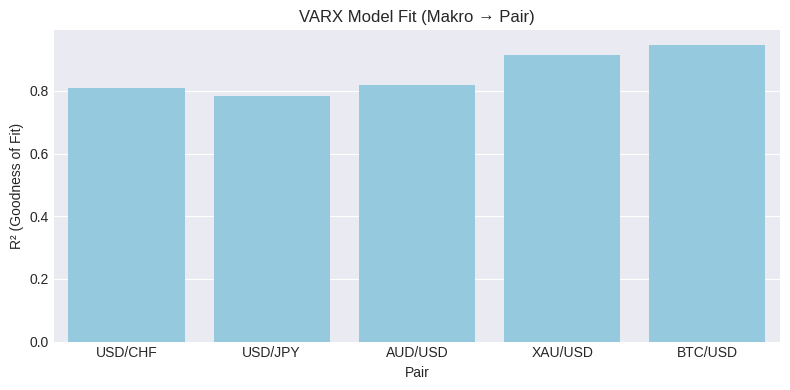

In [32]:
# cell_id: 445c9a16
# ============================================================
# 🧮 VARX: Makro → Pair (Implementasi)
# ============================================================
print("\n📈 Menjalankan model VARX (Makro → Pair)...")

varx_macro_results = []
fitted_models = {} # Store fitted models if needed later

# Define the macro series columns to test (use the keys from FRED_SERIES)
macro_series_cols = list(FRED_SERIES.keys())

# Iterate through each pair in base_dfs
for pair_name, pair_df_base in base_dfs.items():
    print(f"\n🧠 Membangun model VARX untuk pair: {pair_name}")
    # Align FRED data with the current pair's base data
    if fred_df is not None and not fred_df.empty:
        # Select FRED data within the pair's time range and ffill
        start_time = pair_df_base.index.min()
        end_time = pair_df_base.index.max()
        sub_fred = fred_df.loc[(fred_df.index >= start_time) & (fred_df.index <= end_time)].copy()
        sub_fred = sub_fred.reindex(pair_df_base.index, method="ffill")

        # Drop any macro columns that are all NaN in the sub_fred (no data in this period)
        sub_fred.dropna(axis=1, how='all', inplace=True)

        # Ensure only relevant macro columns are selected for exog
        cols_to_join = [col for col in macro_series_cols if col in sub_fred.columns]
        if not cols_to_join:
            print(f"⚠️ Tidak ada data FRED yang relevan untuk {pair_name} dalam rentang waktu ini. Melewati VARX.")
            continue

        # Combine pair data ("Close") with aligned FRED data (exog)
        df_combined_for_varx = pd.concat([pair_df_base[["Close"]], sub_fred[cols_to_join]], axis=1).dropna()

        if df_combined_for_varx.empty:
            print(f"⚠️ Data gabungan kosong after dropna for {pair_name}. Skipping VARX.")
            continue

        try:
            # Use the robust fit_varx_or_arx function
            # Pass the combined dataframe and specify endogenous and exogenous columns
            print(f"ℹ️ Attempting to fit model for {pair_name} with endog=['Close'] and exog={cols_to_join}")
            model_result = fit_varx_or_arx(
                df_pair=df_combined_for_varx,
                endog_cols=["Close"],
                exog_cols=cols_to_join,
                maxlags=maxlag_test # Use maxlag_test from parameters
            )

            varx_macro_results.append({
                "Pair": pair_name,
                "Model_Type": model_result["model_type"],
                "Lags_Used": model_result["lags_used"],
                "R2": model_result["R2"]
            })
            fitted_models[pair_name] = model_result # Store the result dictionary

            print(f"✅ Model {model_result['model_type']} for {pair_name} fitted successfully. R²={model_result['R2']:.4f}")
            # Optional: Print summary and plot fit/residuals for each model
            #print_varx_result_text(model_result, pair_name)
            #plot_varx_fit_and_resid(df_combined_for_varx, endog_col="Close", res_dict=model_result, exog_cols=cols_to_join)


        except Exception as e:
            print(f"⚠️ Model fitting for {pair_name} failed: {e}")
            varx_macro_results.append({"Pair": pair_name, "Model_Type": None, "Lags_Used": None, "R2": np.nan}) # Record NaN for failed fits

    else:
        print(f"⚠️ Tidak ada data FRED yang valid untuk diuji VARX dengan {pair_name}. Melewati VARX.")


varx_macro_df = pd.DataFrame(varx_macro_results)

if not varx_macro_df.empty:
    print("\n📋 Hasil Model VARX/ARX (Makro → Pair) R²:")
    display(varx_macro_df)
    # Optional: Plot the results
    # You might need to adapt plot_varx_macro_results or create a new one
    plot_varx_macro_results(varx_macro_df)
else:
    print("\nℹ️ Tidak ada hasil model VARX/ARX (Makro → Pair).")

In [33]:
# cell_id: generate_cells_2
# ============================================================
# 📊 Visualisasi Data Gabungan dan Residual Model VARX/ARX
# ============================================================

print("\n📊 Memvisualisasikan data gabungan dan residual model...")

# Pilih satu pair dengan R2 negatif untuk visualisasi
pair_to_plot = None
for pair, r2 in varx_macro_df.set_index("Pair")["R2"].items():
    if r2 < 0:
        pair_to_plot = pair
        break

if pair_to_plot and pair_to_plot in fitted_models:
    print(f"\n--- Visualisasi untuk {pair_to_plot} ---")

    # Dapatkan data gabungan yang digunakan untuk model
    # Reconstruct the combined data used for fitting
    pair_df_base = base_dfs.get(pair_to_plot)
    model_result = fitted_models[pair_to_plot]

    if pair_df_base is not None and fred_df is not None:
        start_time = pair_df_base.index.min()
        end_time = pair_df_base.index.max()
        sub_fred = fred_df.loc[(fred_df.index >= start_time) & (fred_df.index <= end_time)].copy()
        sub_fred = sub_fred.reindex(pair_df_base.index, method="ffill")
        sub_fred.dropna(axis=1, how='all', inplace=True) # Drop macro cols with no data

        cols_to_join = [col for col in FRED_SERIES.keys() if col in sub_fred.columns] # Use keys from FRED_SERIES
        if cols_to_join:
             df_combined_for_varx_plot = pd.concat([pair_df_base[["Close"]], sub_fred[cols_to_join]], axis=1).dropna()
        else:
            df_combined_for_varx_plot = pair_df_base[["Close"]].dropna() # Only Close if no macro data


        if not df_combined_for_varx_plot.empty:
            # Plot data gabungan (Close vs Macro)
            print(f"Plotting combined data for {pair_to_plot} (Shape: {df_combined_for_varx_plot.shape})")
            df_combined_for_varx_plot.plot(subplots=True, figsize=(12, len(df_combined_for_varx_plot.columns)*3))
            plt.suptitle(f"Combined Data: {pair_to_plot} (Close) vs Macro Series", y=1.02)
            plt.tight_layout()
            plt.show()

            # Plot actual vs fitted and residuals using the function defined earlier
            try:
                print(f"Plotting model fit and residuals for {pair_to_plot}")
                plot_varx_fit_and_resid(df_combined_for_varx_plot,
                                        endog_col="Close",
                                        res_dict=model_result,
                                        exog_cols=cols_to_join if cols_to_join else None)
            except Exception as e:
                 print(f"⚠️ Gagal plot fit/residuals untuk {pair_to_plot}: {e}")

        else:
            print(f"⚠️ Data gabungan kosong untuk plot {pair_to_plot}. Tidak bisa visualisasi.")
    else:
         print(f"⚠️ Data base atau FRED tidak tersedia untuk plot {pair_to_plot}. Tidak bisa visualisasi.")

else:
    print("\nℹ️ Tidak ada pair dengan R² negatif atau model yang terpasang untuk divisualisasikan.")

print("\n✅ Visualisasi selesai.")


📊 Memvisualisasikan data gabungan dan residual model...

ℹ️ Tidak ada pair dengan R² negatif atau model yang terpasang untuk divisualisasikan.

✅ Visualisasi selesai.


In [34]:
# cell_id: analyze_xauusd_btcbtc_models
# ============================================================
# 📊 Analisis Model VARX/ARX untuk XAU/USD dan BTC/USD
# ============================================================

print("\n🔬 Analisis Model untuk XAU/USD dan BTC/USD...")

pairs_to_analyze = ["XAU/USD", "BTC/USD", "USD/CHF", "USD/JPY", "AUD/USD"]

for pair_name in pairs_to_analyze:
    if pair_name in fitted_models:
        model_result = fitted_models[pair_name]
        print(f"\n--- Ringkasan Model untuk {pair_name} ({model_result['model_type']}) ---")
        print(f"R²: {model_result['R2']:.4f}")
        print(f"Lags Used: {model_result['lags_used']}")
        # Display the model summary
        print(model_result['summary'])
    else:
        print(f"\n⚠️ Model untuk {pair_name} tidak ditemukan dalam fitted_models.")

print("\n✅ Analisis model selesai.")


🔬 Analisis Model untuk XAU/USD dan BTC/USD...

--- Ringkasan Model untuk XAU/USD (SARIMAX(ARX)) ---
R²: 0.9154
Lags Used: 12
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  140
Model:              SARIMAX(12, 0, 0)   Log Likelihood                -714.266
Date:                Thu, 23 Oct 2025   AIC                           1470.531
Time:                        15:01:11   BIC                           1530.424
Sample:                             0   HQIC                          1494.866
                                - 140                                         
Covariance Type:                  opg                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Secured Overni


📊 Memplot ACF dan PACF residual model...

--- ACF/PACF Residuals untuk XAU/USD ---


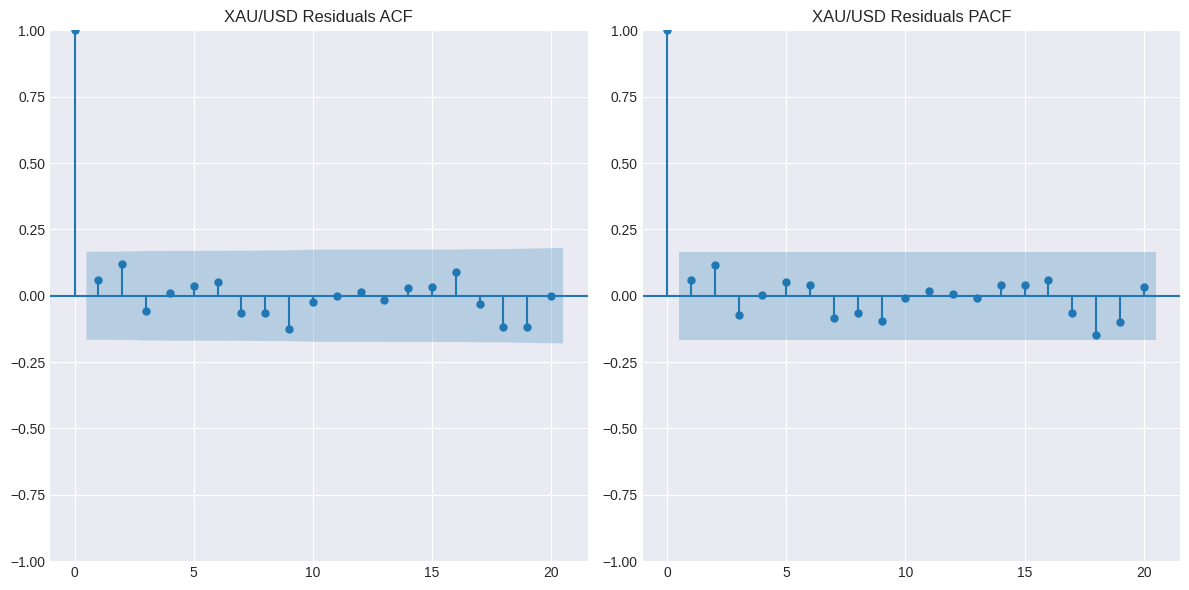


--- ACF/PACF Residuals untuk BTC/USD ---


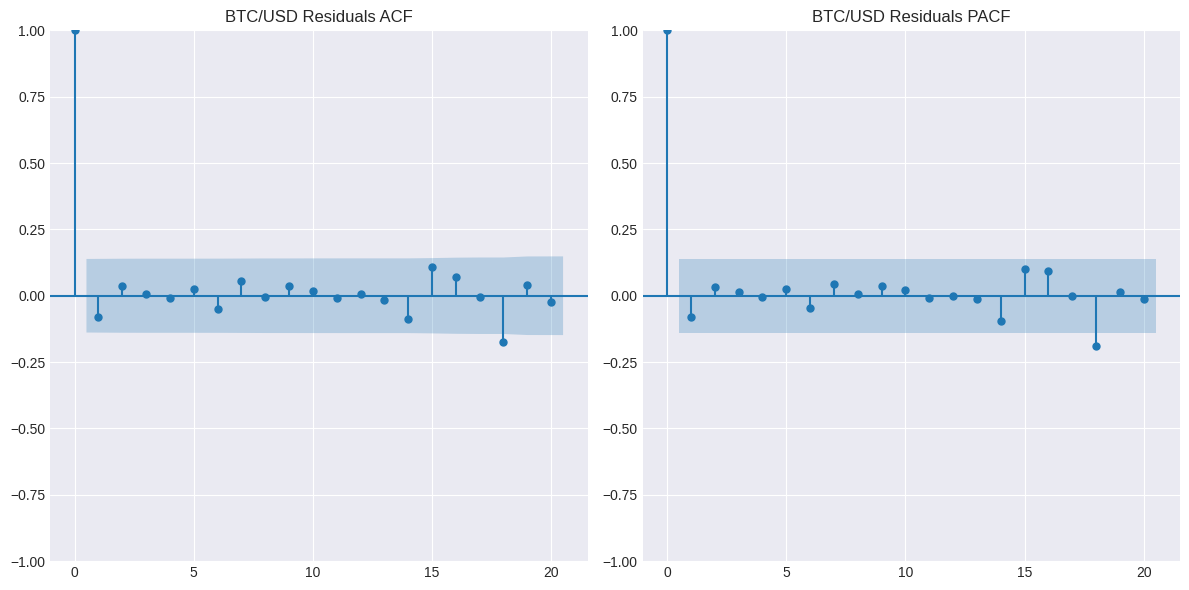


--- ACF/PACF Residuals untuk USD/CHF ---


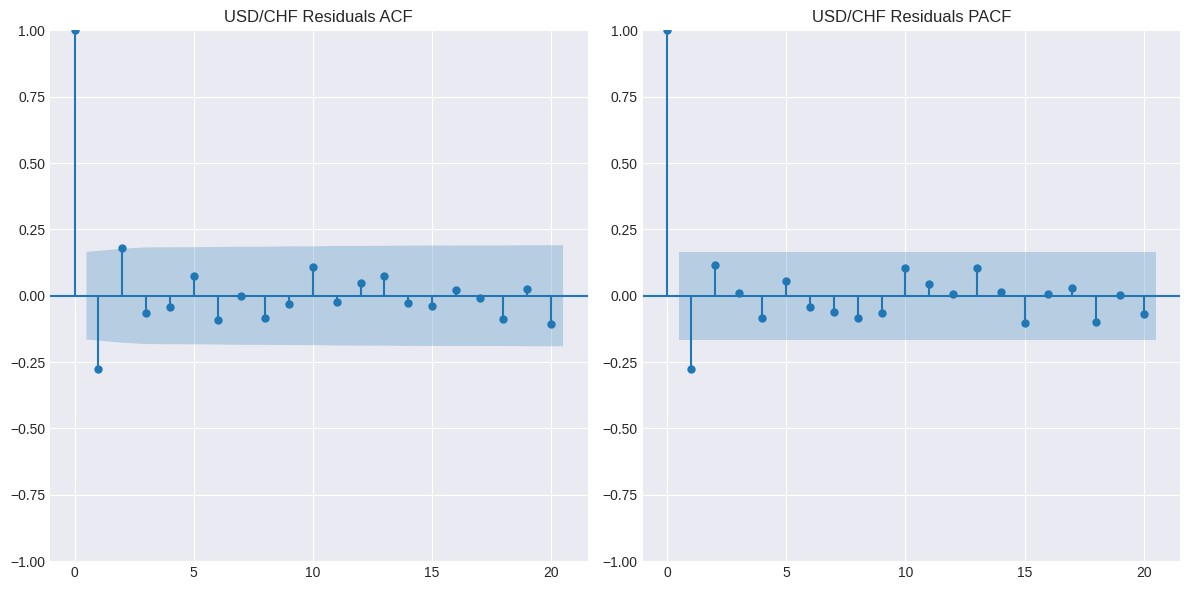


--- ACF/PACF Residuals untuk USD/JPY ---


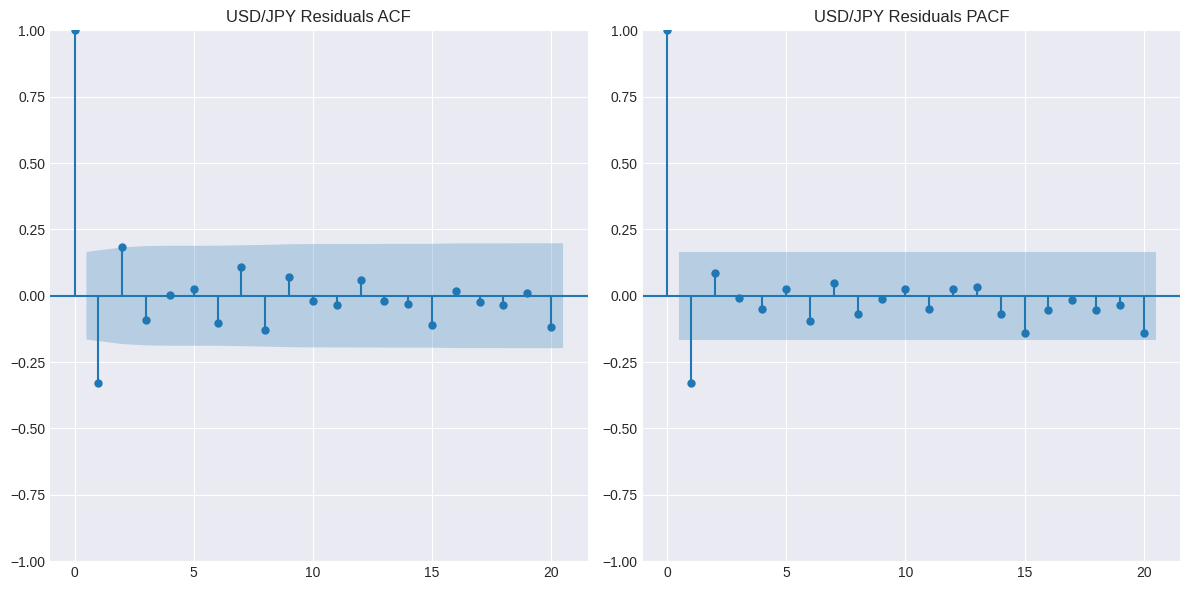


--- ACF/PACF Residuals untuk AUD/USD ---


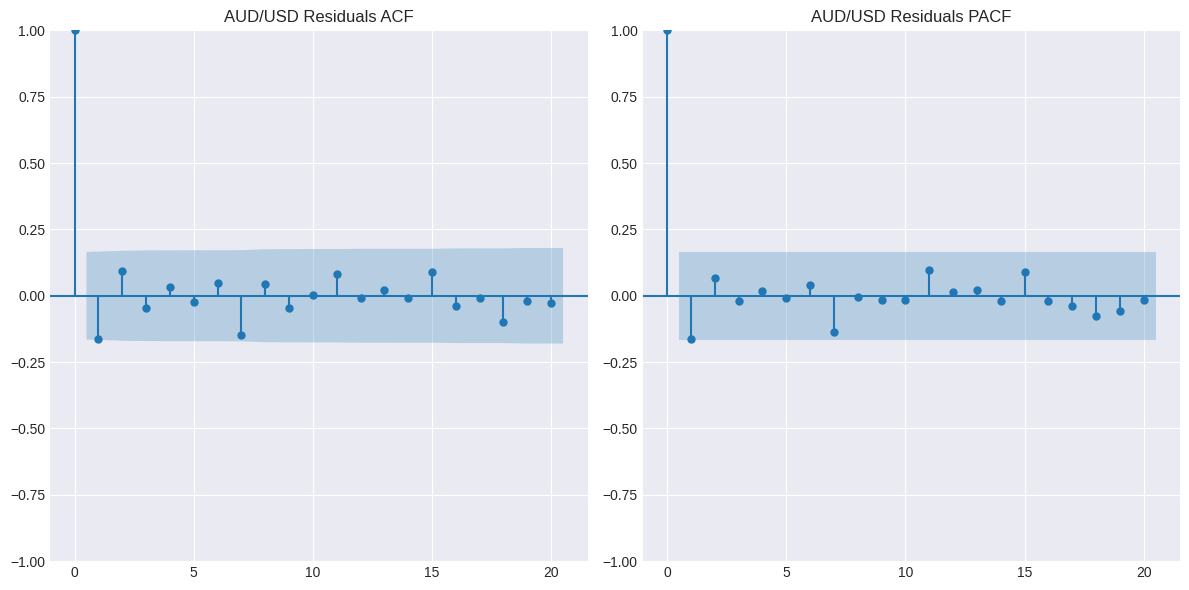


✅ Plotting residual ACF/PACF selesai.


In [35]:
# ============================================================
# 📉 Plot ACF dan PACF Residual Model
# ============================================================

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pairs_to_plot_residuals = ["XAU/USD", "BTC/USD", "USD/CHF", "USD/JPY","AUD/USD"]
max_lags_acf_pacf = 20 # Sesuaikan jumlah lag yang ingin ditampilkan

print("\n📊 Memplot ACF dan PACF residual model...")

for pair_name in pairs_to_plot_residuals:
    if pair_name in fitted_models:
        model_result = fitted_models[pair_name]
        if model_result and model_result["fitted_model"] is not None:
            residuals = model_result["fitted_model"].resid
            print(f"\n--- ACF/PACF Residuals untuk {pair_name} ---")

            plt.figure(figsize=(12, 6))
            plot_acf(residuals, lags=max_lags_acf_pacf, ax=plt.subplot(121), title=f'{pair_name} Residuals ACF')
            plot_pacf(residuals, lags=max_lags_acf_pacf, ax=plt.subplot(122), title=f'{pair_name} Residuals PACF')
            plt.tight_layout()
            plt.show()
        else:
            print(f"⚠️ Model terpasang tidak tersedia untuk {pair_name}.")
    else:
        print(f"⚠️ Model untuk {pair_name} tidak ditemukan dalam fitted_models.")

print("\n✅ Plotting residual ACF/PACF selesai.")

In [36]:
# cell_id: identify_significant_pair_granger_relationships
# ============================================================
# 🔍 Identifikasi Hubungan Granger Signifikan Antar Pair
# ============================================================

print("\n🔍 Mengidentifikasi hubungan Granger signifikan antar pair (p-value < alpha)...")

# Ensure pair_granger_df and alpha are available
if 'macro_granger_df' not in globals() or macro_granger_df.empty:
    print("⚠️ DataFrame hasil uji Granger Pair-Pair (pair_granger_df) tidak ditemukan atau kosong. Jalankan sel sebelumnya.")
    significant_pair_exog_map = {}
else:
    macro_granger_df['PValue'] = pd.to_numeric(macro_granger_df['PValue'], errors='coerce')
    # Filter for significant results based on alpha
    significant_results = macro_granger_df[macro_granger_df['PValue'] < alpha].copy()

    if significant_results.empty:
        print(f"ℹ️ Tidak ada hubungan Granger signifikan antar pair ditemukan pada alpha = {alpha}.")
        significant_pair_exog_map = {}
    else:
        print(f"✅ Ditemukan {len(significant_results)} hubungan Granger signifikan (p < {alpha}):")
        display(significant_results)

        # Create a map from target pair (Effect_Pair) to a list of significant exogenous pairs (Cause_Pair)
        significant_pair_exog_map = {}
        for index, row in significant_results.iterrows():
            effect_pair = row['Effect']
            cause_pair = row['Cause']

            if effect_pair not in significant_pair_exog_map:
                significant_pair_exog_map[effect] = []

            # Add the cause_pair as a potential exogenous variable for the effect_pair
            significant_pair_exog_map[effect].append(cause)

        print("\n📊 Peta Pair Target ke Pair Eksogen Signifikan (berdasarkan Granger):")
        if significant_pair_exog_map:
            for target_pair, exog_list in significant_pair_exog_map.items():
                print(f"  • {target_pair} dipengaruhi oleh (Granger cause): {exog_list}")
        else:
            print("ℹ️ Peta kosong.")


print("\n✅ Identifikasi hubungan signifikan selesai.")


🔍 Mengidentifikasi hubungan Granger signifikan antar pair (p-value < alpha)...
✅ Ditemukan 34 hubungan Granger signifikan (p < 0.05):


Relation     Pair                                              Cause  \
0   Macro -> Pair  USD/CHF                                            S&P 500   
1   Macro -> Pair  USD/CHF                  US Corporate Index Semi-Annual Yi   
2   Macro -> Pair  USD/CHF                                  Index Semi-Annual   
3   Macro -> Pair  USD/CHF                         Emerging Markets Corporate   
4   Macro -> Pair  USD/CHF                             Markets Corporate Plus   
5   Macro -> Pair  USD/CHF               Financial US Emerging Markets Liquiq   
6   Pair -> Macro  USD/CHF                                              Close   
7   Pair -> Macro  USD/CHF                                              Close   
8   Pair -> Macro  USD/CHF                                              Close   
9   Pair -> Macro  USD/CHF                                              Close   
10  Macro -> Pair  USD/JPY                                            S&P 500   
11  Macro -> Pair  USD/JPY                  US Corporate Index Semi-Annual Yi   
12  Macro -> Pair  USD/JPY                                  Index Semi-Annual   
13  Macro -> Pair  USD/JPY                         Emerging Markets Corporate   
14  Macro -> Pair  USD/JPY                             Markets Corporate Plus   
15  Macro -> Pair  USD/JPY               Financial US Emerging Markets Liquiq   
16  Pair -> Macro  USD/JPY                                              Close   
17  Pair -> Macro  USD/JPY                                              Close   
18  Macro -> Pair  AUD/USD                                            S&P 500   
19  Macro -> Pair  AUD/USD                  US Corporate Index Semi-Annual Yi   
20  Macro -> Pair  AUD/USD                                  Index Semi-Annual   
21  Macro -> Pair  AUD/USD  Daily Sterling Overnight Index Average (SONIA)...   
22  Pair -> Macro  AUD/USD                                              Close   
23  Pair -> Macro  AUD/USD                                              Close   
24  Pair -> Macro  AUD/USD                                              Close   
25  Pair -> Macro  AUD/USD                                              Close   
26  Macro -> Pair  XAU/USD                                            S&P 500   
27  Macro -> Pair  XAU/USD                                  Index Semi-Annual   
28  Pair -> Macro  XAU/USD                                              Close   
29  Pair -> Macro  XAU/USD                                              Close   
30  Macro -> Pair  BTC/USD                                            S&P 500   
31  Macro -> Pair  BTC/USD                                  Index Semi-Annual   
32  Pair -> Macro  BTC/USD                                              Close   
33  Pair -> Macro  BTC/USD                                              Close   

                                               Effect  Best_Lag  PValue  \
0                                               Close         1  0.0000   
1                                               Close         3  0.0000   
2                                               Close         6  0.0078   
3                                               Close         2  0.0000   
4                                               Close         1  0.0014   
5                                               Close         1  0.0000   
6                   US Corporate Index Semi-Annual Yi         8  0.0034   
7                          Emerging Markets Corporate         8  0.0086   
8                              Markets Corporate Plus         8  0.0324   
9                Financial US Emerging Markets Liquiq         8  0.0042   
10                                              Close         1  0.0017   
11                                              Close         1  0.0000   
12                                              Close         2  0.0017   
13                                              Close         1  0.0000   
14                                              


📊 Peta Pair Target ke Pair Eksogen Signifikan (berdasarkan Granger):
  • Daily Sterling Overnight Index Average (SONIA)... dipengaruhi oleh (Granger cause): ['Close']

✅ Identifikasi hubungan signifikan selesai.


In [37]:

# cell_id: auto_varx_forecast_best_model
# ============================================================
# 🤖 AUTO VARX/SARIMAX MODEL SELECTION & FORECASTING PIPELINE
# ============================================================
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

print("\n⚙️ Menjalankan Auto VARX/SARIMAX Model Selector + Forecast...")

auto_model_results = {}
auto_forecasts = {}
forecast_horizon = 2

for target in combined_log_returns_df.columns:
    print(f"\n🔍 Evaluating models for target: {target}")

    y = combined_log_returns_df[target].dropna()
    exog = None
    if target in significant_pair_exog_map:
        exog_names = significant_pair_exog_map[target]
        exog = pd.concat(
            [combined_log_returns_df[x] for x in exog_names if x in combined_log_returns_df],
            axis=1
        ).fillna(method='ffill').loc[y.index]

    candidate_models = []

    # 1️⃣ ARX/SARIMAX(1,0,0)
    try:
        sarimax_model = SARIMAX(y, order=(1, 0, 0), exog=exog, trend='c').fit(disp=False)
        preds = sarimax_model.fittedvalues
        r2 = r2_score(y.iloc[1:], preds.iloc[1:]) if len(preds) > 1 else np.nan
        candidate_models.append({
            'name': 'SARIMAX(1,0,0)',
            'model': sarimax_model,
            'aic': sarimax_model.aic,
            'bic': sarimax_model.bic,
            'r2': r2
        })
    except Exception as e:
        print(f"  -> Skip SARIMAX: {e}")

    # 2️⃣ VAR (multi-variable if exog available)
    try:
        if exog is not None and exog.shape[1] > 0:
            df_var = pd.concat([y, exog], axis=1).dropna()
        else:
            df_var = y.to_frame().dropna()
        model_var = VAR(df_var).fit(maxlags=2, ic='aic')
        preds = model_var.fittedvalues[y.name]
        r2 = r2_score(df_var[y.name].iloc[model_var.k_ar:], preds)
        candidate_models.append({
            'name': f"VAR(lag={model_var.k_ar})",
            'model': model_var,
            'aic': model_var.aic,
            'bic': model_var.bic,
            'r2': r2
        })
    except Exception as e:
        print(f"  -> Skip VAR: {e}")

    # 3️⃣ AR(1) baseline
    try:
        sarimax_ar1 = SARIMAX(y, order=(1, 0, 0), trend='c').fit(disp=False)
        preds = sarimax_ar1.fittedvalues
        r2 = r2_score(y.iloc[1:], preds.iloc[1:])
        candidate_models.append({
            'name': 'AR(1)',
            'model': sarimax_ar1,
            'aic': sarimax_ar1.aic,
            'bic': sarimax_ar1.bic,
            'r2': r2
        })
    except Exception as e:
        print(f"  -> Skip AR(1): {e}")

    # 🔎 Pilih model terbaik
    if len(candidate_models) == 0:
        print(f"  -> Tidak ada model yang valid untuk {target}")
        continue

    best_model = sorted(candidate_models, key=lambda x: (x['aic'], -x['r2']))[0]
    print(f"  ✅ Best model for {target}: {best_model['name']} | AIC={best_model['aic']:.2f}, R²={best_model['r2']:.4f}")

    model = best_model['model']
    auto_model_results[target] = best_model

    # 🔮 Forecast 20 langkah ke depan
    # 🔮 Forecast 20 langkah ke depan (REPLACEMENT BLOCK)
    try:
        # prepare future datetime index
        last_time = y.index[-1] if isinstance(y.index, pd.DatetimeIndex) else pd.Timestamp.today()
        # try to infer freq from y.index
        inferred = pd.infer_freq(y.index)
        freq_to_use = inferred if inferred is not None else 'D'
        future_index = pd.date_range(start=last_time + pd.tseries.frequencies.to_offset(freq_to_use),
                                     periods=forecast_horizon, freq=freq_to_use)

        # 1) VARResults-like (has .forecast and .k_ar)
        if hasattr(model, 'forecast') and hasattr(model, 'k_ar') and not isinstance(model, SARIMAX):
            # df_var must be defined earlier in this scope (from VAR fitting)
            try:
                lagged = df_var.values[-model.k_ar:]
                forecast_vals = model.forecast(y=lagged, steps=forecast_horizon)
                # first column is target
                forecast_series = forecast_vals[:, 0]
                forecast_df = pd.DataFrame(forecast_series, index=future_index, columns=[target])
                auto_forecasts[target] = forecast_df
                print(f"  -> OK (VAR): forecast shape {forecast_df.shape}")
                continue
            except Exception as e_var:
                # fallback to persistence below
                if verbose:
                    print(f"  -> VAR forecast attempt failed: {e_var}")

        # 2) SARIMAX / SARIMAXResults or other state-space with exog handling
        future_exog = None
        # if model remembers exog (k_exog > 0), try to construct future_exog
        k_exog = None
        try:
            k_exog = int(getattr(model.model, 'k_exog', 0))
        except Exception:
            k_exog = 0

        if k_exog and k_exog > 0:
            # Try to build future_exog from 'exog' variable (from earlier), or from final_stationarized_fred_data
            if exog is not None and isinstance(exog, (pd.DataFrame, pd.Series)):
                # take last row(s) of exog aligned to y
                last_exog_row = exog.loc[y.index].iloc[-1:]
                # repeat
                future_exog = pd.DataFrame(np.repeat(last_exog_row.values, forecast_horizon, axis=0),
                                          columns=last_exog_row.columns, index=future_index)
            else:
                # try to pull by model.model.exog_names from final_stationarized_fred_data
                exog_names = getattr(model.model, 'exog_names', None) or []
                if exog_names:
                    exog_dict = {}
                    for exn in exog_names:
                        # find series in final_stationarized_fred_data
                        found = False
                        for kf, df_f in final_stationarized_fred_data.items():
                            if exn in df_f.columns:
                                exog_dict[exn] = df_f[exn].iloc[-1]
                                found = True
                                break
                        if not found:
                            # fallback 0
                            exog_dict[exn] = 0.0
                    future_exog = pd.DataFrame([exog_dict] * forecast_horizon, index=future_index)
                else:
                    # if nothing found, build zeros
                    future_exog = pd.DataFrame(np.zeros((forecast_horizon, k_exog)),
                                               index=future_index,
                                               columns=[f'exog{i}' for i in range(k_exog)])

        # Now try to forecast using model's best available method
        try:
            if hasattr(model, 'get_forecast'):
                # prefer get_forecast
                if future_exog is not None:
                    res = model.get_forecast(steps=forecast_horizon, exog=future_exog)
                else:
                    res = model.get_forecast(steps=forecast_horizon)
                pm = getattr(res, 'predicted_mean', None)
                if pm is None:
                    # fallback to summary_frame mean column
                    try:
                        sf = res.summary_frame()
                        # find mean column(s)
                        mean_cols = [c for c in sf.columns if 'mean' in str(c).lower()]
                        if mean_cols:
                            pm = sf[mean_cols[0]]
                        else:
                            pm = sf.iloc[:, 0]
                    except Exception:
                        pm = None
                if pm is not None:
                    # ensure shape -> DataFrame with index future_index
                    pred_df = pd.DataFrame(pm)
                    pred_df.index = future_index[:len(pred_df)]
                    pred_df.columns = [target] if pred_df.shape[1] == 1 else list(range(pred_df.shape[1]))
                    forecast_df = pred_df
                    auto_forecasts[target] = forecast_df
                    print(f"  -> OK (get_forecast): forecast shape {forecast_df.shape}")
                    continue
            # fallback: try predict with start/end
            if hasattr(model, 'predict'):
                try:
                    start_idx = len(y)
                    end_idx = len(y) + forecast_horizon - 1
                    if future_exog is not None:
                        raw = model.predict(start=start_idx, end=end_idx, exog=future_exog)
                    else:
                        raw = model.predict(start=start_idx, end=end_idx)
                    forecast_df = pd.DataFrame(raw, index=future_index, columns=[target]) if np.ndim(raw) == 1 else pd.DataFrame(raw, index=future_index)
                    auto_forecasts[target] = forecast_df
                    print(f"  -> OK (predict): forecast shape {forecast_df.shape}")
                    continue
                except Exception as e_pred:
                    if verbose:
                        print(f"  -> predict() attempt failed: {e_pred}")

        except Exception as e_getf:
            if verbose:
                print(f"  -> get_forecast/predict block error: {e_getf}")

        # If reached here, forecasting attempts failed -> fallback persistence
        last_val = y.iloc[-1]
        forecast_df = pd.DataFrame(np.repeat(last_val, forecast_horizon), index=future_index, columns=[target])
        auto_forecasts[target] = forecast_df
        print(f"  ⚠️ Forecast fallback persistence used: shape {forecast_df.shape}")

    except Exception as e:
        print(f"  ⚠️ Forecast failed, fallback persistence: {e}")
        # absolute fallback
        future_index = pd.date_range(start=pd.Timestamp.today(), periods=forecast_horizon, freq='D')
        last_val = y.iloc[-1]
        forecast_df = pd.DataFrame(np.repeat(last_val, forecast_horizon), index=future_index, columns=[target])
        auto_forecasts[target] = forecast_df


⚙️ Menjalankan Auto VARX/SARIMAX Model Selector + Forecast...

🔍 Evaluating models for target: USD/CHF
  -> Skip VAR: Only gave one variable to VAR
  ✅ Best model for USD/CHF: SARIMAX(1,0,0) | AIC=-1409.06, R²=0.1423
  -> OK (get_forecast): forecast shape (2, 1)

🔍 Evaluating models for target: USD/JPY
  -> Skip VAR: Only gave one variable to VAR
  ✅ Best model for USD/JPY: SARIMAX(1,0,0) | AIC=-1408.21, R²=0.1040
  -> OK (get_forecast): forecast shape (2, 1)

🔍 Evaluating models for target: AUD/USD
  -> Skip VAR: Only gave one variable to VAR
  ✅ Best model for AUD/USD: SARIMAX(1,0,0) | AIC=-1509.28, R²=0.0645
  -> OK (get_forecast): forecast shape (2, 1)

🔍 Evaluating models for target: XAU/USD
  -> Skip VAR: Only gave one variable to VAR
  ✅ Best model for XAU/USD: SARIMAX(1,0,0) | AIC=-1140.59, R²=0.0166
  -> OK (get_forecast): forecast shape (2, 1)

🔍 Evaluating models for target: BTC/USD
  -> Skip VAR: Only gave one variable to VAR
  ✅ Best model for BTC/USD: SARIMAX(1,0,0) | AI

In [38]:
# cell_id: combine_log_returns
# ============================================================
# 🔄 Gabungkan semua log return harga ke dalam satu DataFrame
# ============================================================

print("\n🔄 Menggabungkan semua log return harga...")

combined_log_returns_df = pd.DataFrame()

if 'log_return_dfs' in globals() and log_return_dfs:
    first_pair = True
    for pair_name, df_log_return in log_return_dfs.items():
        if df_log_return is not None and not df_log_return.empty and 'Log_Return' in df_log_return.columns:
            # Rename the Log_Return column to the pair name
            df_renamed = df_log_return.rename(columns={'Log_Return': pair_name})

            if first_pair:
                combined_log_returns_df = df_renamed.copy()
                first_pair = False
            else:
                # Merge with the combined DataFrame based on index (datetime)
                combined_log_returns_df = combined_log_returns_df.merge(
                    df_renamed,
                    left_index=True,
                    right_index=True,
                    how='outer' # Use outer merge to keep all dates
                )
        else:
            print(f"⚠️ Log return data tidak valid atau kosong untuk {pair_name}. Dilewati penggabungan.")

    # Forward fill any NaNs introduced by the outer merge
    combined_log_returns_df = combined_log_returns_df.ffill()

    print(f"✅ Log return harga berhasil digabung. Shape: {combined_log_returns_df.shape}")
    display(combined_log_returns_df.head())
    display(combined_log_returns_df.tail())

else:
    print("⚠️ Variabel 'log_return_dfs' tidak ditemukan atau kosong. Jalankan sel 'apply_log_return_to_price' terlebih dahulu.")

print("\n✅ Proses penggabungan log return selesai.")


🔄 Menggabungkan semua log return harga...
✅ Log return harga berhasil digabung. Shape: (200, 5)


USD/CHF   USD/JPY   AUD/USD   XAU/USD   BTC/USD
Date                                                                       
2025-04-07 00:00:00+00:00       NaN       NaN       NaN       NaN  0.012968
2025-04-08 00:00:00+00:00  0.009466  0.016070  0.001654  0.005777 -0.038117
2025-04-09 00:00:00+00:00 -0.016478 -0.013241 -0.007082  0.029247  0.079389
2025-04-10 00:00:00+00:00  0.011510  0.010599  0.029505  0.031781 -0.036352
2025-04-11 00:00:00+00:00 -0.041397 -0.025088  0.014531  0.021012  0.046364

USD/CHF   USD/JPY   AUD/USD   XAU/USD   BTC/USD
Date                                                                       
2025-10-19 00:00:00+00:00 -0.005943 -0.005673 -0.003942 -0.021323  0.013605
2025-10-20 00:00:00+00:00  0.002220  0.005182  0.002973  0.034368  0.017534
2025-10-21 00:00:00+00:00 -0.001501 -0.000835  0.002245 -0.059062 -0.019283
2025-10-22 00:00:00+00:00  0.005412  0.007394 -0.003753 -0.010649 -0.007294
2025-10-23 00:00:00+00:00  0.005412  0.007394 -0.003753  0.029287  0.016440


✅ Proses penggabungan log return selesai.



✅ Forecast dictionary siap untuk plotting: 5 targets.


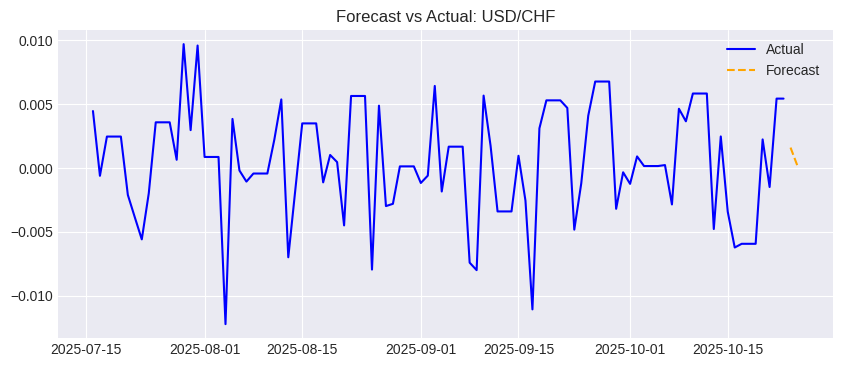

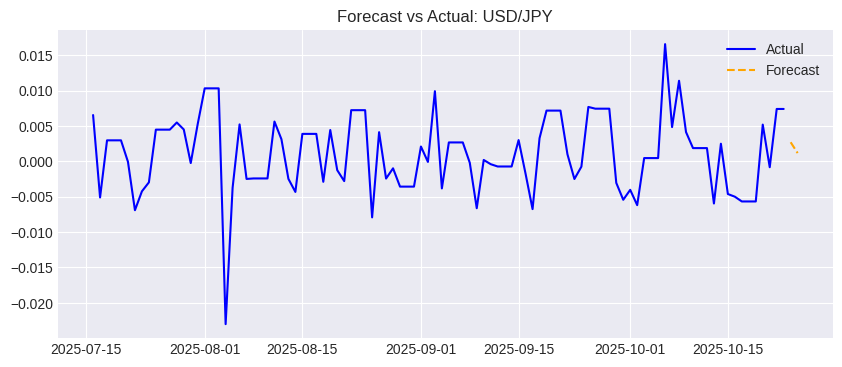

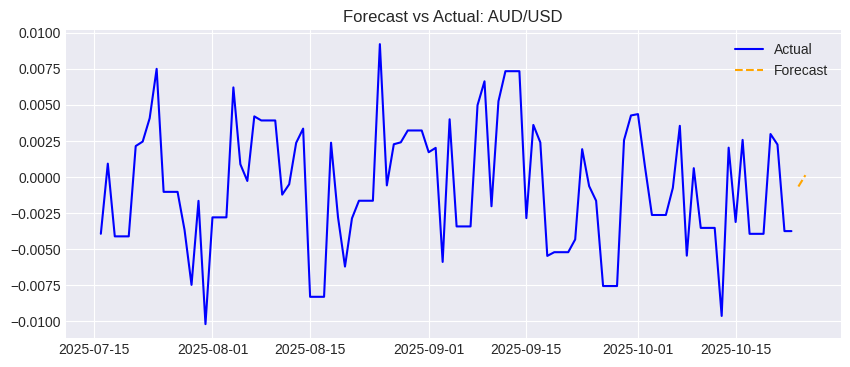

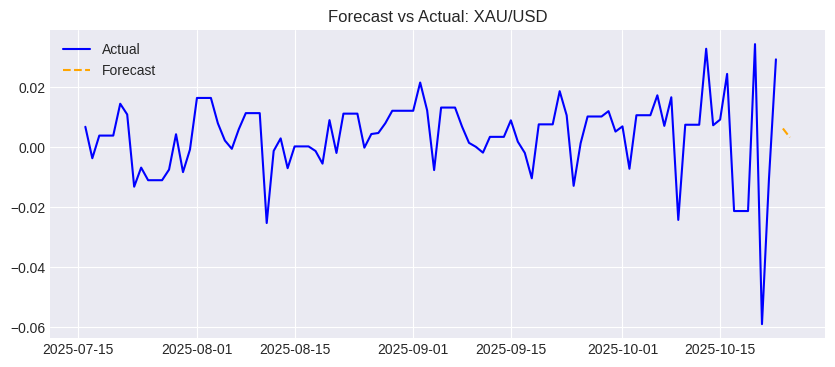

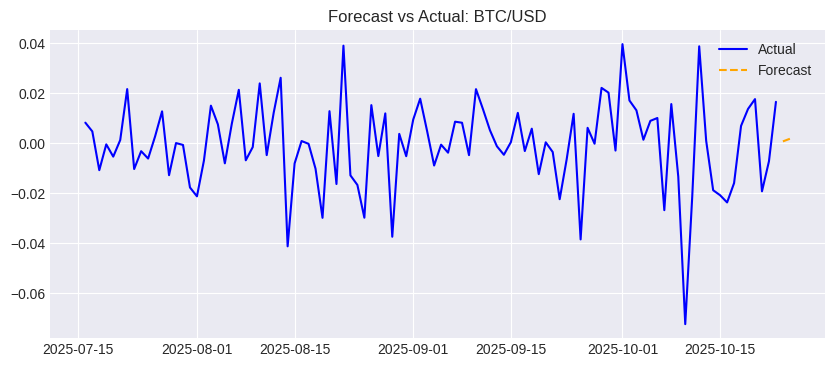

In [39]:

# ============================================================
# 🗃️ Konversi hasil auto_forecasts ke format universal untuk plotting
# ============================================================

forecasts = {}
for target in auto_forecasts:
    try:
        forecasts[target] = {
            "actual": combined_log_returns_df[target].dropna(),
            "forecast": auto_forecasts[target]
        }
    except Exception as e:
        print(f"⚠️ Gagal siapkan forecast untuk {target}: {e}")

print(f"\n✅ Forecast dictionary siap untuk plotting: {len(forecasts)} targets.")


for pair_name, result in forecasts.items():
    actual = result.get("actual")
    forecast = result.get("forecast")

    if forecast is None or forecast.empty:
        print(f"⚠️ Skip plot: {pair_name} (forecast kosong)")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(actual[-100:], label="Actual", color="blue")
    plt.plot(forecast, label="Forecast", color="orange", linestyle="--")
    plt.title(f"Forecast vs Actual: {pair_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

✅ Restored forecast untuk USD/CHF: 2 langkah
✅ Restored forecast untuk USD/JPY: 2 langkah
✅ Restored forecast untuk AUD/USD: 2 langkah
✅ Restored forecast untuk XAU/USD: 2 langkah
✅ Restored forecast untuk BTC/USD: 2 langkah

🎯 Semua hasil forecast berhasil dikembalikan ke bentuk harga asli.


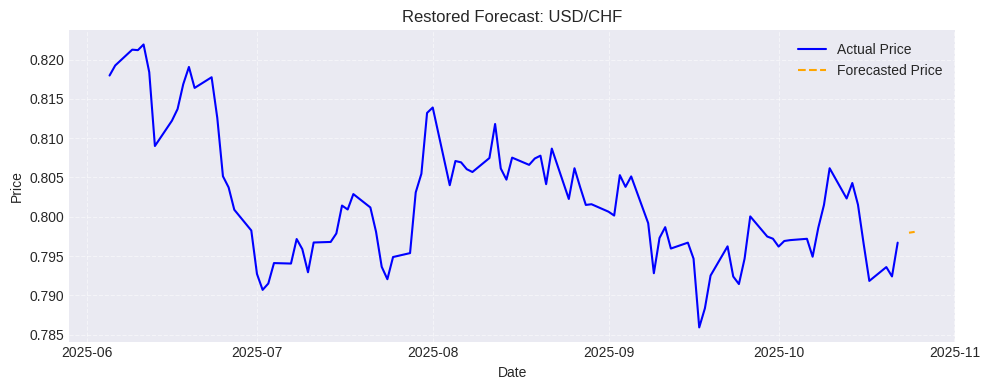

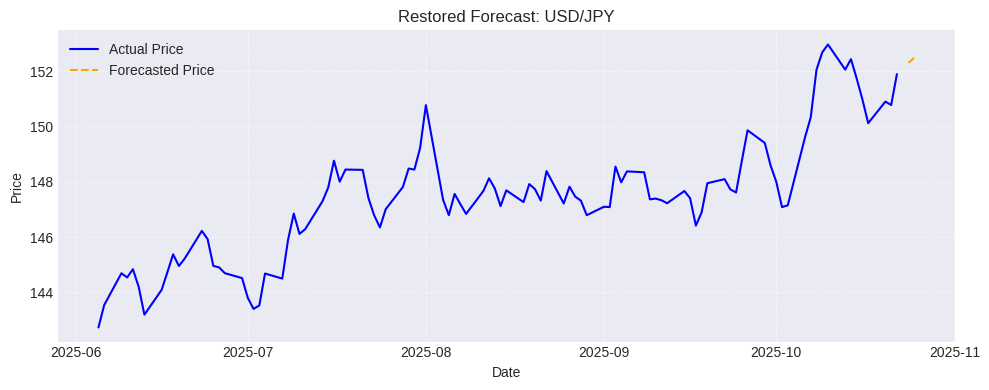

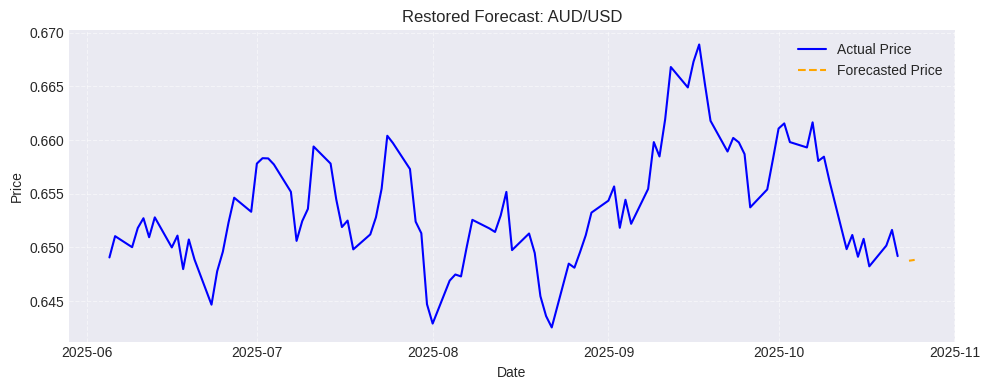

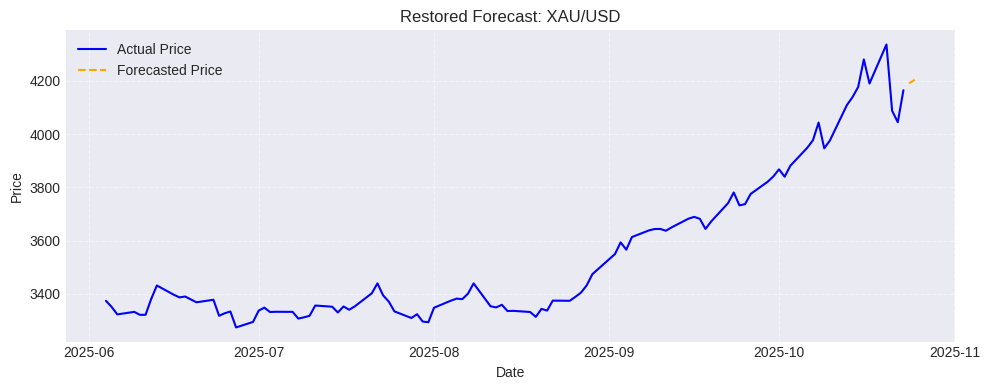

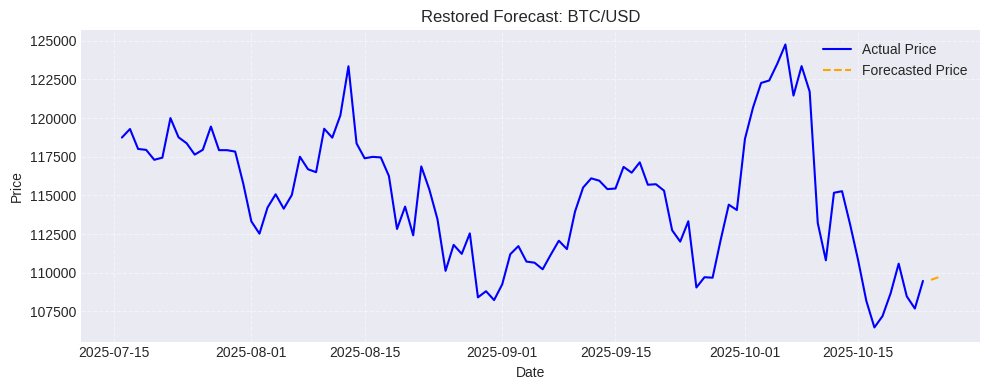

In [40]:

# ============================================================
# 🔁 Konversi Forecast (Stasioner → Skala Asli Harga)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

restored_forecasts = {}

for pair_name, forecast_df in auto_forecasts.items():
    if forecast_df is None or forecast_df.empty:
        print(f"⚠️ Skip restore: {pair_name} (forecast kosong)")
        continue

    # Ambil harga terakhir aktual
    if pair_name not in base_dfs or base_dfs[pair_name].empty:
        print(f"⚠️ Skip restore: {pair_name} (base_dfs kosong)")
        continue

    # Ambil harga terakhir aktual dari base_dfs
    last_actual_price = base_dfs[pair_name].iloc[-1, 0]

    # Ambil kolom pertama dari forecast_df (tanpa asumsi nama kolom)
    col_name = forecast_df.columns[0]
    forecast_returns = forecast_df[col_name]

    # Ubah log-return forecast menjadi harga prediksi
    restored_prices = [last_actual_price]
    for ret in forecast_returns:
        next_price = restored_prices[-1] * np.exp(ret)
        restored_prices.append(next_price)

    restored_series = pd.Series(
        restored_prices[1:],  # buang nilai awal (harga terakhir)
        index=forecast_df.index,
        name="forecast_price"
    )

    restored_forecasts[pair_name] = restored_series.to_frame()
    print(f"✅ Restored forecast untuk {pair_name}: {len(restored_series)} langkah")

print("\n🎯 Semua hasil forecast berhasil dikembalikan ke bentuk harga asli.")

#PLOTINNG
# ============================================================
# 📈 Plot hasil restore (harga aktual vs prediksi)
# ============================================================
for pair_name in restored_forecasts.keys():
    if pair_name not in base_dfs or base_dfs[pair_name].empty:
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(base_dfs[pair_name].iloc[-100:, 0], label="Actual Price", color="blue")
    plt.plot(restored_forecasts[pair_name], label="Forecasted Price", color="orange", linestyle="--")
    plt.title(f"Restored Forecast: {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

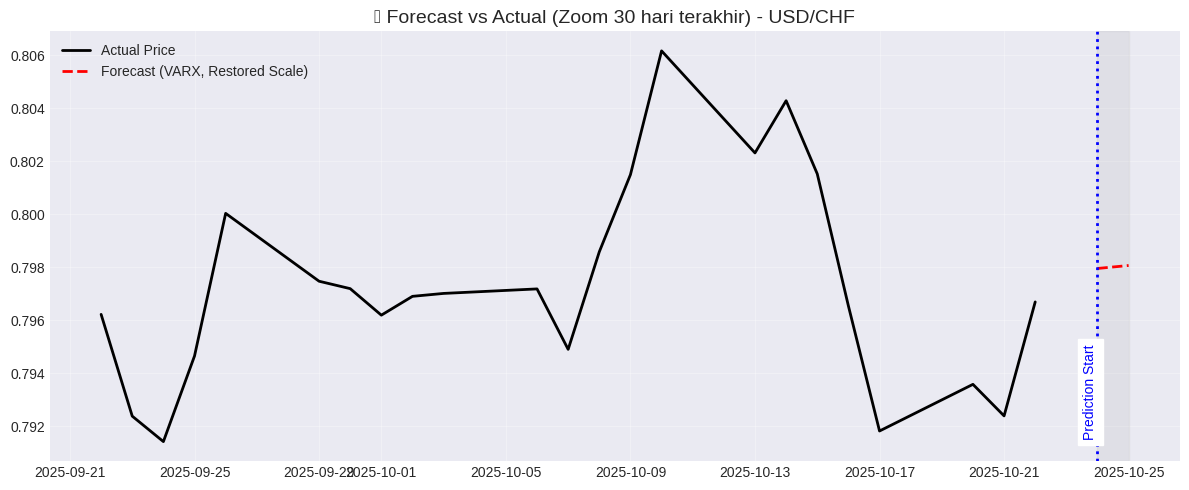

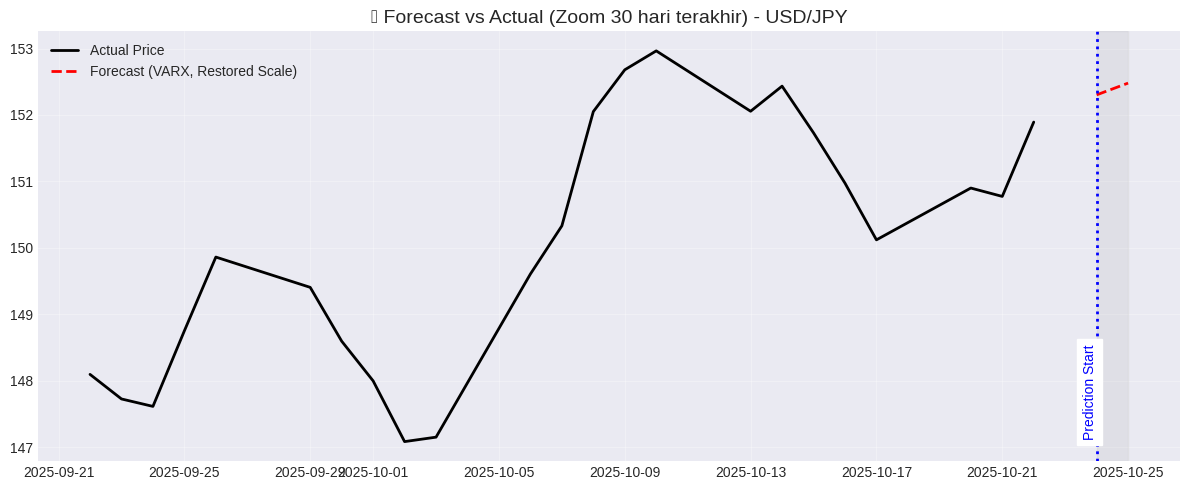

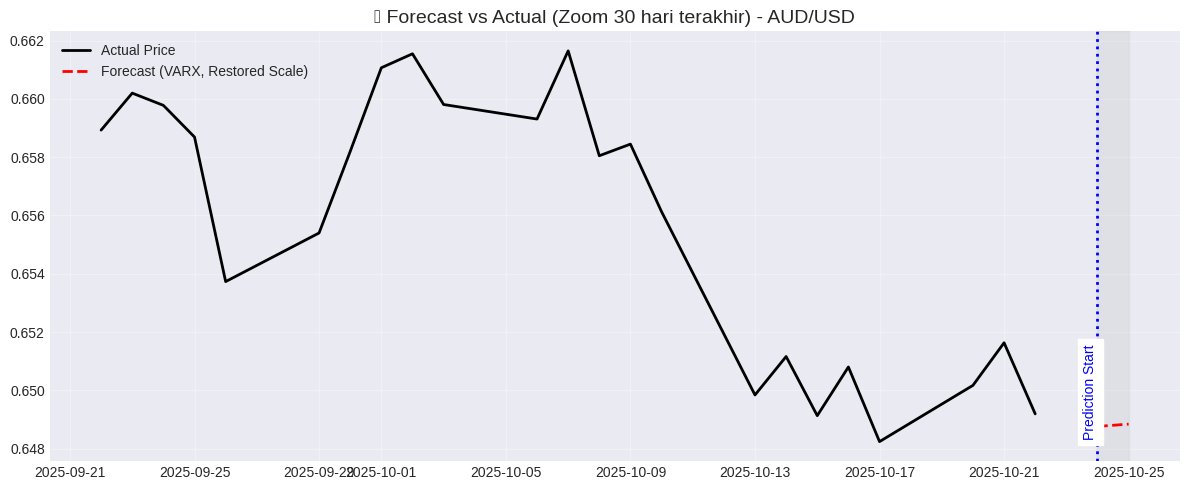

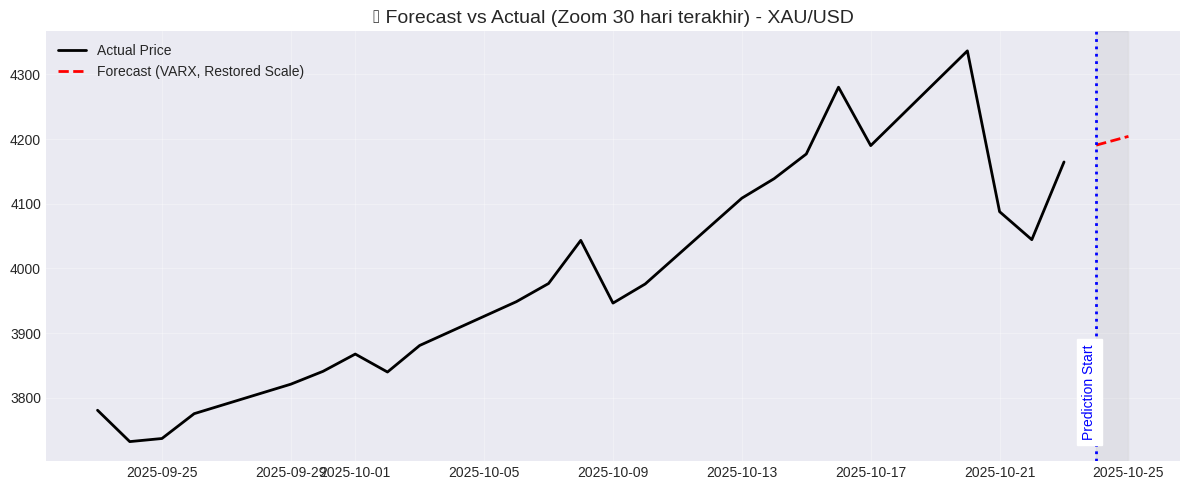

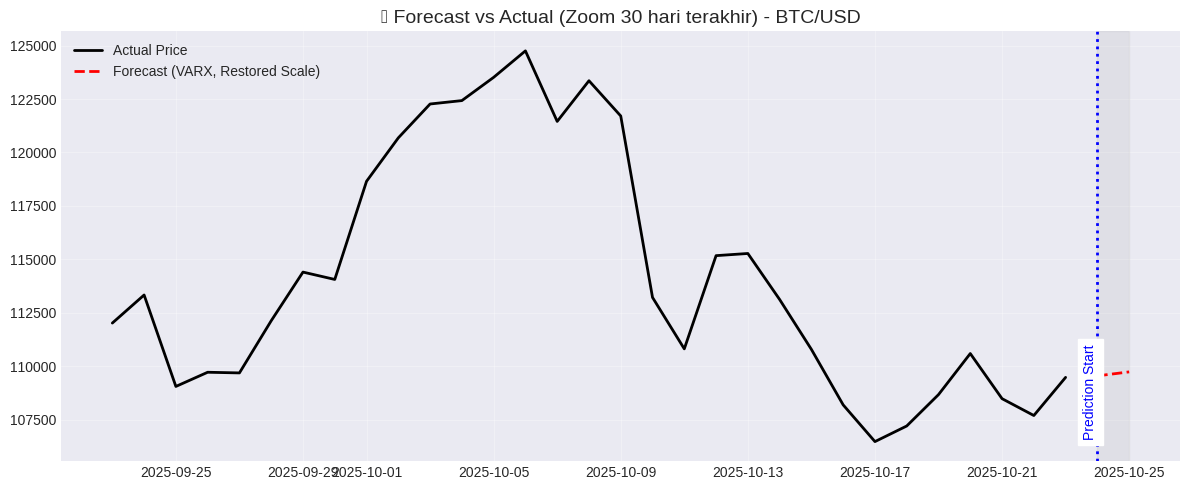

In [41]:
# ============================================================
# 📦 Integrasi Prediksi (restored_forecasts) dengan Data Aktual (base_dfs)
# ============================================================
import matplotlib.pyplot as plt
import pandas as pd

def build_macro_varx_predictions(restored_forecasts, base_dfs):
    macro_varx_predictions = {}

    for pair, forecast_df in restored_forecasts.items():
        if not isinstance(forecast_df, pd.DataFrame) or forecast_df.empty:
            continue

        # Ambil kolom pertama dari forecast_df
        forecast_series = forecast_df.iloc[:, 0]

        # --- Ambil data aktual dari base_dfs ---
        if isinstance(base_dfs, dict) and pair in base_dfs:
            actual_df = base_dfs[pair]
        elif isinstance(base_dfs, pd.DataFrame) and pair in base_dfs.columns:
            actual_df = base_dfs[[pair]]
        else:
            continue

        # Ambil kolom pertama dari actual_df juga
        actual_series = actual_df.iloc[:, 0]

        # Simpan keduanya
        macro_varx_predictions[pair] = {
            "forecast": forecast_series,
            "actual": actual_series
        }

    return macro_varx_predictions


# ============================================================
# 📊 Fungsi Plot dengan Penanda Prediksi
# ============================================================
def plot_macro_varx_predictions(macro_varx_predictions, days_back=30):
    for pair, data in macro_varx_predictions.items():
        forecast = data.get("forecast")
        actual = data.get("actual")

        if forecast is None or actual is None:
            continue

        # Pastikan index bertipe datetime
        if not isinstance(actual.index, pd.DatetimeIndex):
            actual.index = pd.to_datetime(actual.index)
        if not isinstance(forecast.index, pd.DatetimeIndex):
            forecast.index = pd.to_datetime(forecast.index)

        # Tentukan waktu mulai prediksi
        prediction_start = forecast.index.min()

        # Ambil subset waktu terakhir
        last_date = actual.index.max()
        start_date = last_date - pd.Timedelta(days=days_back)
        actual_zoom = actual.loc[actual.index >= start_date]
        forecast_zoom = forecast.loc[forecast.index >= start_date]

        # Plot
        plt.figure(figsize=(12, 5))
        plt.title(f"📈 Forecast vs Actual (Zoom {days_back} hari terakhir) - {pair}", fontsize=14)
        plt.plot(actual_zoom, label="Actual Price", color="black", linewidth=2)
        plt.plot(forecast_zoom, label="Forecast (VARX, Restored Scale)", color="red", linestyle="--", linewidth=2)

        # Garis vertikal menunjukkan waktu mulai prediksi
        if prediction_start >= start_date:
            plt.axvline(prediction_start, color="blue", linestyle=":", linewidth=2)
            plt.text(
                prediction_start,
                plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]),
                "Prediction Start",
                color="blue",
                fontsize=10,
                rotation=90,
                va="bottom",
                ha="right",
                backgroundcolor="white"
            )

        # Area abu-abu untuk periode prediksi
        plt.axvspan(prediction_start, forecast.index.max(), color="gray", alpha=0.1)

        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()


# ============================================================
# 🚀 Eksekusi
# ============================================================
macro_varx_predictions = build_macro_varx_predictions(
    restored_forecasts=restored_forecasts,
    base_dfs=base_dfs
)

plot_macro_varx_predictions(macro_varx_predictions, days_back=30)


✅ Restored forecast untuk USD/CHF: 2 langkah
✅ Restored forecast untuk USD/JPY: 2 langkah
✅ Restored forecast untuk AUD/USD: 2 langkah
✅ Restored forecast untuk XAU/USD: 2 langkah
✅ Restored forecast untuk BTC/USD: 2 langkah

🎯 Semua hasil forecast berhasil dikembalikan ke bentuk harga asli.


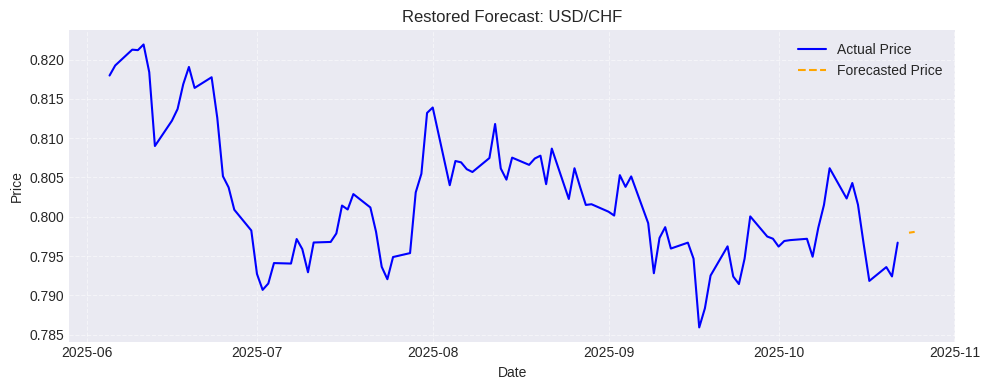

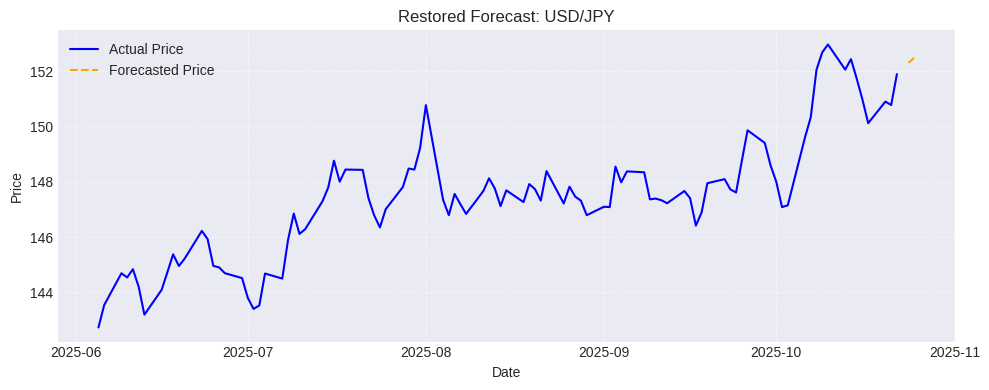

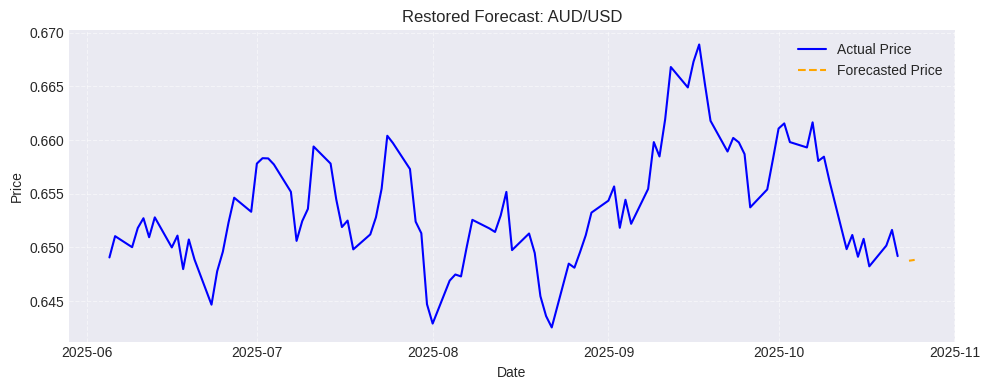

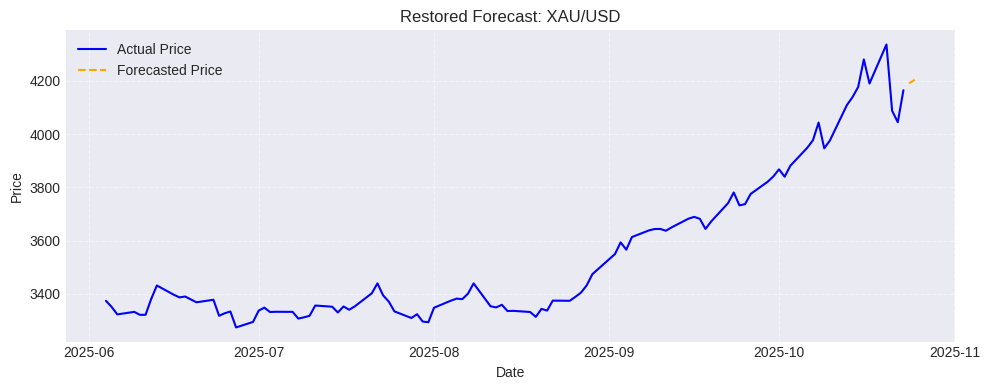

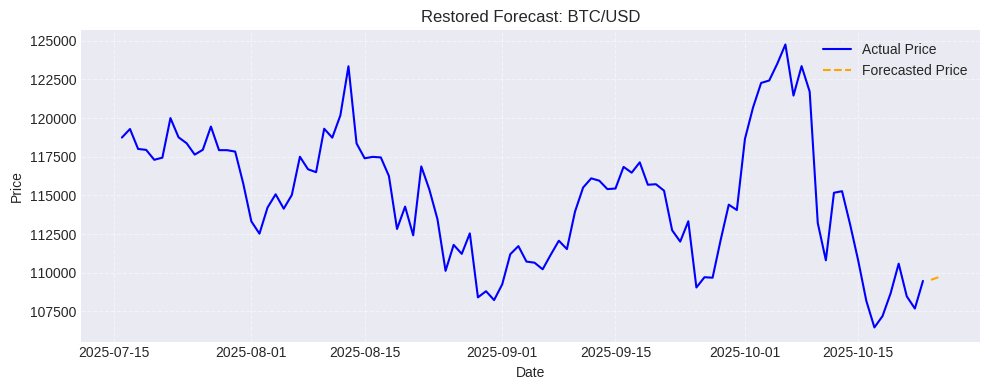

In [42]:

# ============================================================
# 🔁 Konversi Forecast (Stasioner → Skala Asli Harga)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

restored_forecasts = {}

for pair_name, forecast_df in auto_forecasts.items():
    if forecast_df is None or forecast_df.empty:
        print(f"⚠️ Skip restore: {pair_name} (forecast kosong)")
        continue

    # Ambil harga terakhir aktual
    if pair_name not in base_dfs or base_dfs[pair_name].empty:
        print(f"⚠️ Skip restore: {pair_name} (base_dfs kosong)")
        continue

    # Ambil harga terakhir aktual dari base_dfs
    last_actual_price = base_dfs[pair_name].iloc[-1, 0]

    # Ambil kolom pertama dari forecast_df (tanpa asumsi nama kolom)
    col_name = forecast_df.columns[0]
    forecast_returns = forecast_df[col_name]

    # Ubah log-return forecast menjadi harga prediksi
    restored_prices = [last_actual_price]
    for ret in forecast_returns:
        next_price = restored_prices[-1] * np.exp(ret)
        restored_prices.append(next_price)

    restored_series = pd.Series(
        restored_prices[1:],  # buang nilai awal (harga terakhir)
        index=forecast_df.index,
        name="forecast_price"
    )

    restored_forecasts[pair_name] = restored_series.to_frame()
    print(f"✅ Restored forecast untuk {pair_name}: {len(restored_series)} langkah")

print("\n🎯 Semua hasil forecast berhasil dikembalikan ke bentuk harga asli.")

#PLOTINNG
# ============================================================
# 📈 Plot hasil restore (harga aktual vs prediksi)
# ============================================================
for pair_name in restored_forecasts.keys():
    if pair_name not in base_dfs or base_dfs[pair_name].empty:
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(base_dfs[pair_name].iloc[-100:, 0], label="Actual Price", color="blue")
    plt.plot(restored_forecasts[pair_name], label="Forecasted Price", color="orange", linestyle="--")
    plt.title(f"Restored Forecast: {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [43]:
# Identify and list the global variables containing important results

important_variables = {}

# Data variables
if 'base_dfs' in globals():
    important_variables['base_dfs'] = 'DataFrames containing base price data for each pair.'
if 'fred_df' in globals():
    important_variables['fred_df'] = 'DataFrame containing raw FRED data.'
if 'transformed_fred_data' in globals():
    important_variables['transformed_fred_data'] = 'Dictionary of DataFrames with initially transformed FRED data.'
if 'final_stationarized_fred_data' in globals():
    important_variables['final_stationarized_fred_data'] = 'Dictionary of DataFrames with final stationarized FRED data.'
if 'log_return_dfs' in globals():
    important_variables['log_return_dfs'] = 'Dictionary of DataFrames with log returns for each pair.'
if 'combined_log_returns_df' in globals():
    important_variables['combined_log_returns_df'] = 'DataFrame containing combined log returns for all pairs.'


# Analysis/Test results variables
if 'stationarity_df' in globals():
    important_variables['stationarity_df'] = 'DataFrame summarizing stationarity test results.'
if 'macro_granger_df' in globals():
    important_variables['macro_granger_df'] = 'DataFrame summarizing Macro -> Pair Granger test results.'
if 'pair_granger_df' in globals():
    important_variables['pair_granger_df'] = 'DataFrame summarizing Pair -> Pair Granger test results.'
if 'significant_pair_exog_map' in globals():
    important_variables['significant_pair_exog_map'] = 'Dictionary mapping target pairs to significant Granger-causing pairs.'


# Model results variables
if 'fitted_models' in globals():
    important_variables['fitted_models'] = 'Dictionary of fitted Macro -> Pair VARX/ARX models.'
if 'pair_varx_df' in globals():
    important_variables['pair_varx_df'] = 'DataFrame summarizing Pair -> Pair VARX/ARX model R2 results.'
if 'fitted_pair_models' in globals():
    important_variables['fitted_pair_models'] = 'Dictionary of fitted Pair -> Pair VARX/ARX models.'


# Prediction results variables
if 'macro_varx_predictions' in globals():
    important_variables['macro_varx_predictions'] = 'Dictionary of Macro -> Pair model prediction results.'
if 'pair_predictions' in globals():
    important_variables['pair_predictions'] = 'Dictionary of Pair -> Pair model prediction results.'

print("Identified important variables and their descriptions:")
for var_name, description in important_variables.items():
    print(f"- {var_name}: {description}")

Identified important variables and their descriptions:
- base_dfs: DataFrames containing base price data for each pair.
- fred_df: DataFrame containing raw FRED data.
- transformed_fred_data: Dictionary of DataFrames with initially transformed FRED data.
- final_stationarized_fred_data: Dictionary of DataFrames with final stationarized FRED data.
- log_return_dfs: Dictionary of DataFrames with log returns for each pair.
- combined_log_returns_df: DataFrame containing combined log returns for all pairs.
- stationarity_df: DataFrame summarizing stationarity test results.
- macro_granger_df: DataFrame summarizing Macro -> Pair Granger test results.
- significant_pair_exog_map: Dictionary mapping target pairs to significant Granger-causing pairs.
- fitted_models: Dictionary of fitted Macro -> Pair VARX/ARX models.
- macro_varx_predictions: Dictionary of Macro -> Pair model prediction results.


✅ 9 dictionary numerik berhasil dikumpulkan.

📦 Total entity terdeteksi: 53


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: USD/CHF — total 4 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


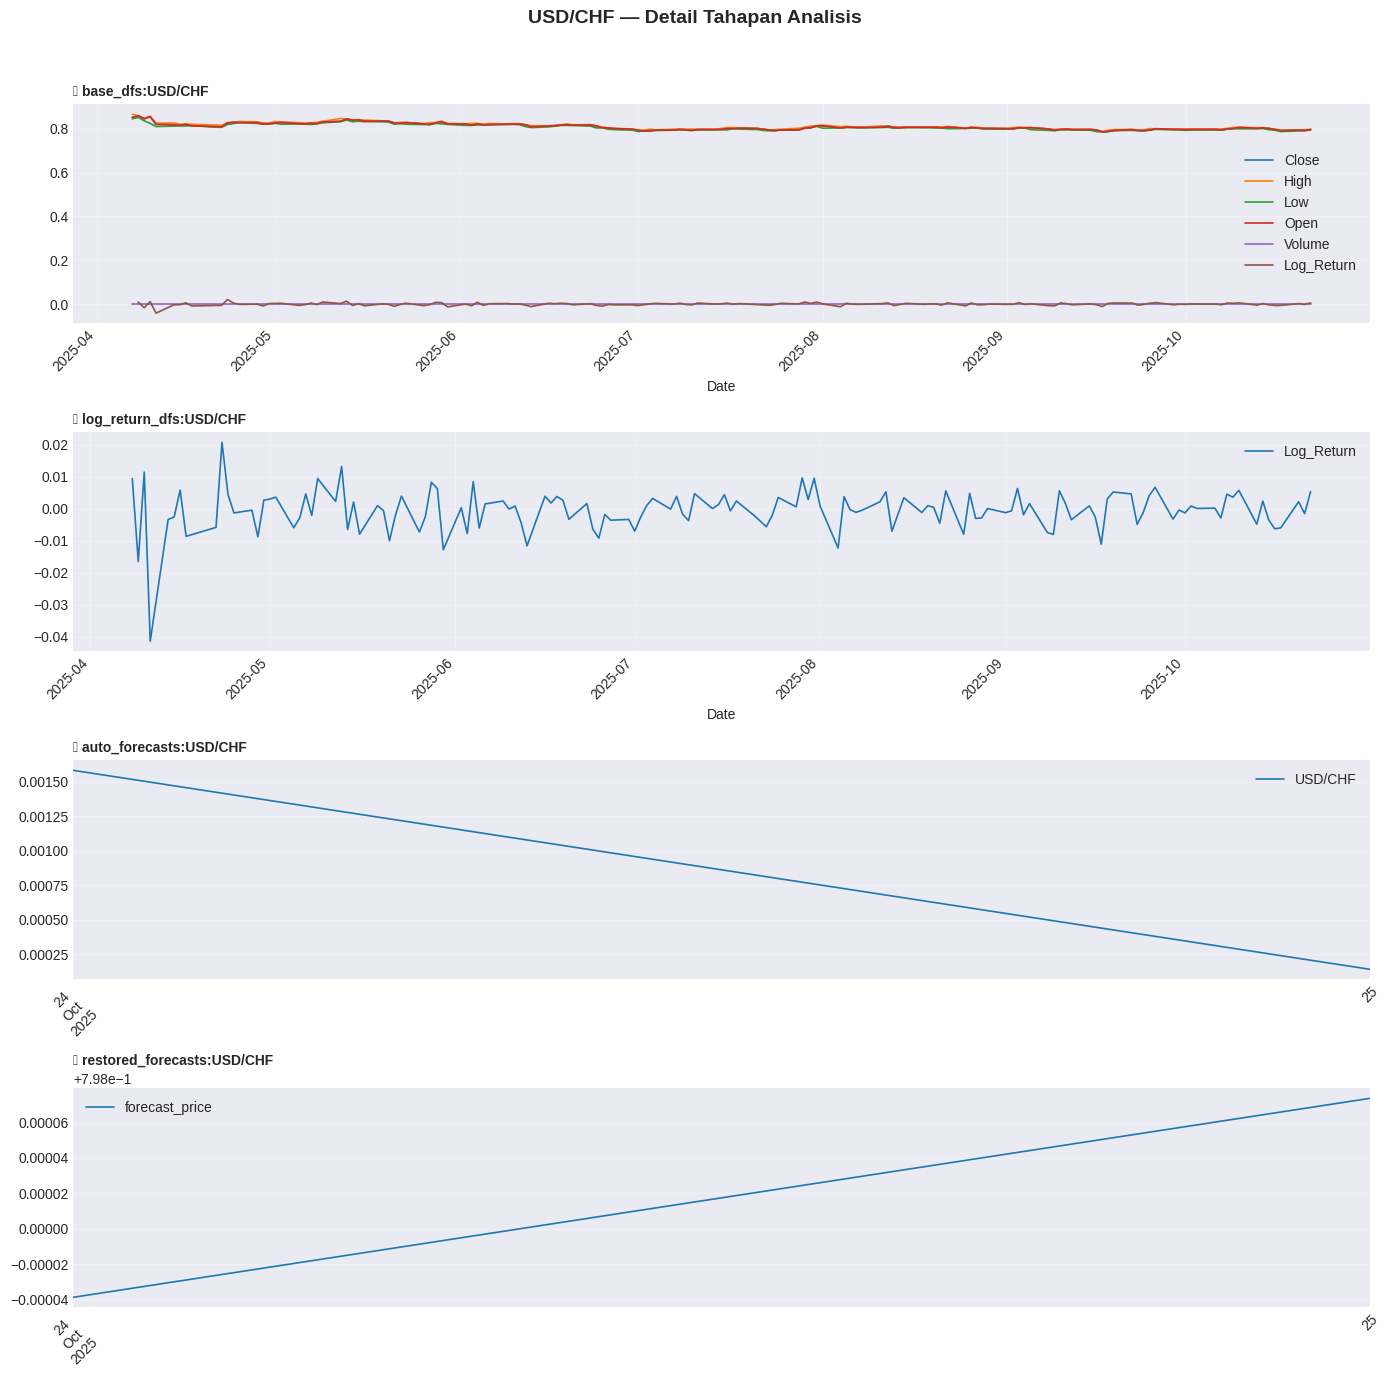


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: USD/JPY — total 4 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


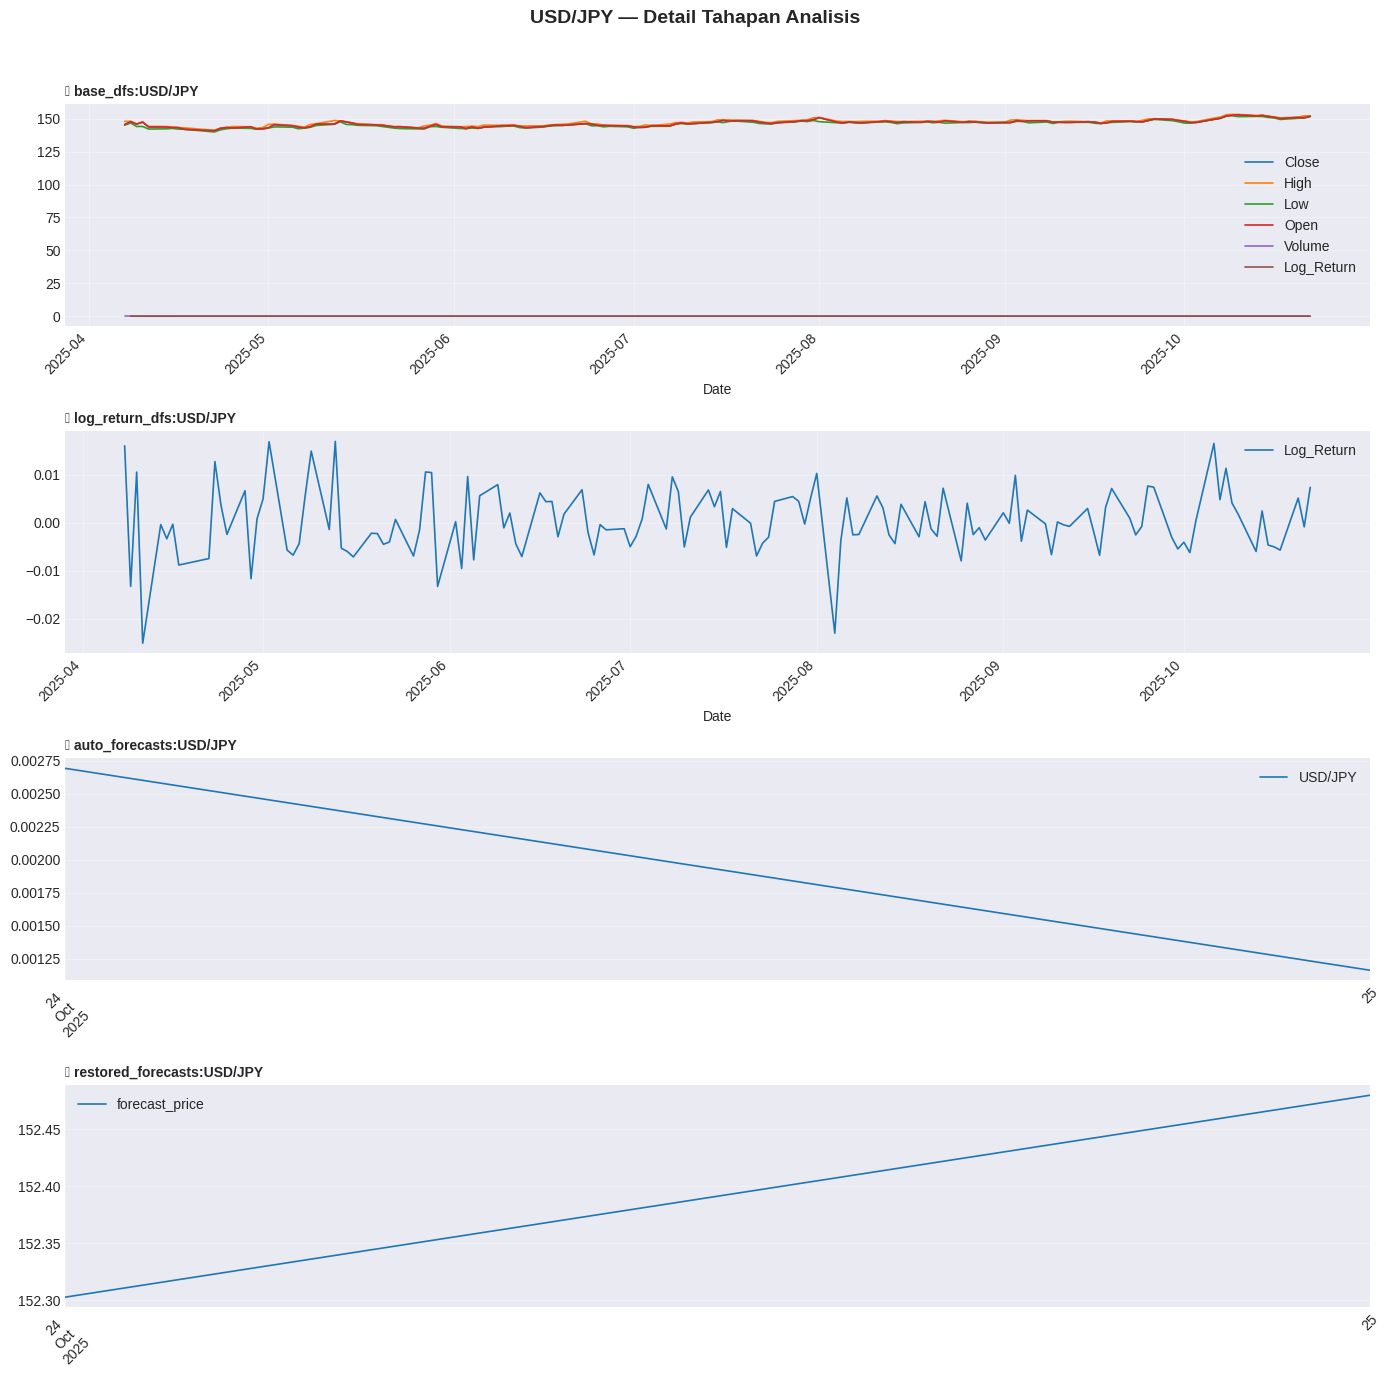


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: AUD/USD — total 4 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


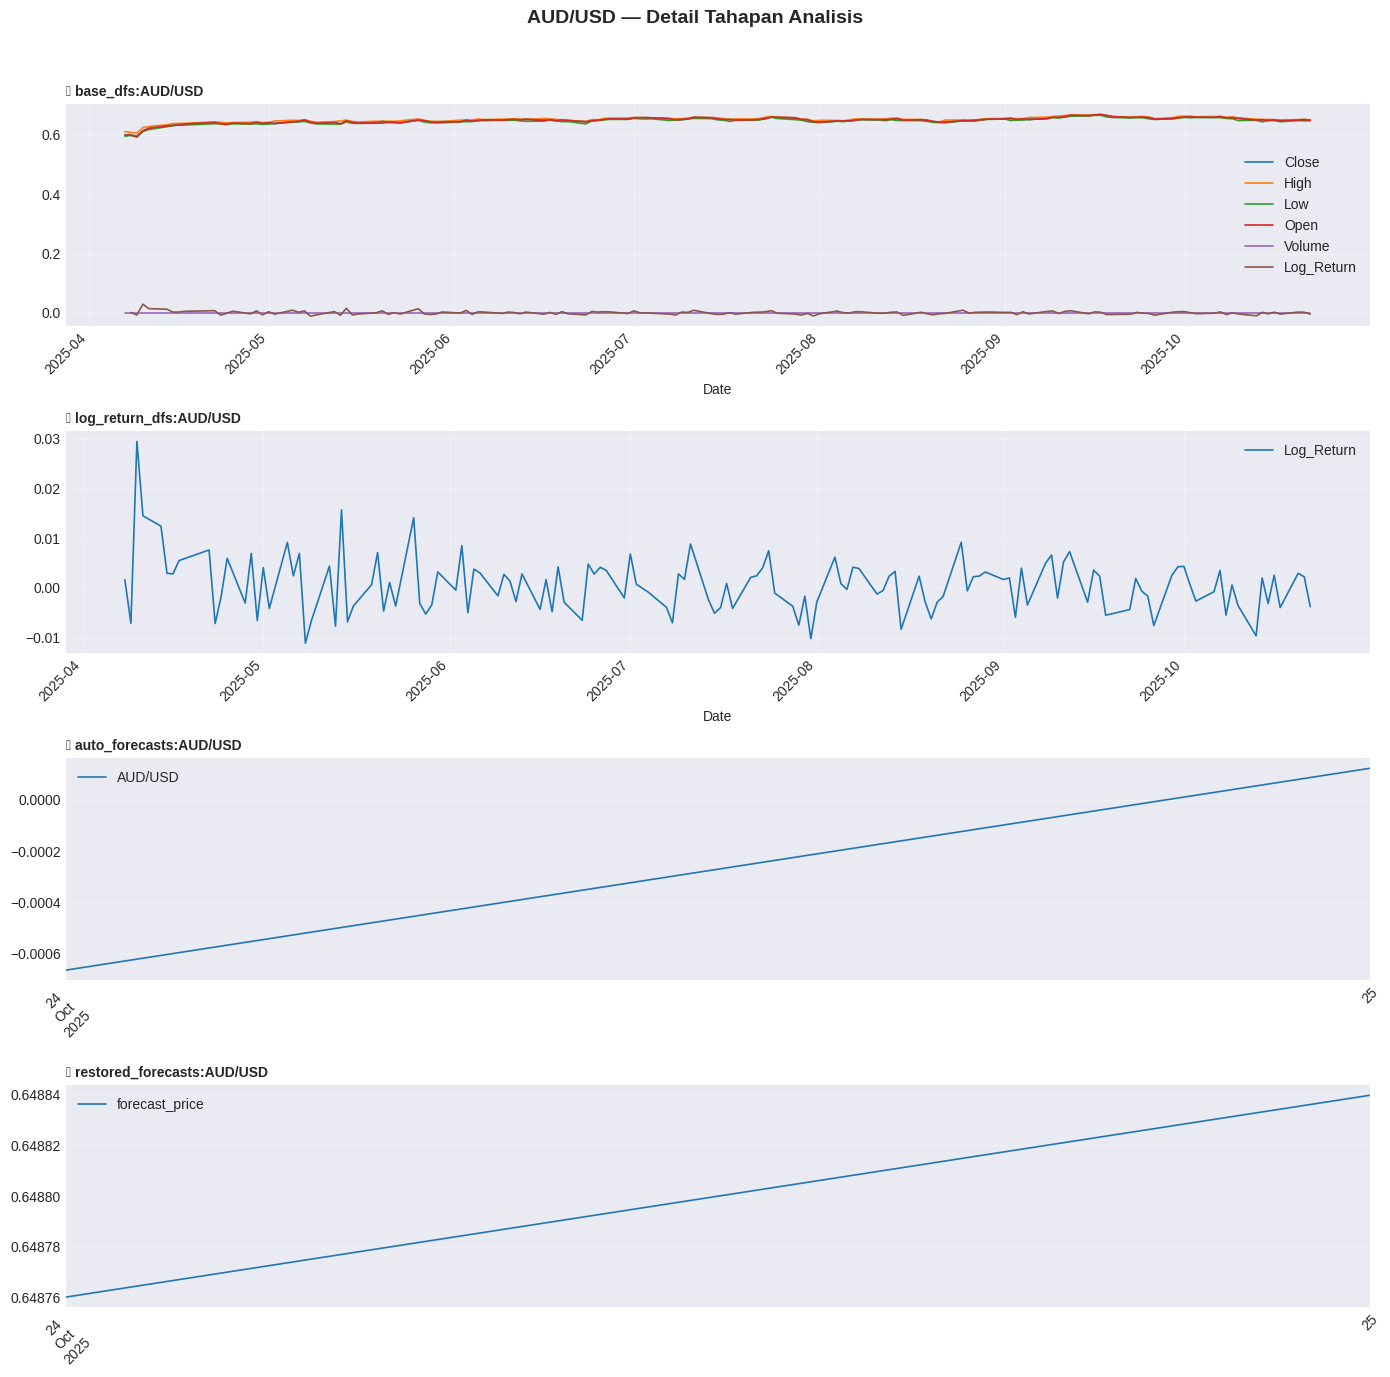


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: XAU/USD — total 4 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


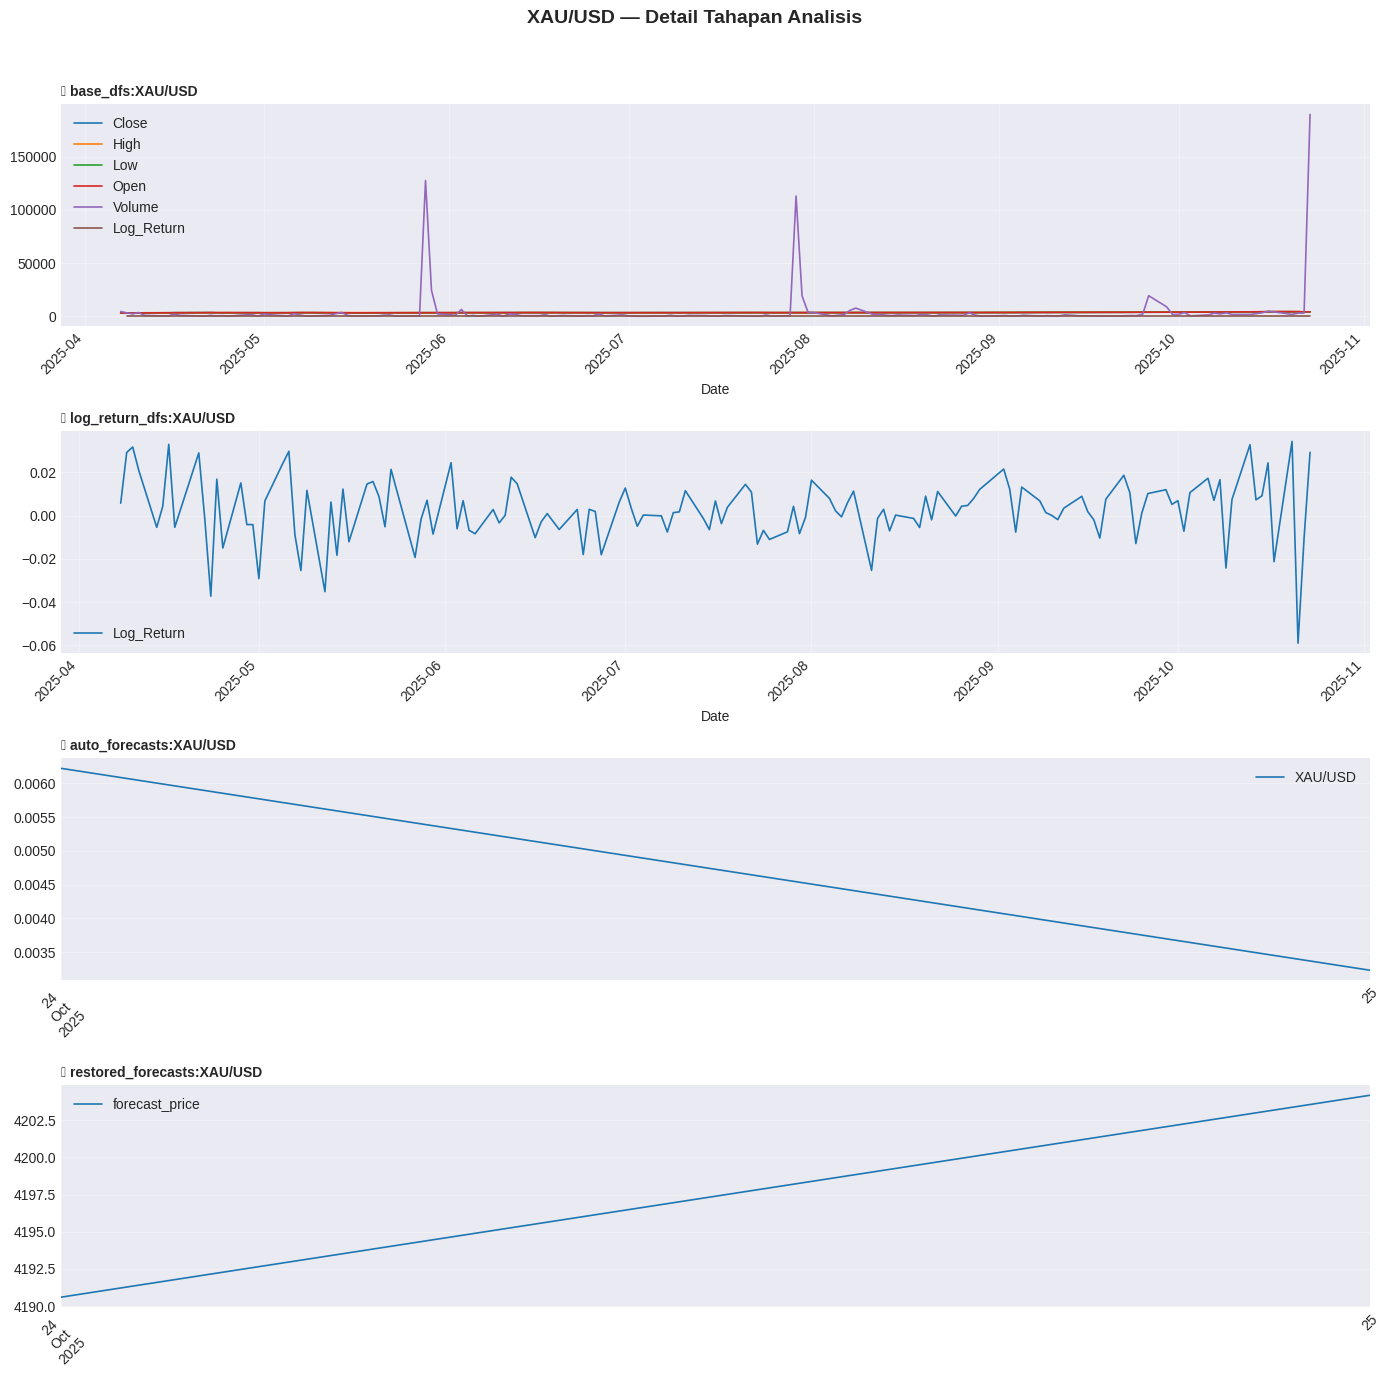


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: BTC/USD — total 4 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


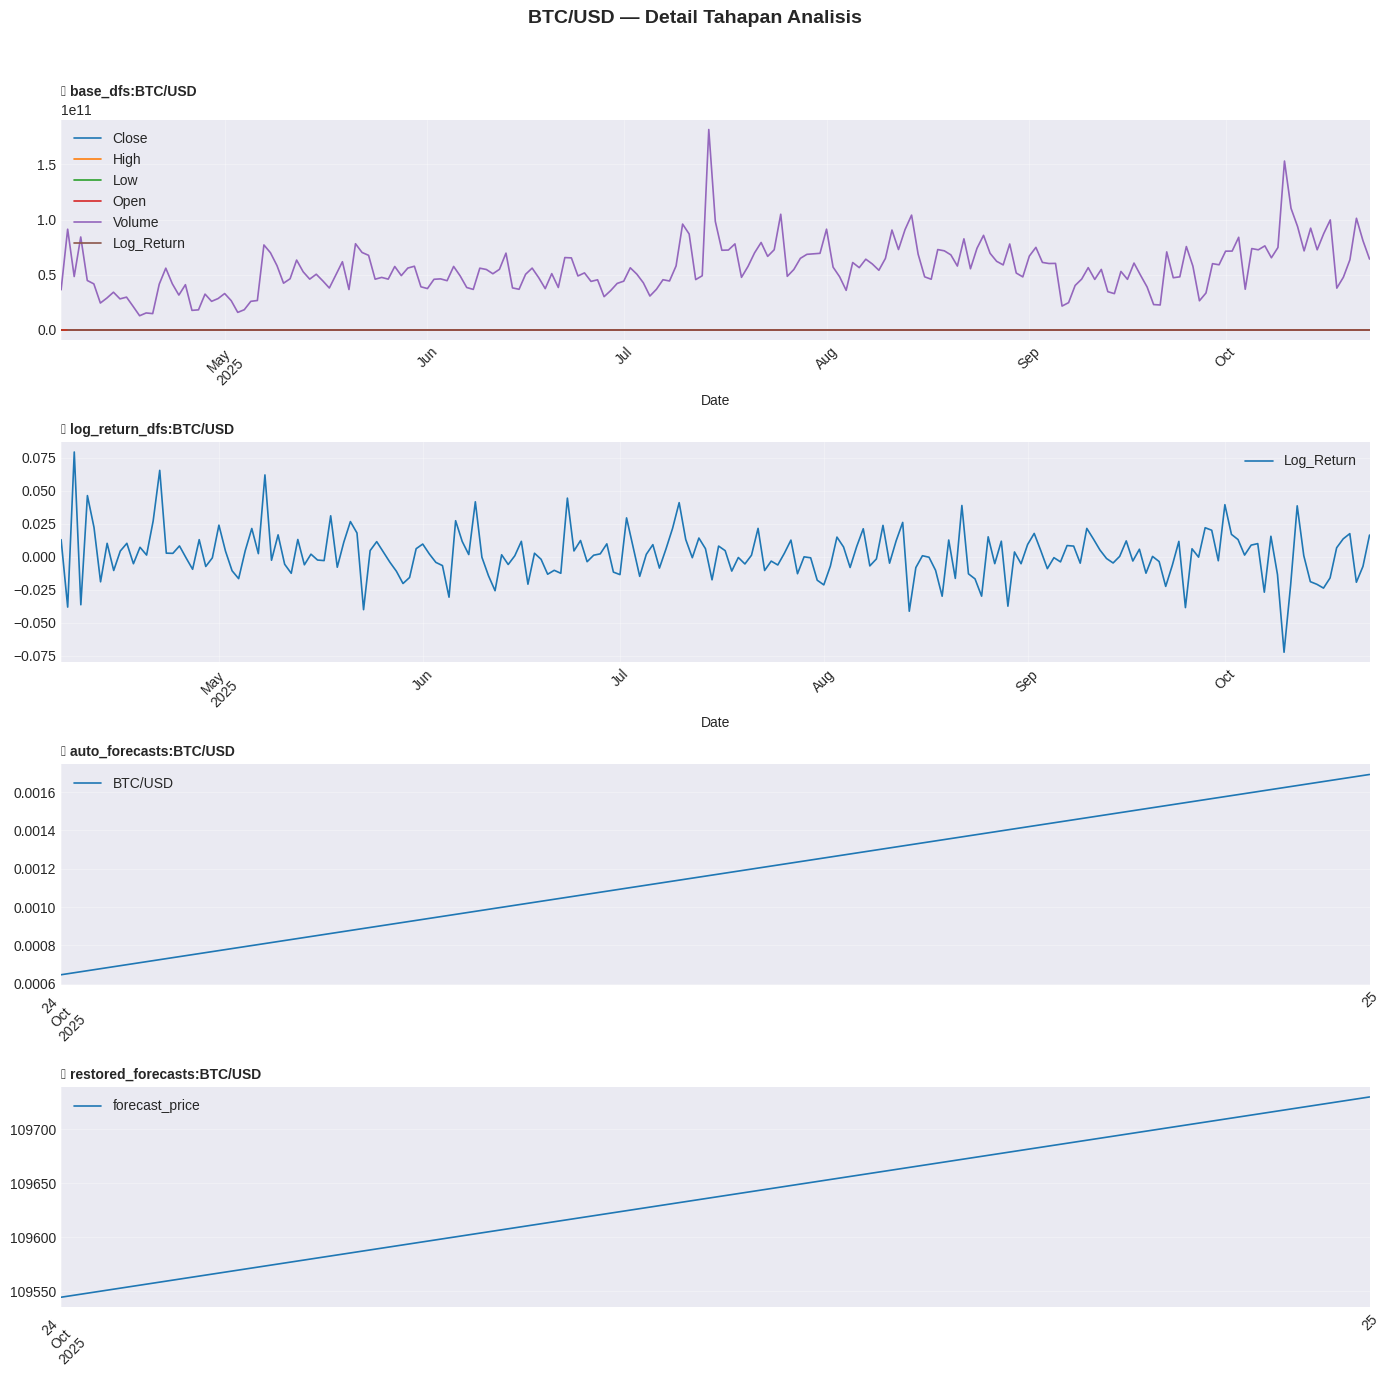


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SECUREDOVERNIGHTFINANCINGRATE — total 3 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


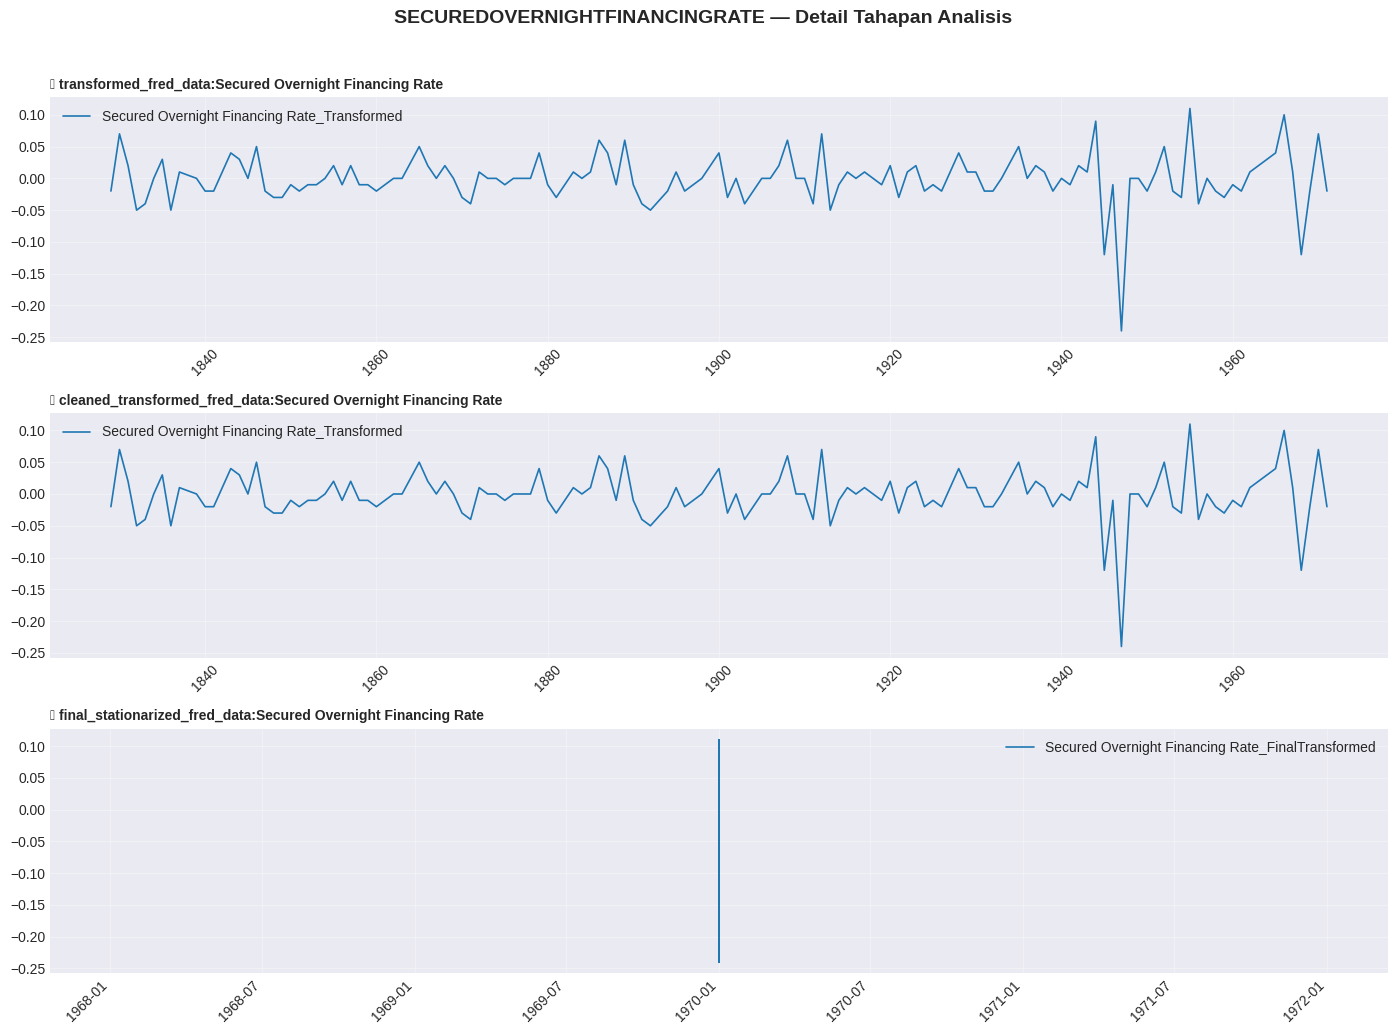


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SP500 — total 3 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


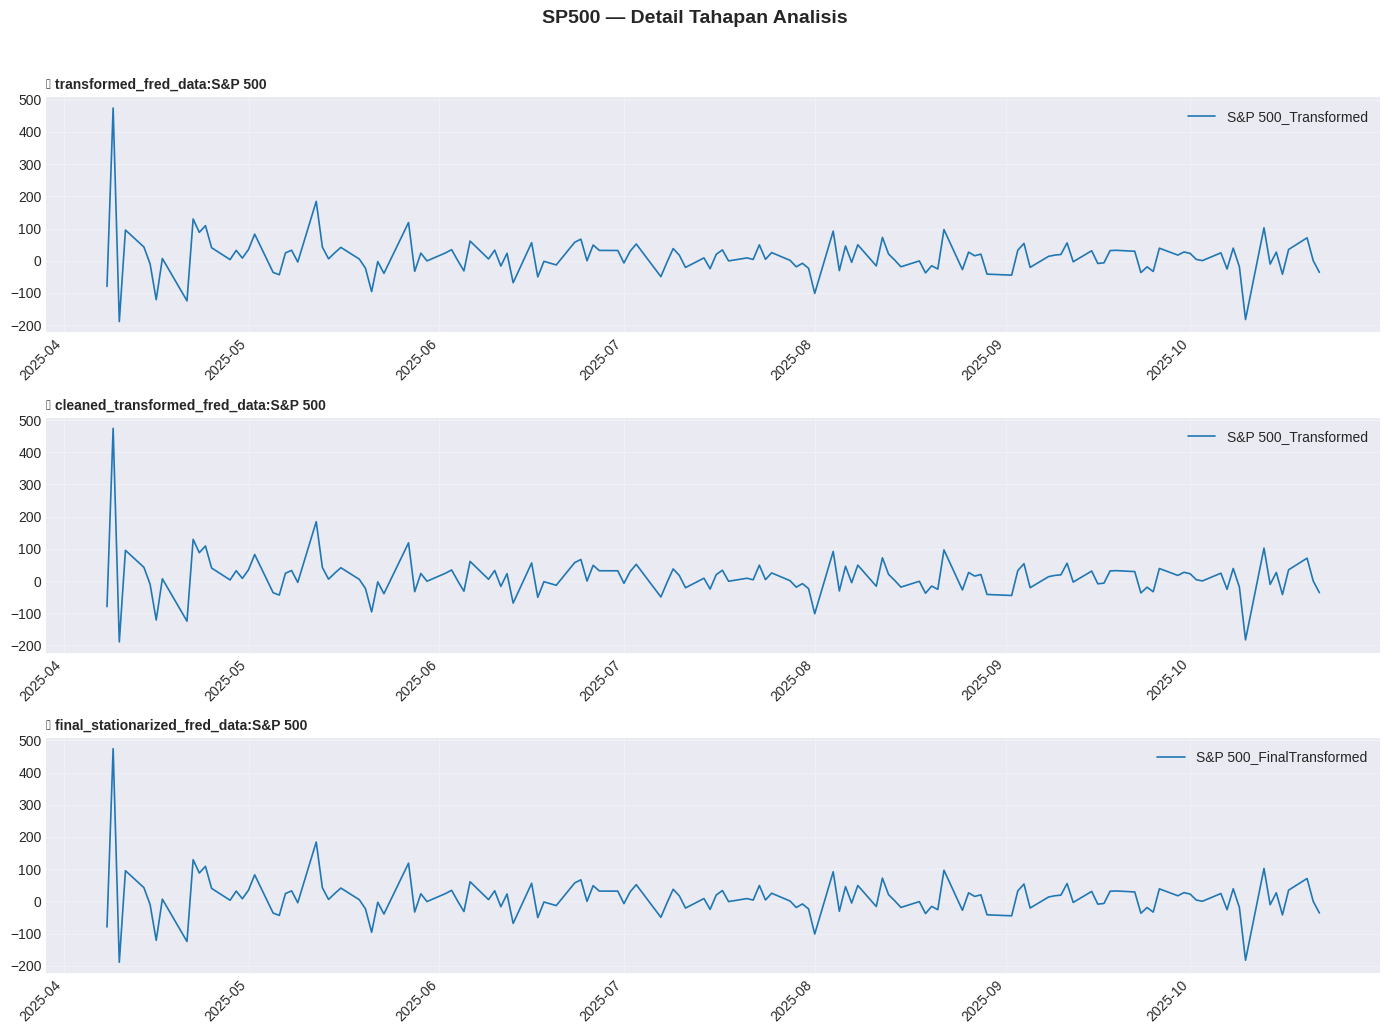


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: USCORPORATEINDEXSEMI-ANNUALYI — total 3 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


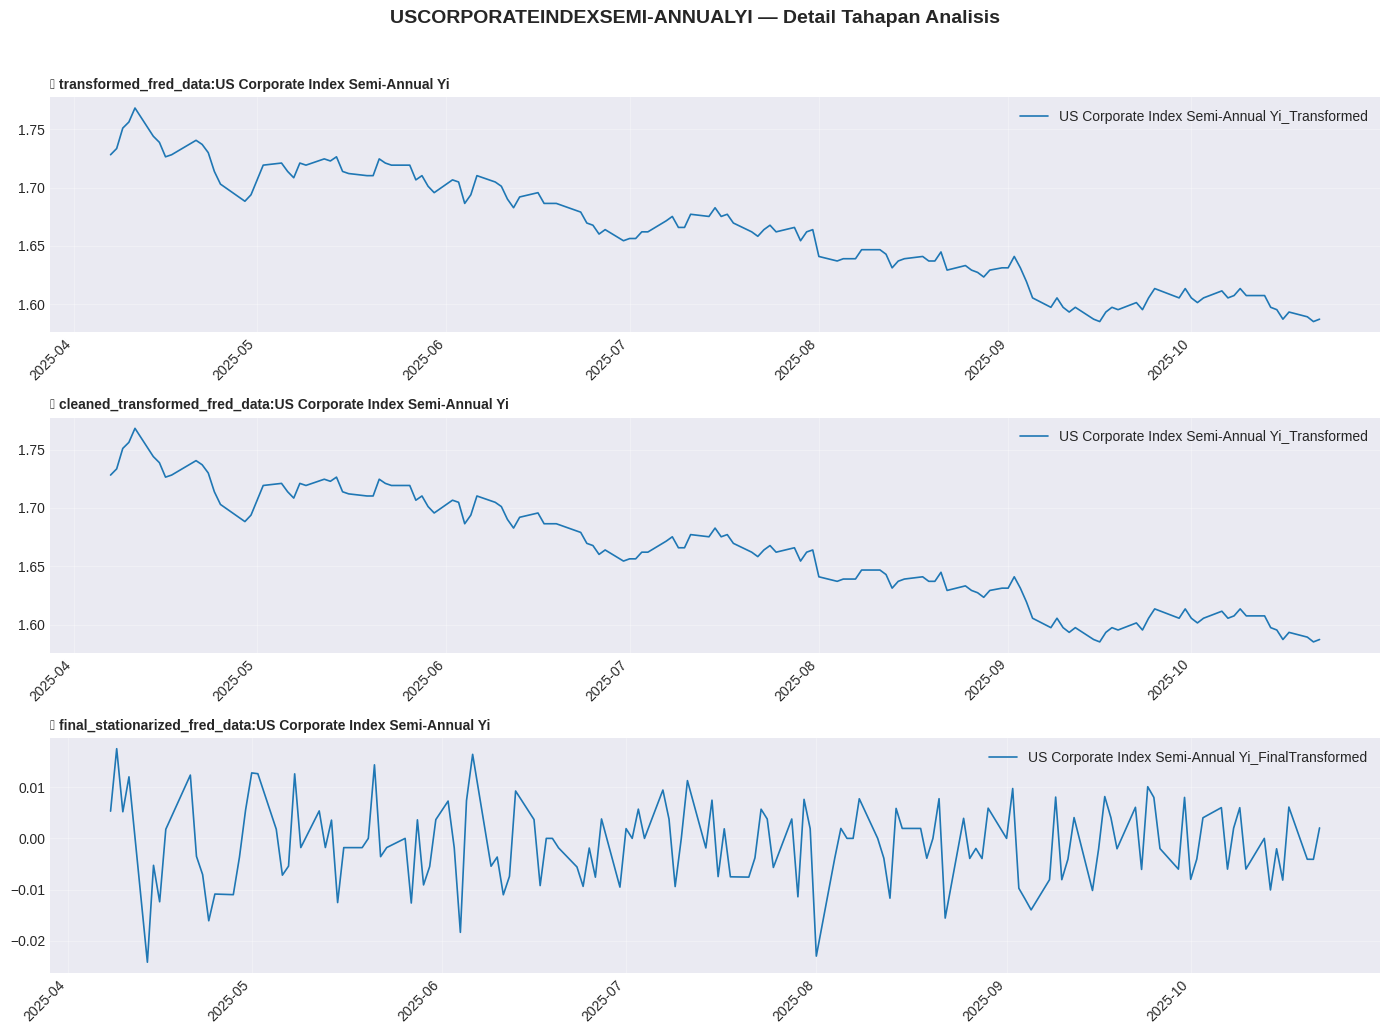


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: INDEXSEMI-ANNUAL — total 3 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


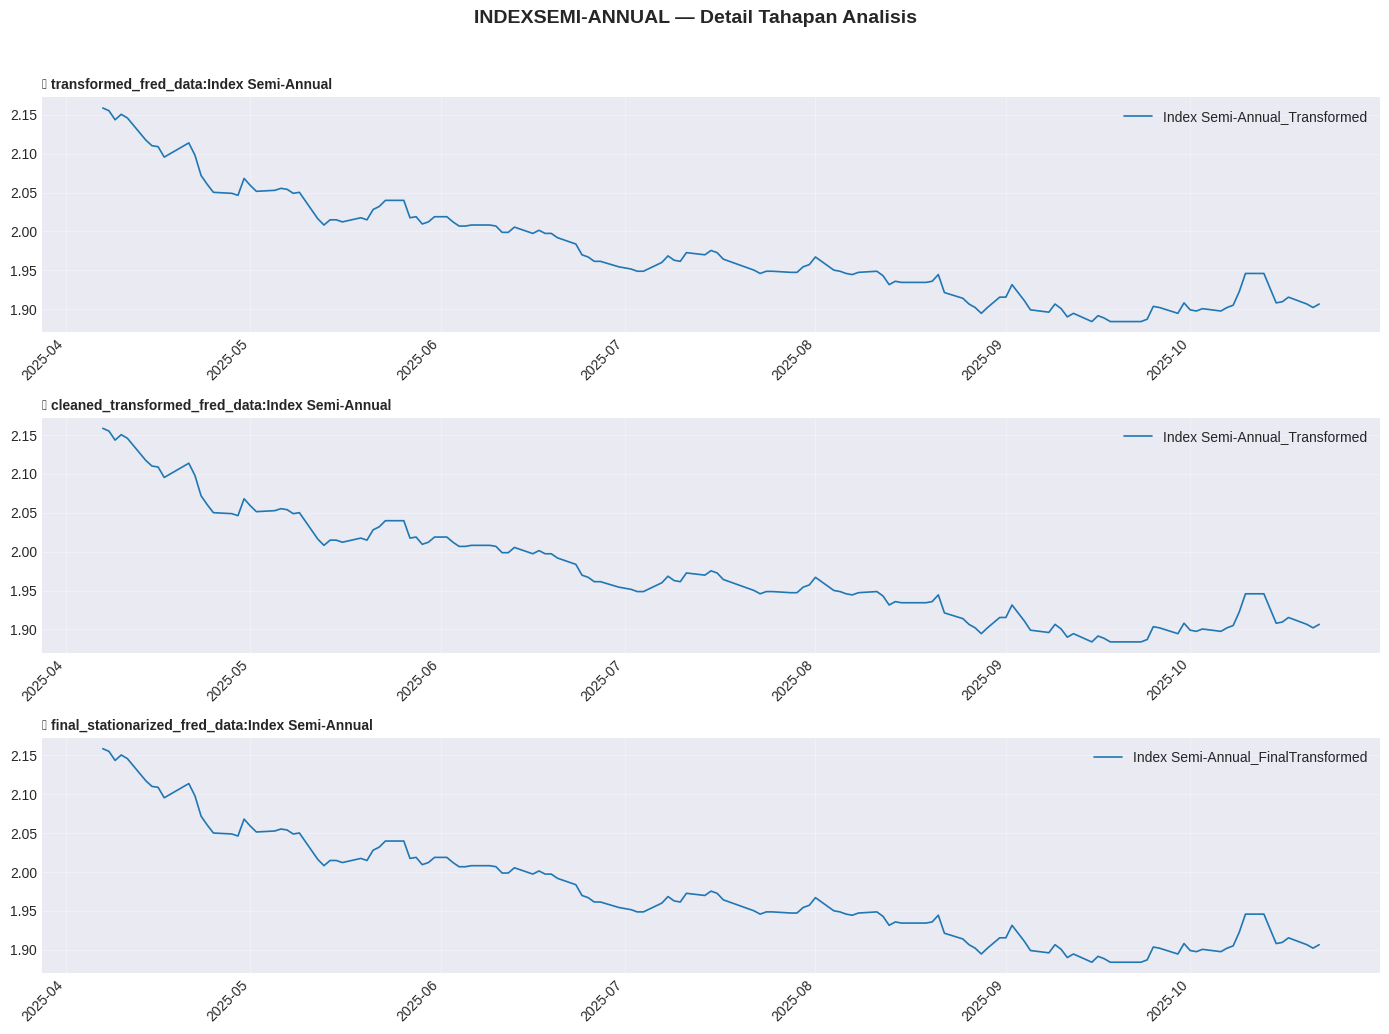


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: EMERGINGMARKETSCORPORATE — total 3 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


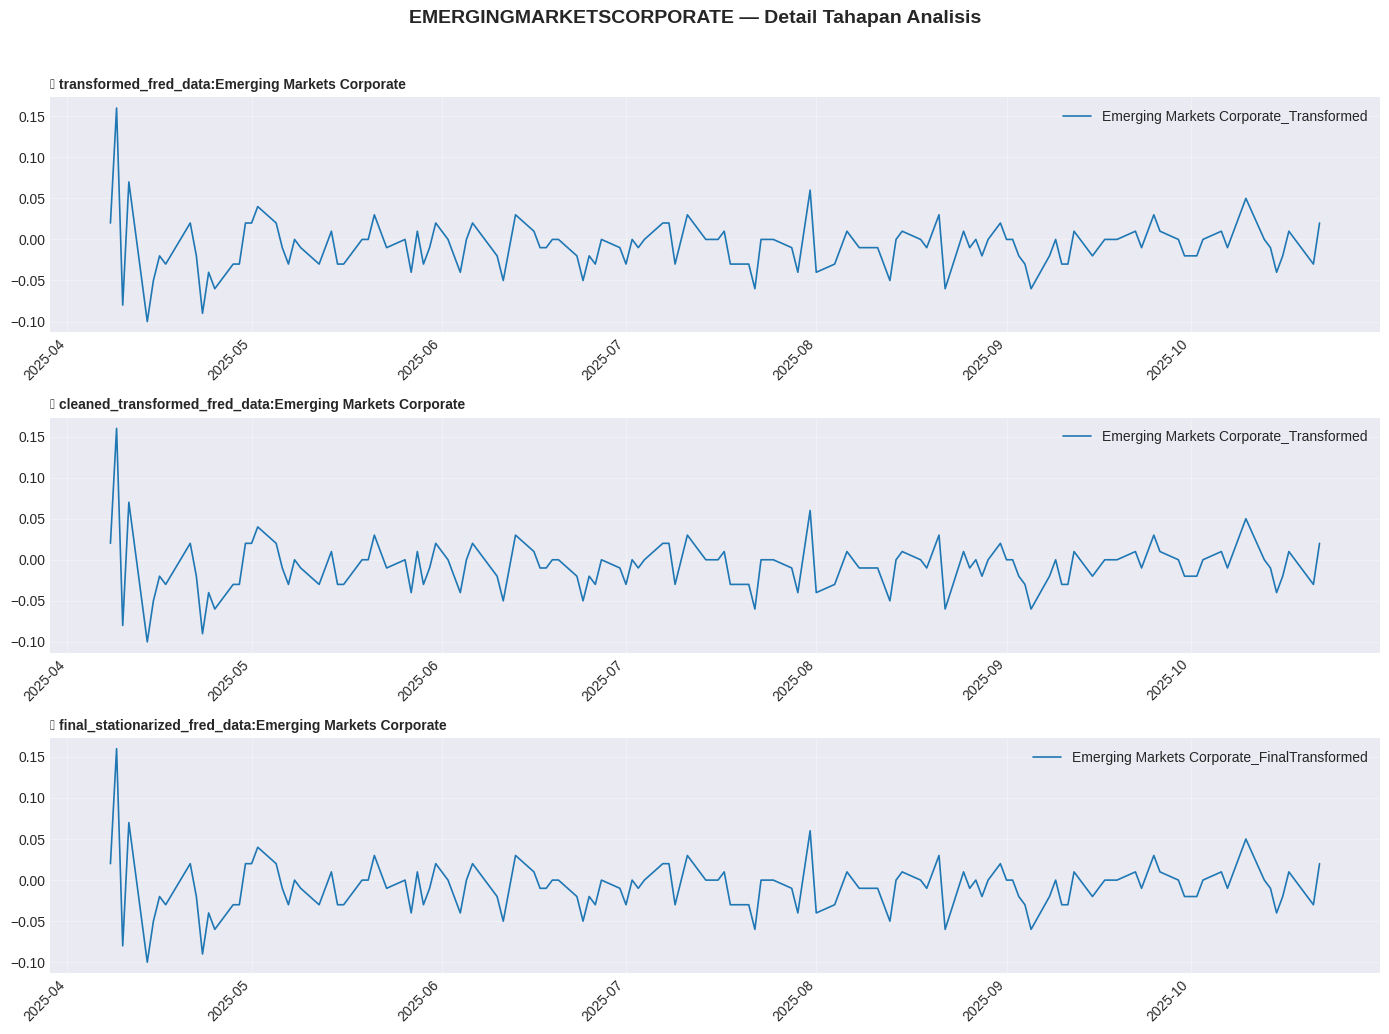


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: MARKETSCORPORATEPLUS — total 3 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


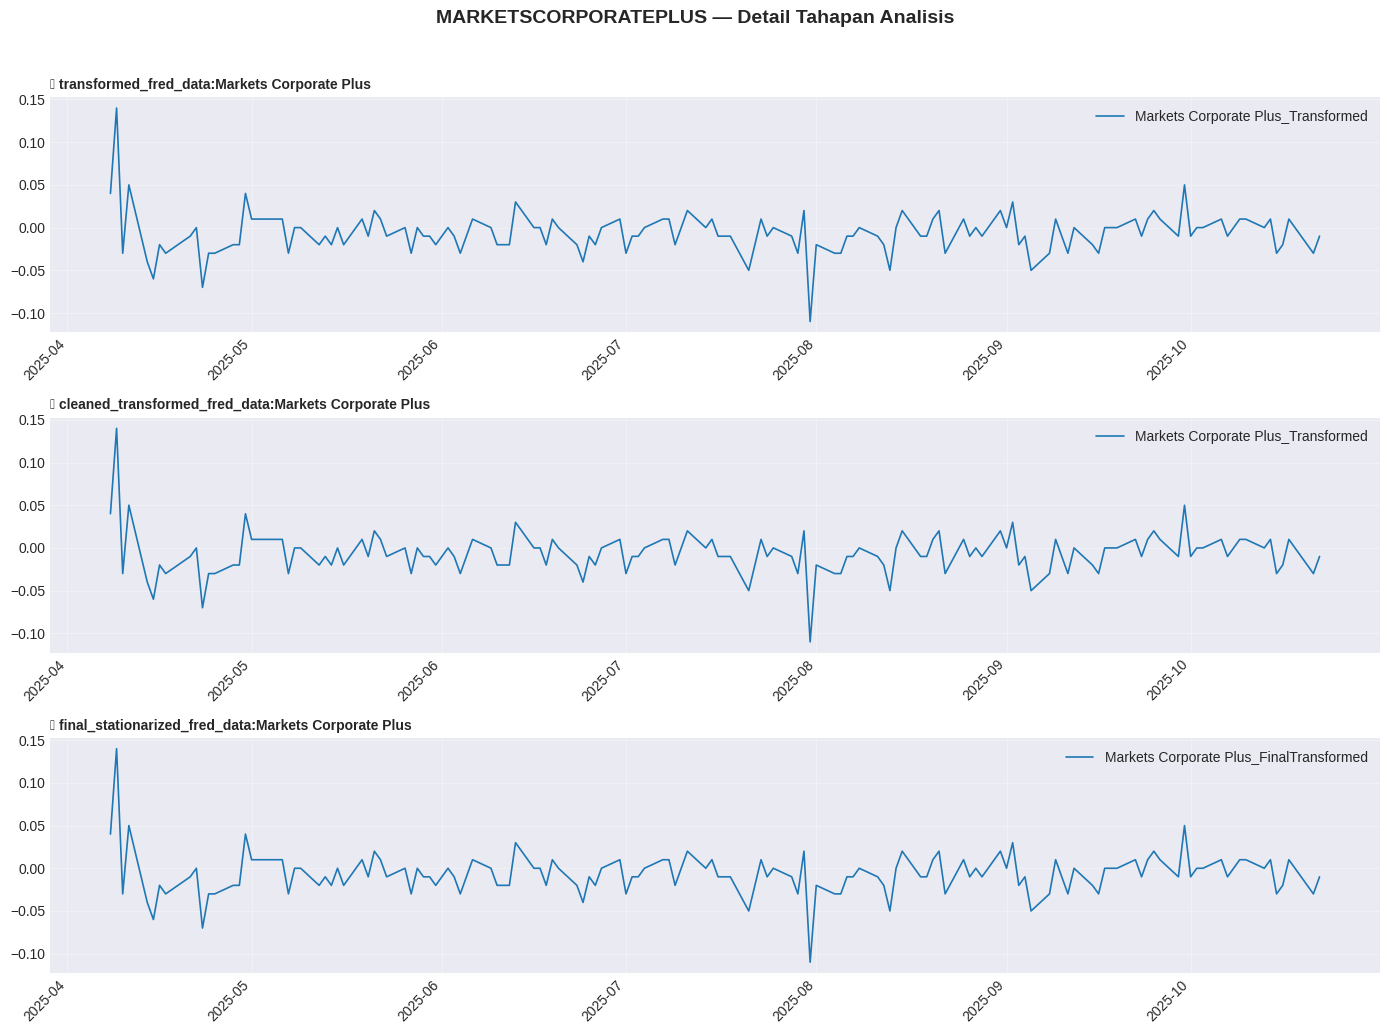


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: FINANCIALUSEMERGINGMARKETSLIQUIQ — total 3 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


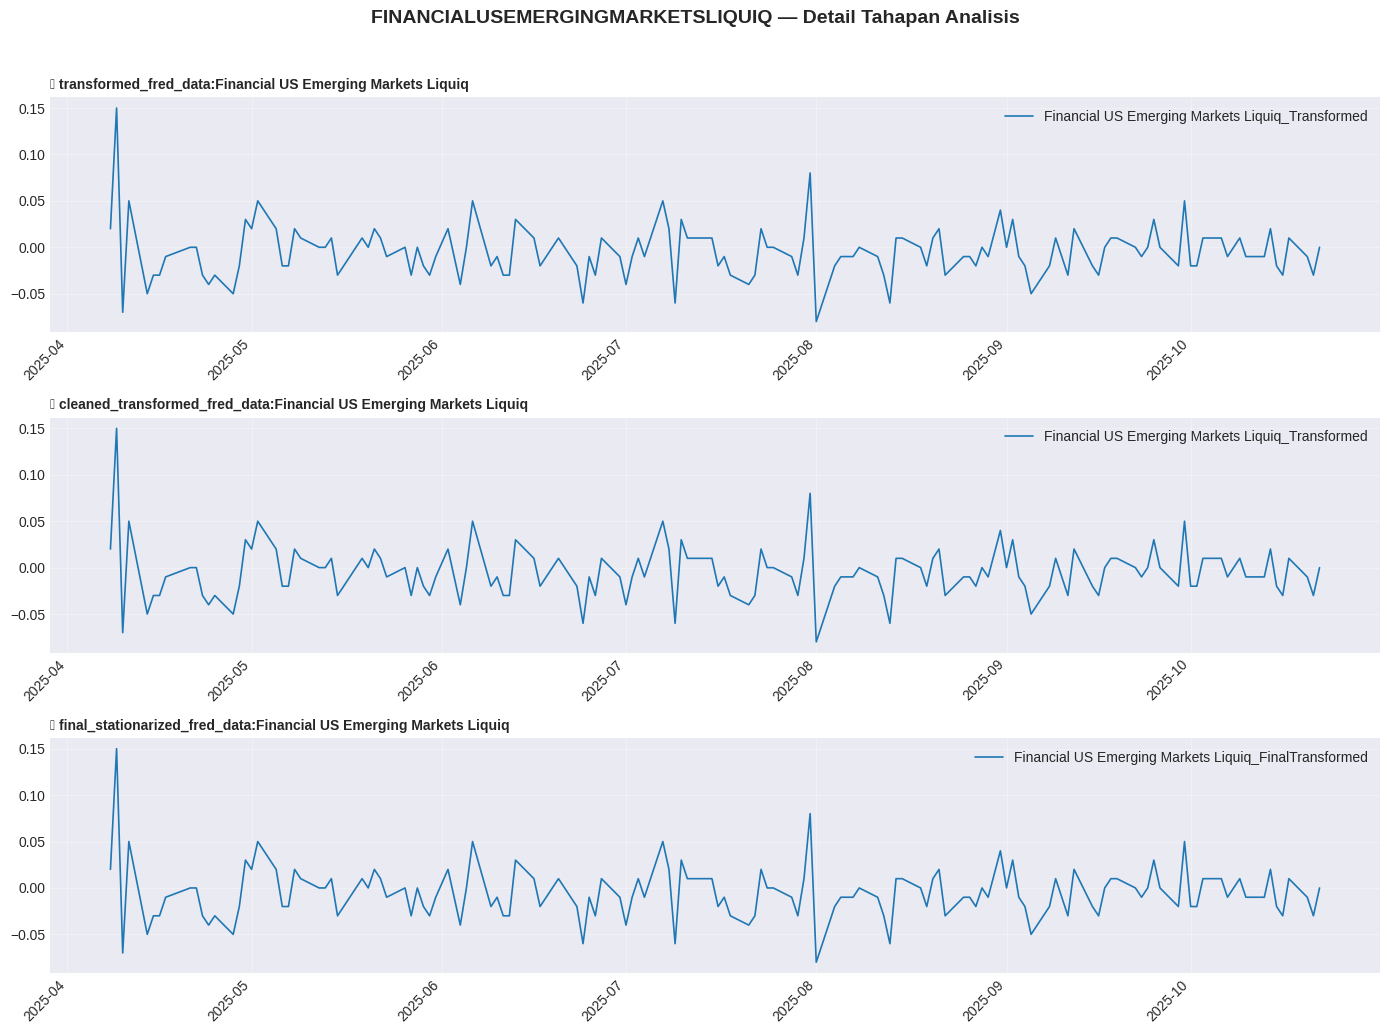


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DAILYSTERLINGOVERNIGHTINDEXAVERAGESONIA — total 3 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


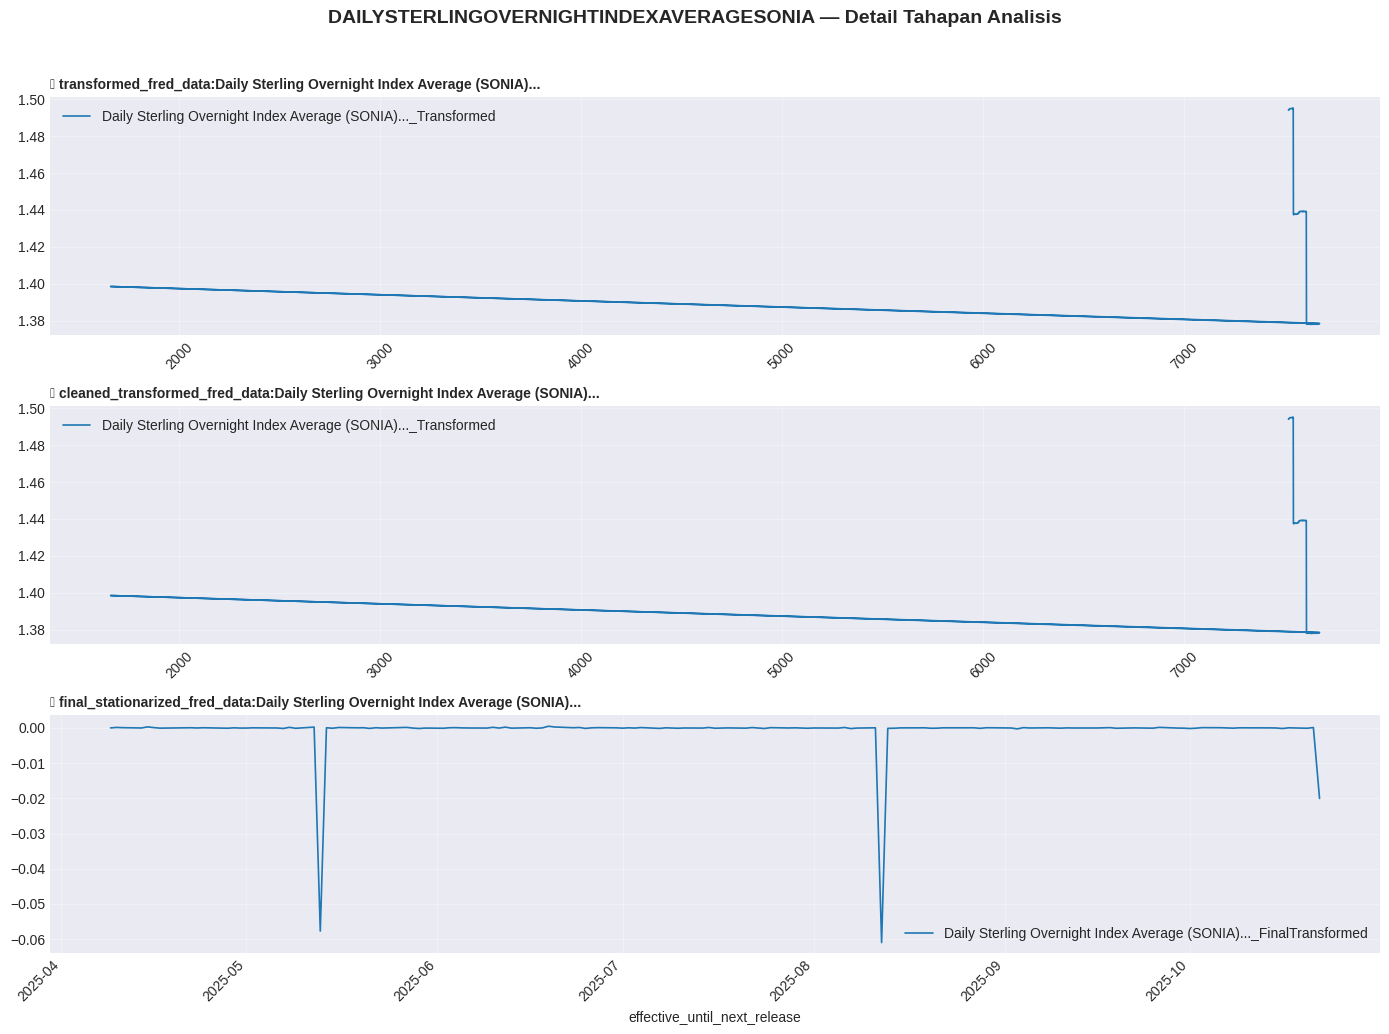


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: ACTUAL — total 2 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


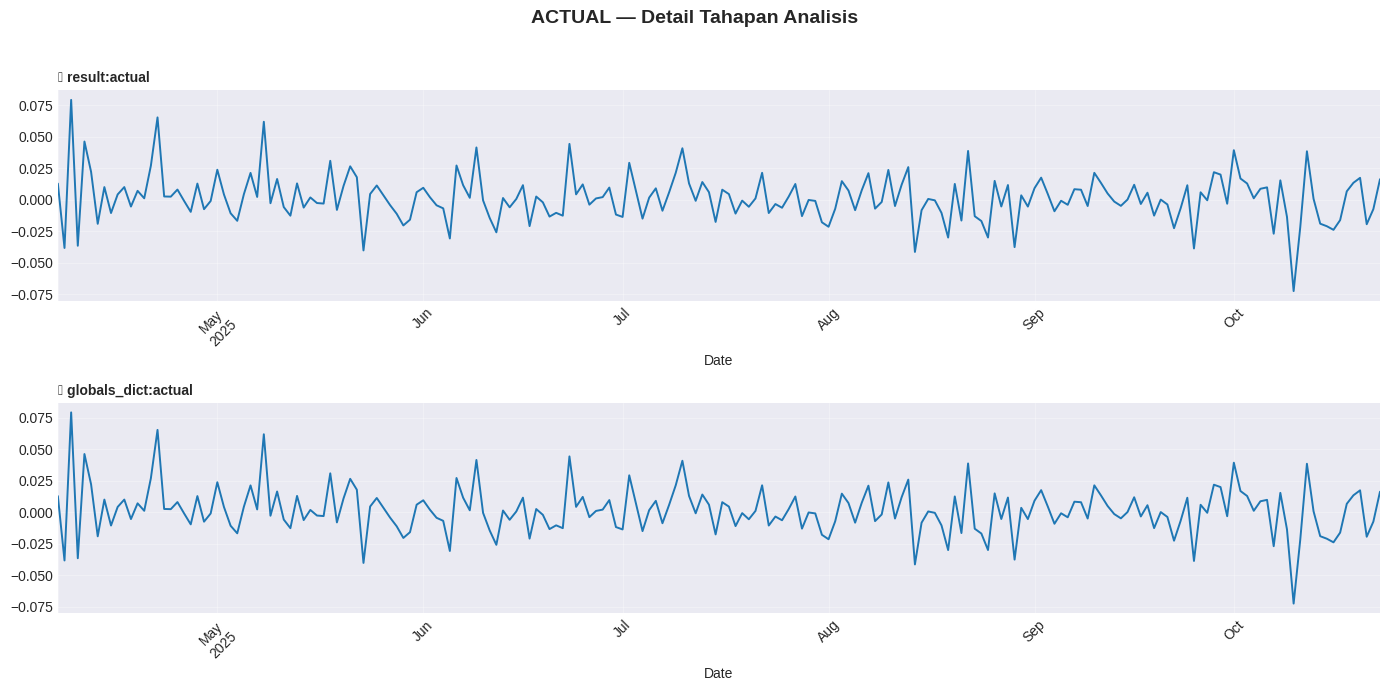


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: FORECAST — total 2 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


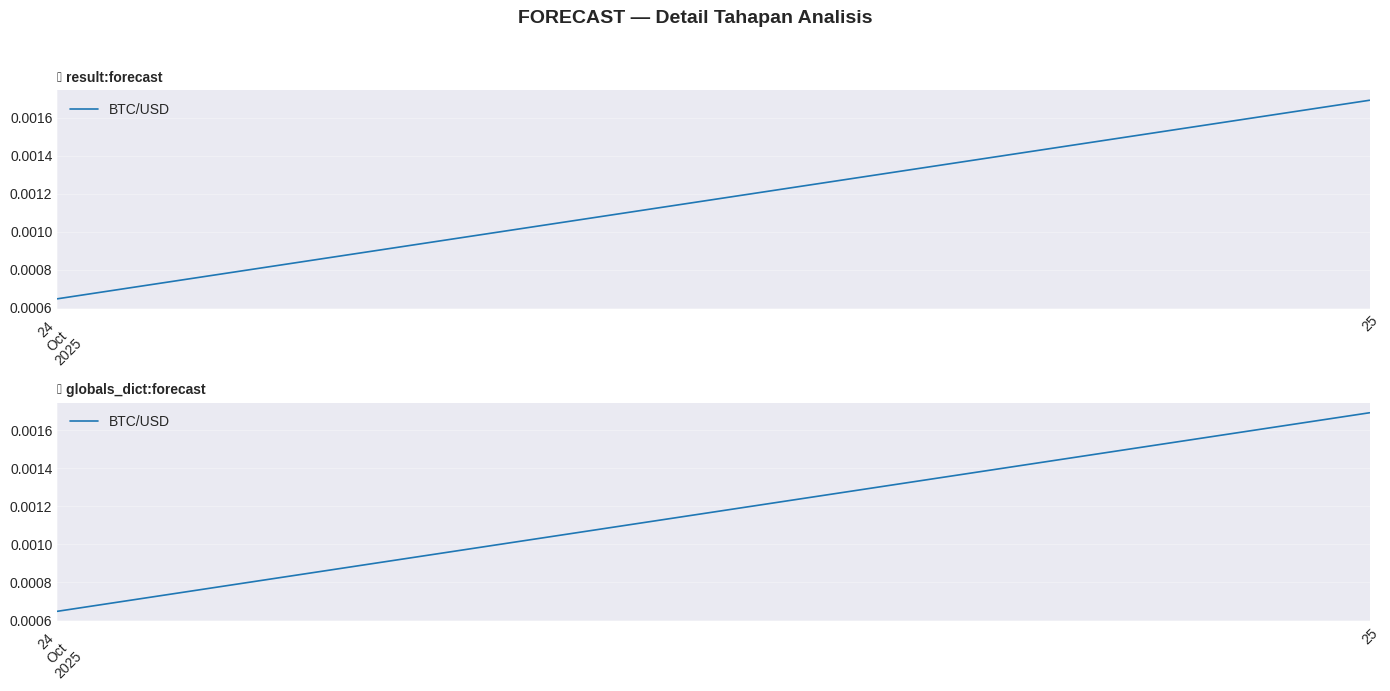


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


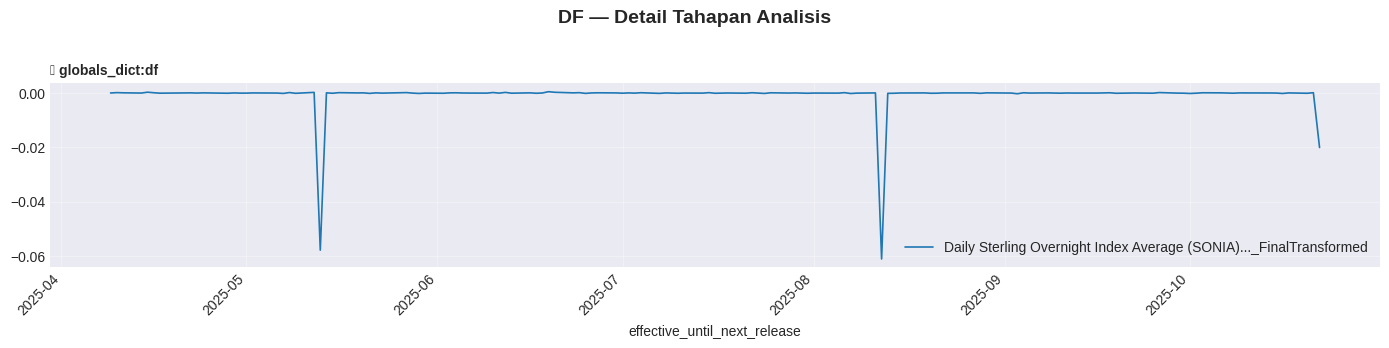


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: FRED_DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


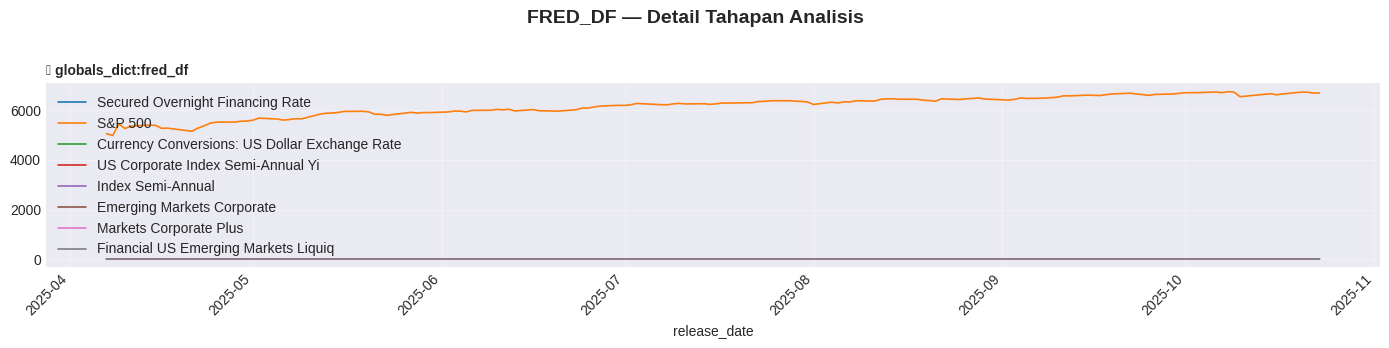


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SUBDF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


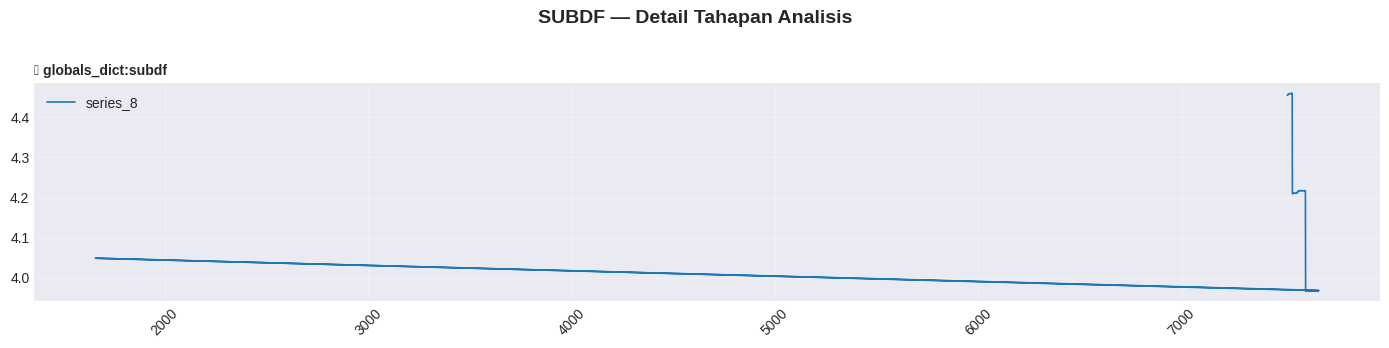


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_BASE — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


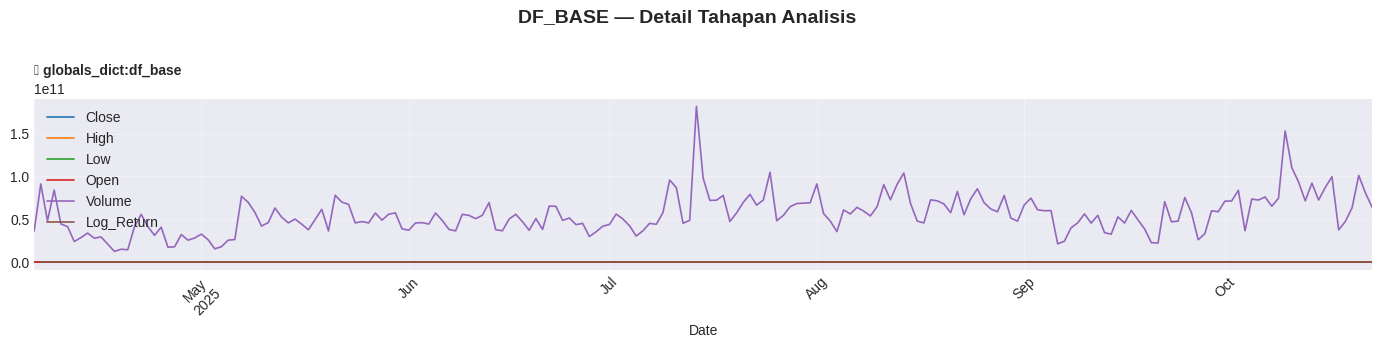


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: FRED_DF_LOCALIZED — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


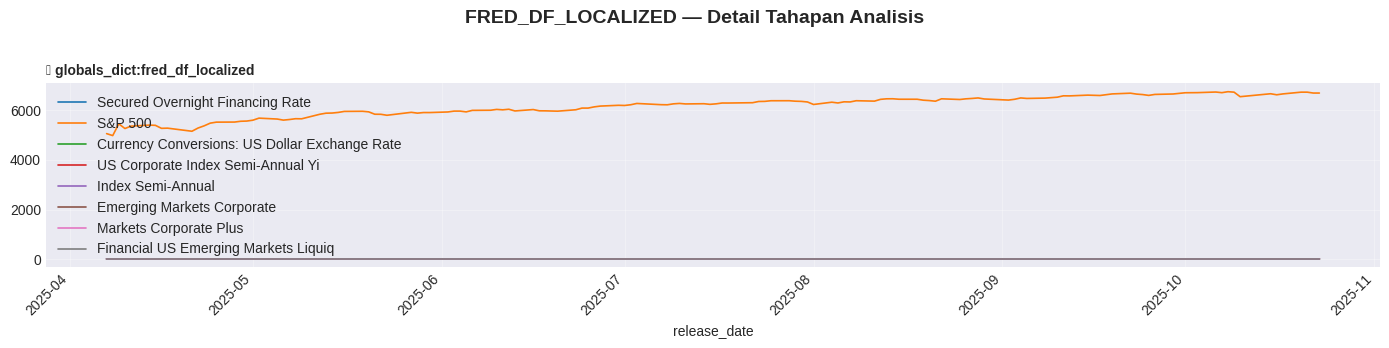


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SUB_FRED — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


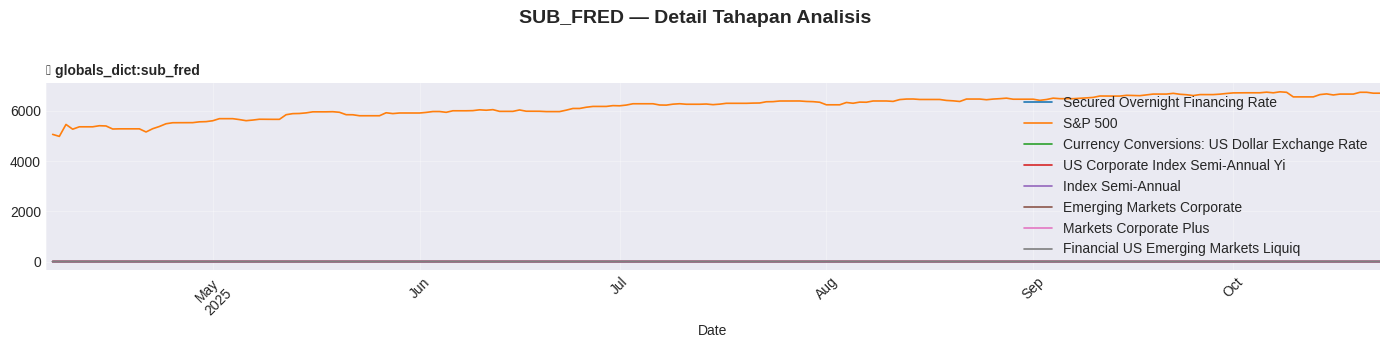


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_LOG_RETURN — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


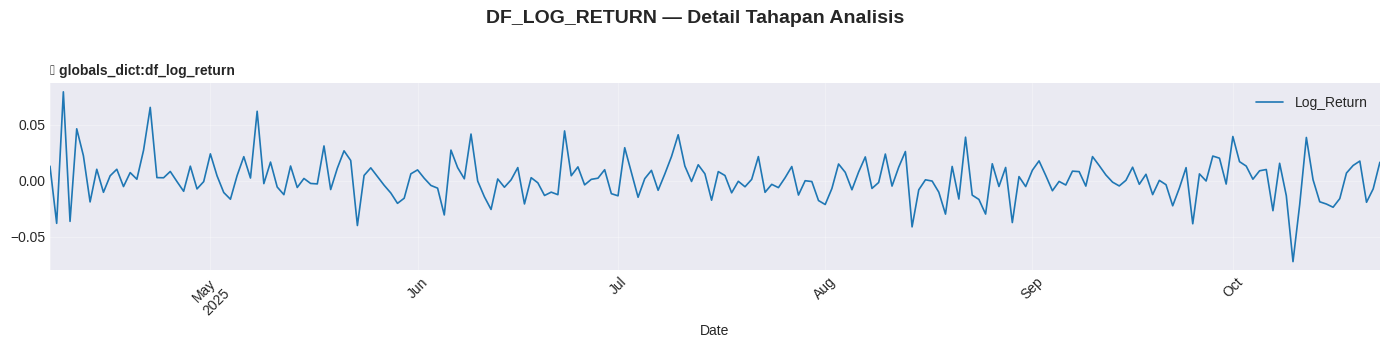


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_SERIES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


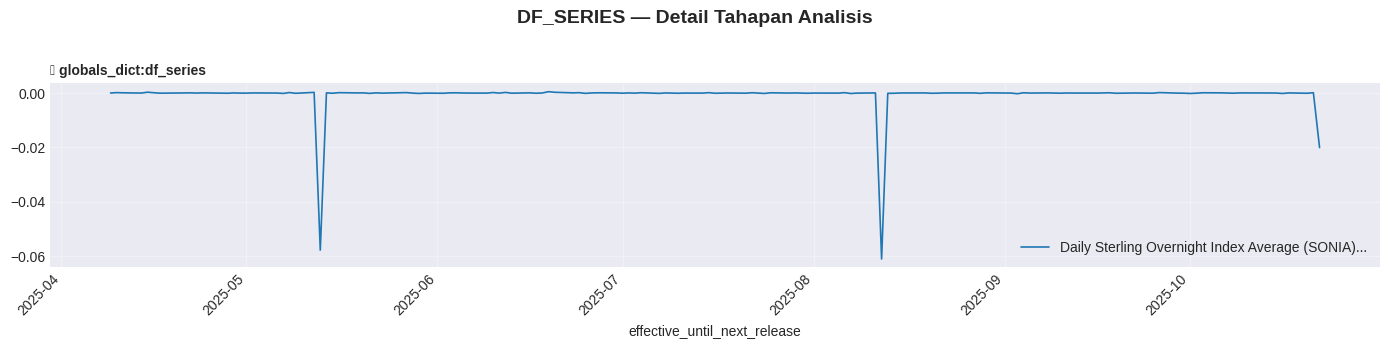


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: TRANSFORMED_SERIES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


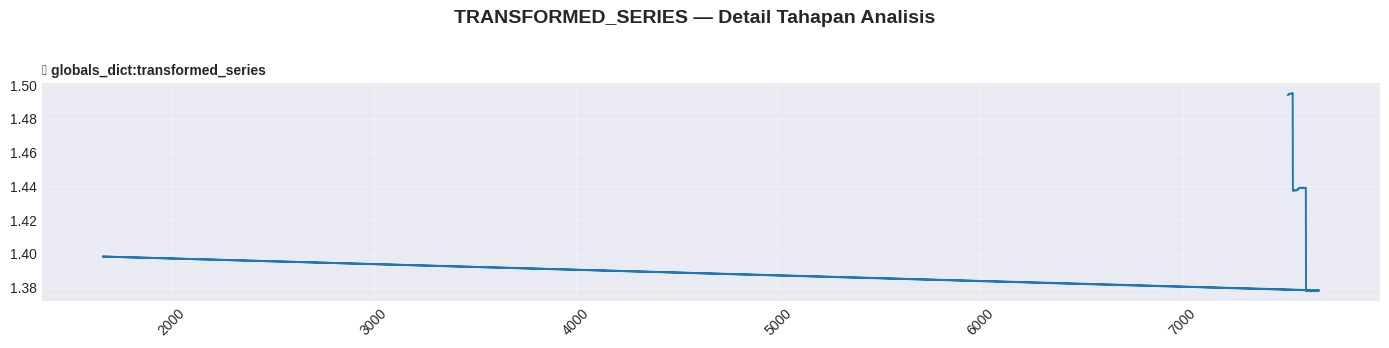


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: TRANSFORMED_DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


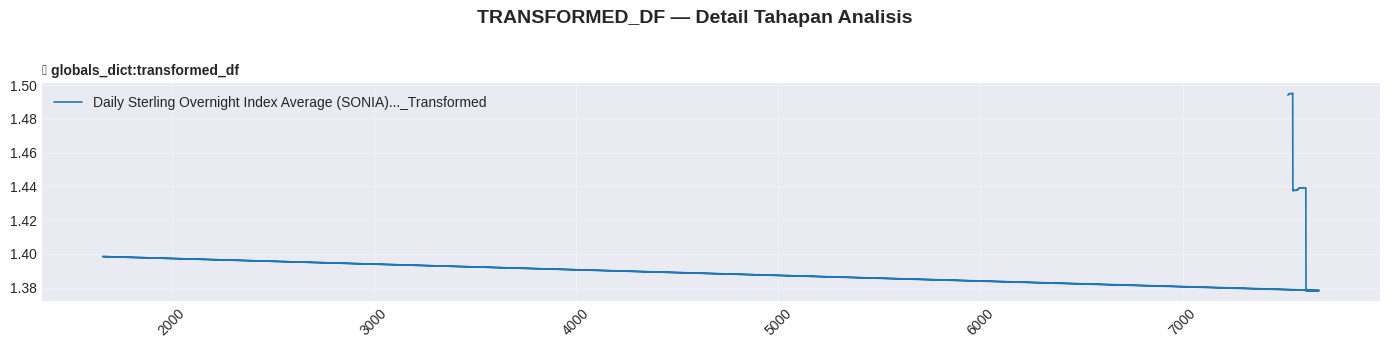


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SERIES_TO_DROP — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


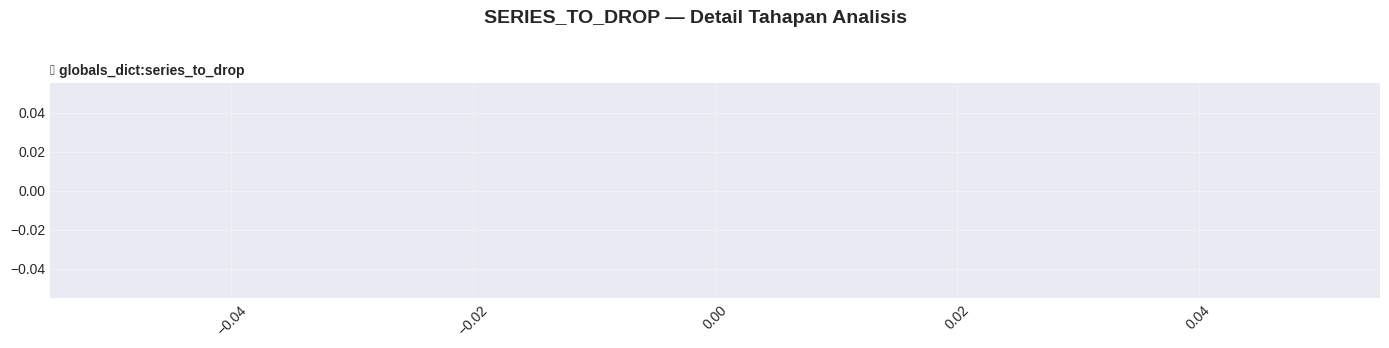


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_TRANSFORMED — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


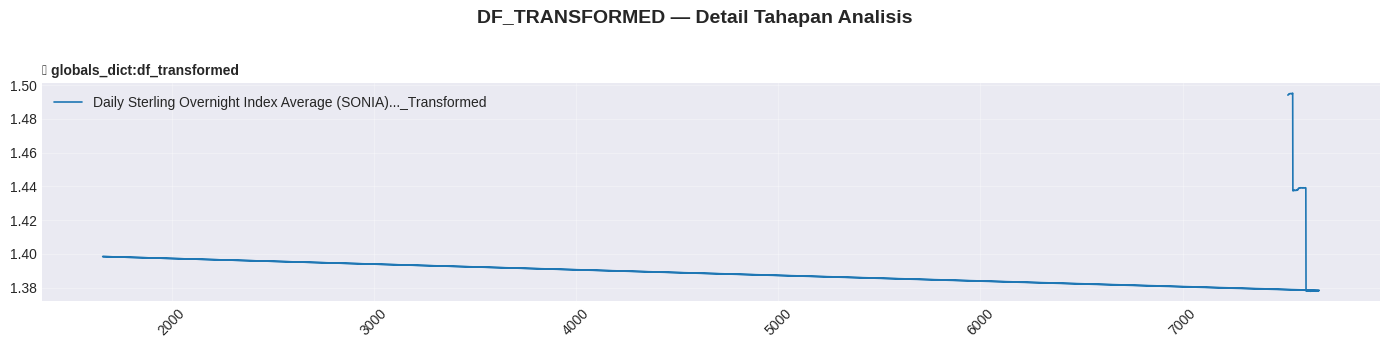


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_CLEANED — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


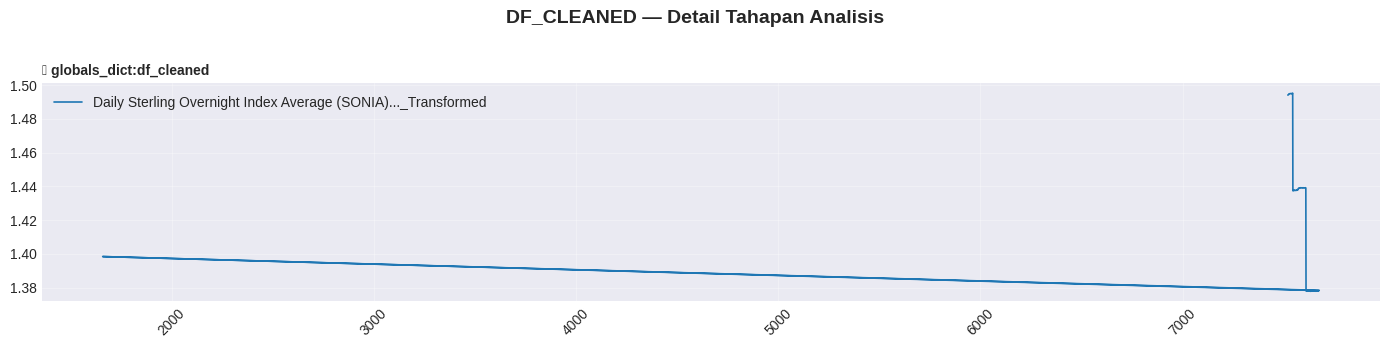


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SERIES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


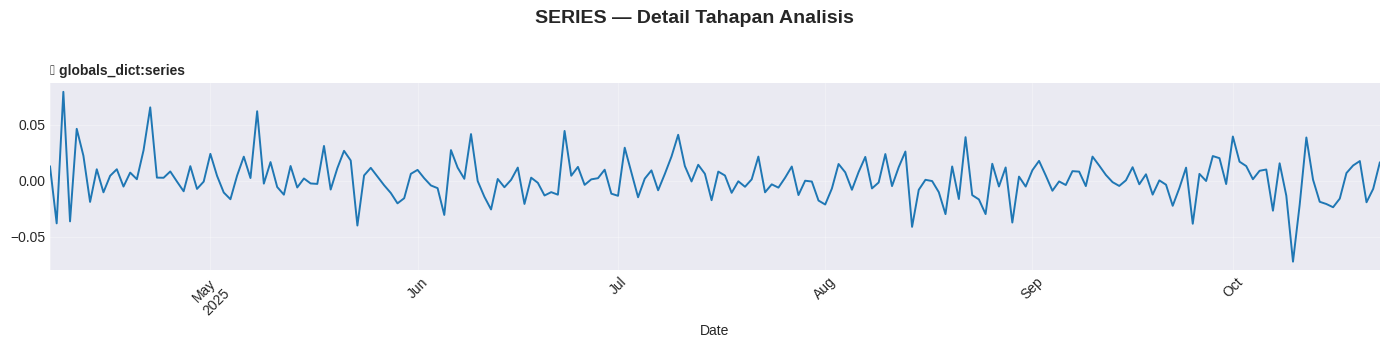


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: ORIGINAL_TRANSFORMED_SERIES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


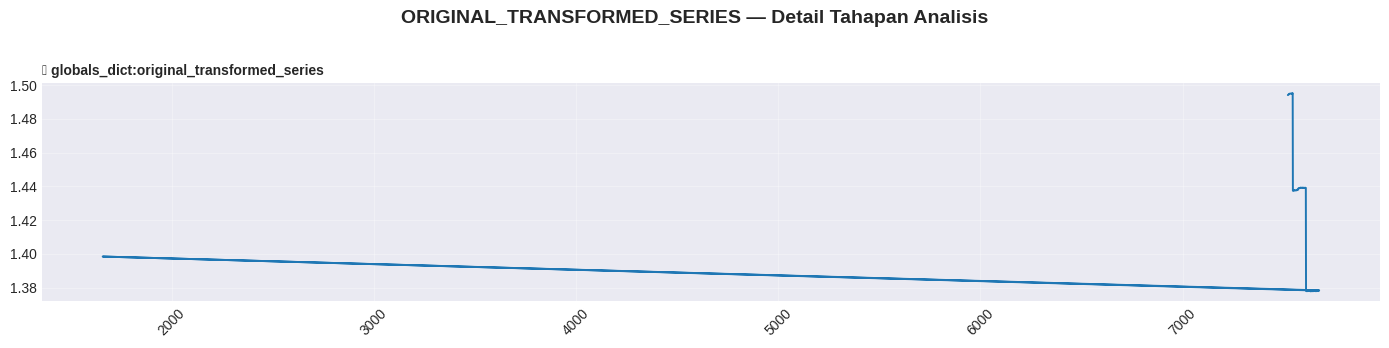


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: CURRENT_SERIES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


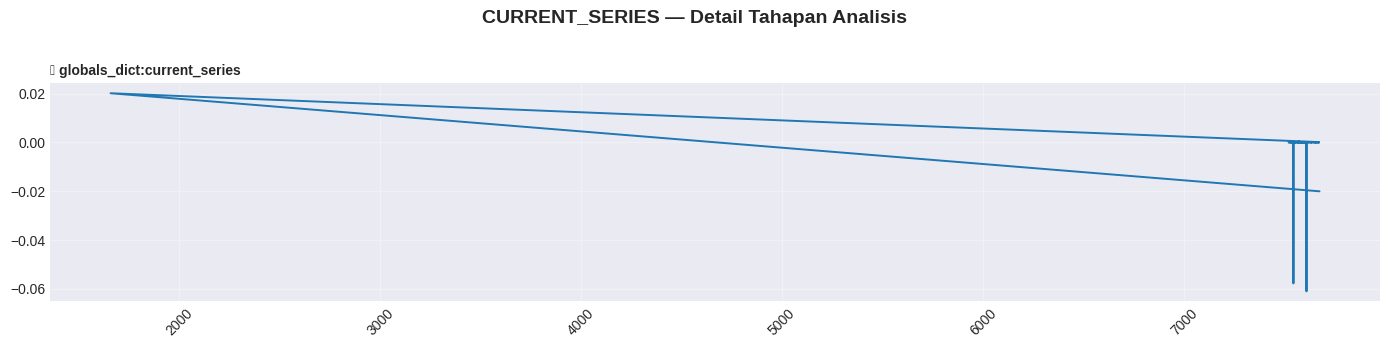


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: COMBINED_LOG_RETURNS_DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


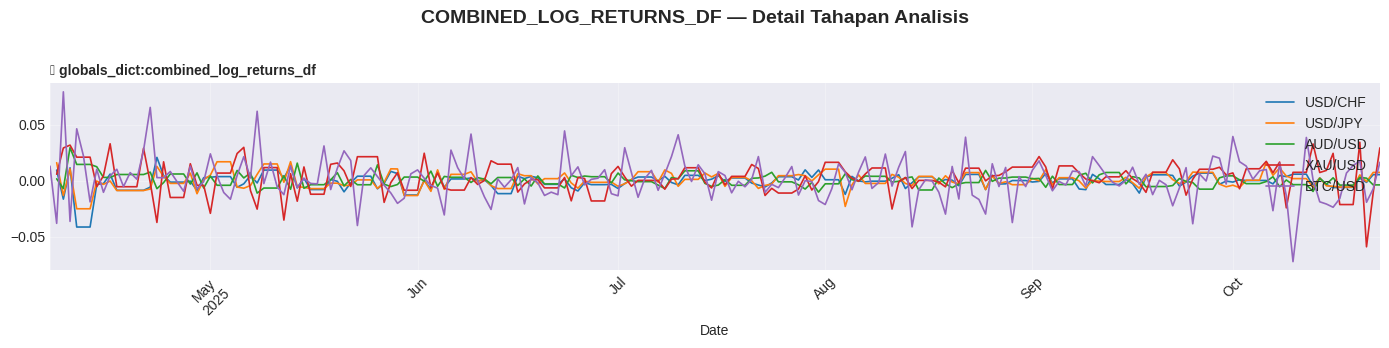


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_RENAMED — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


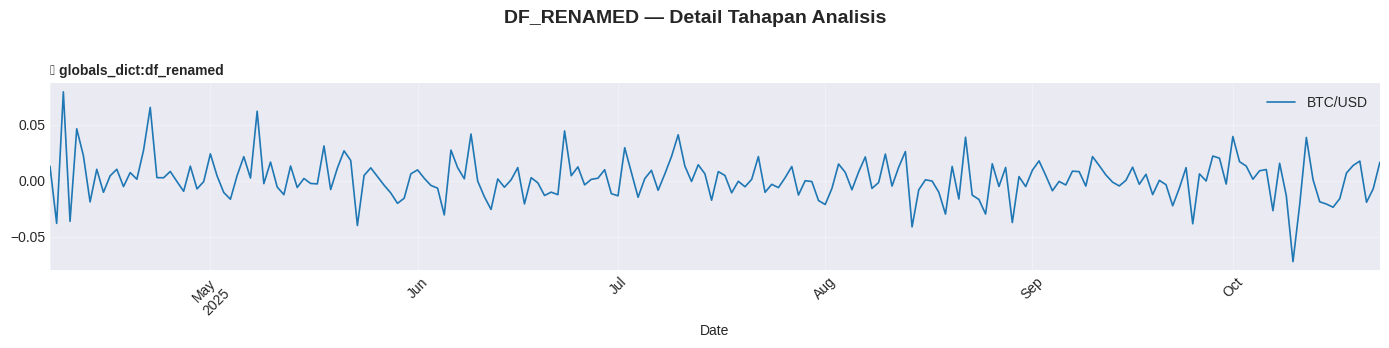


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: COMBINED_STATIONARIZED_FRED_DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


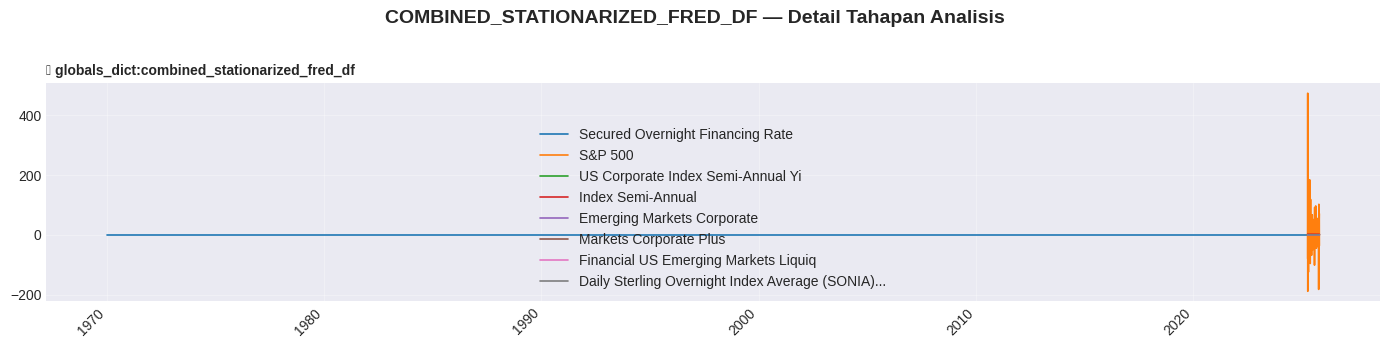


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: PAIR_DF_BASE — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


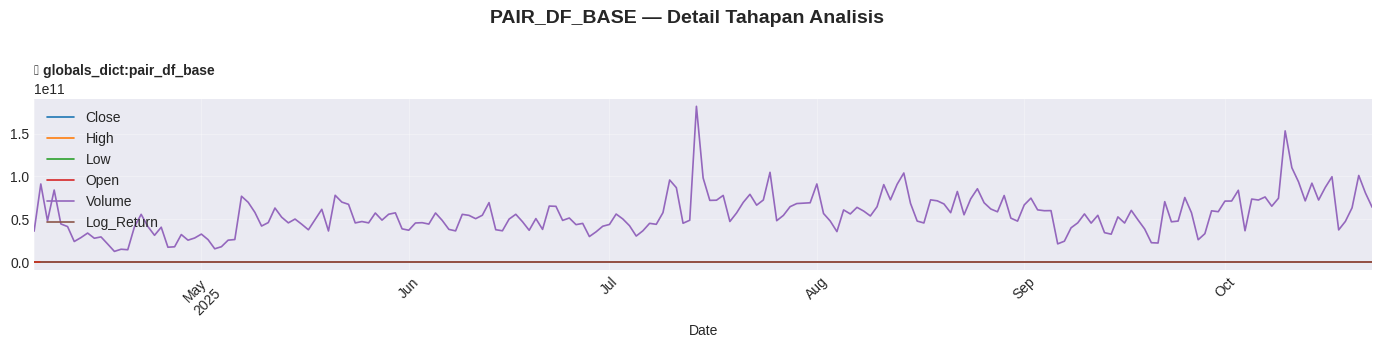


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SUB_FRED_VALUES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


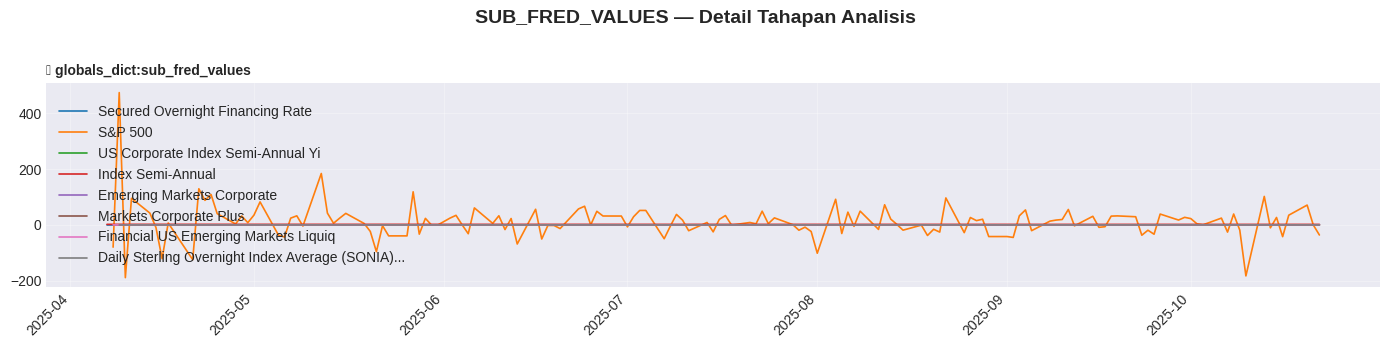


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: ALIGNED_FRED_VALUES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


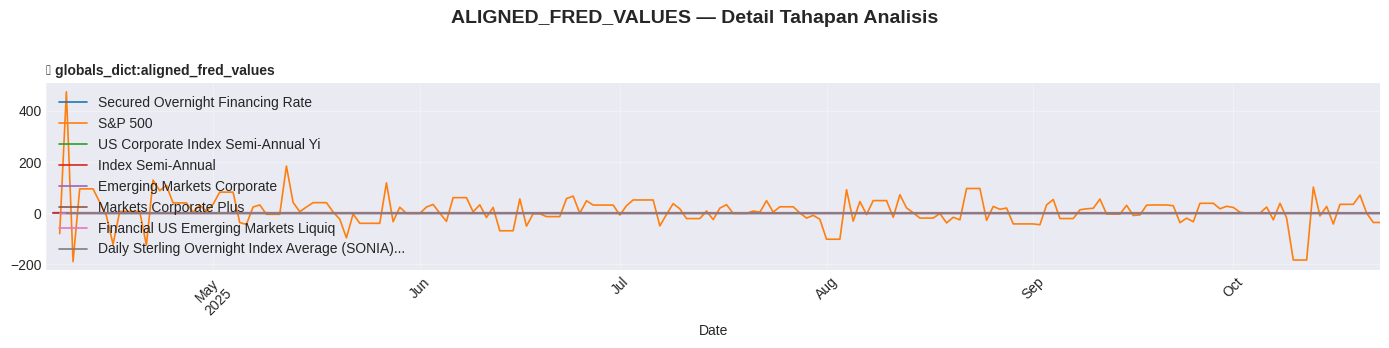


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_COMBINED_FOR_GRANGER — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


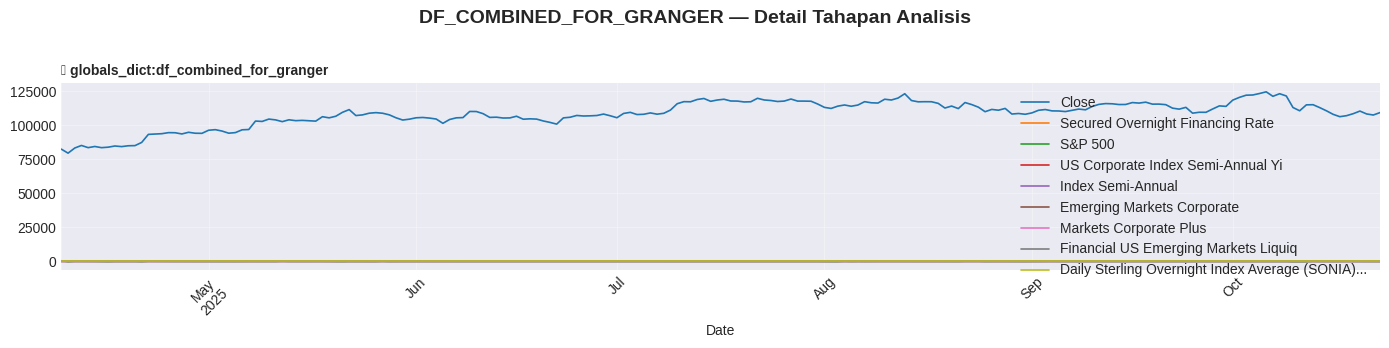


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SUB_DATA — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


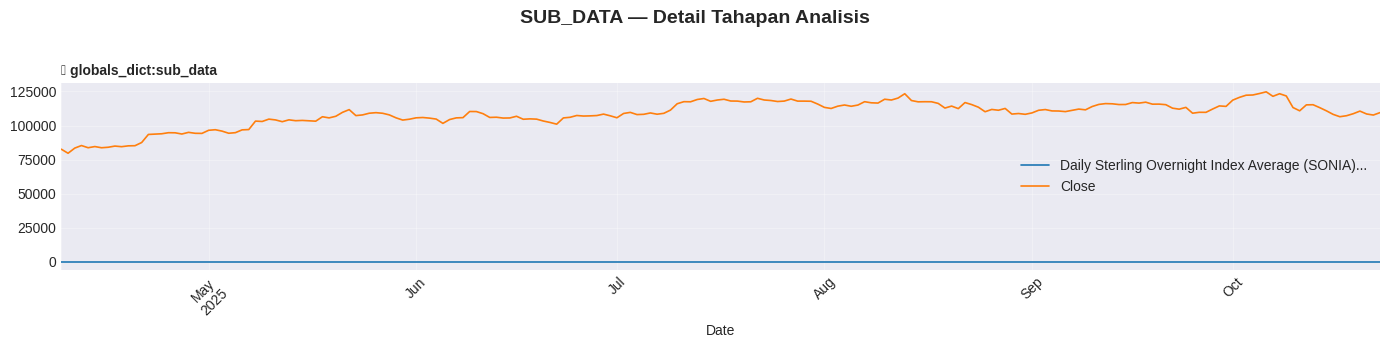


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: MACRO_GRANGER_DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


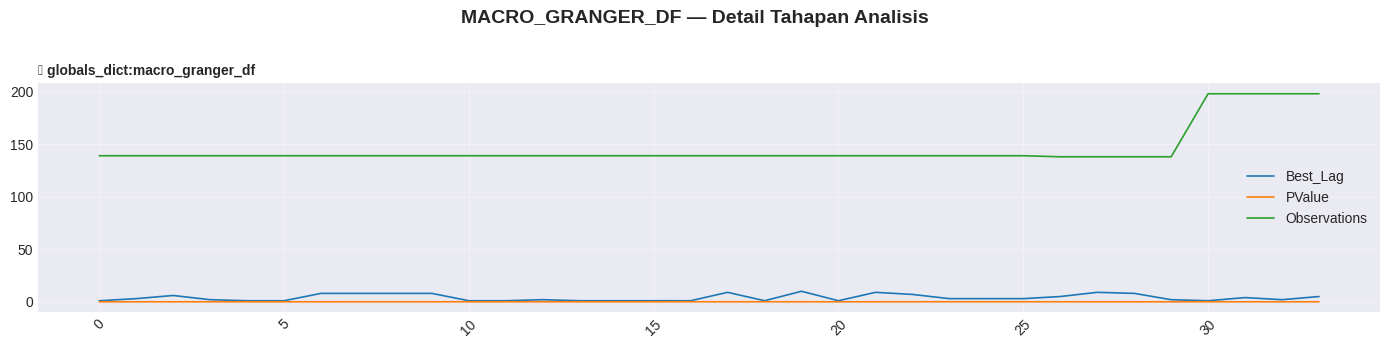


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_COMBINED_FOR_VARX — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


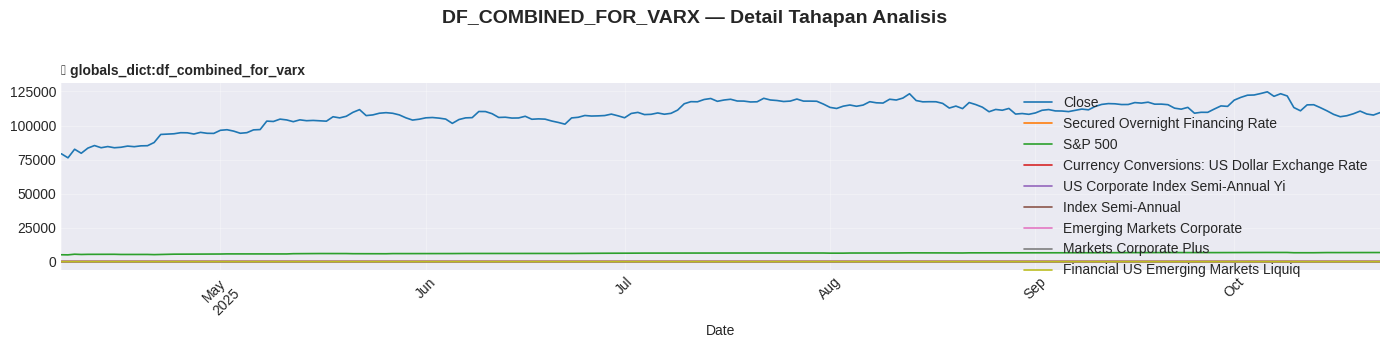


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: VARX_MACRO_DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


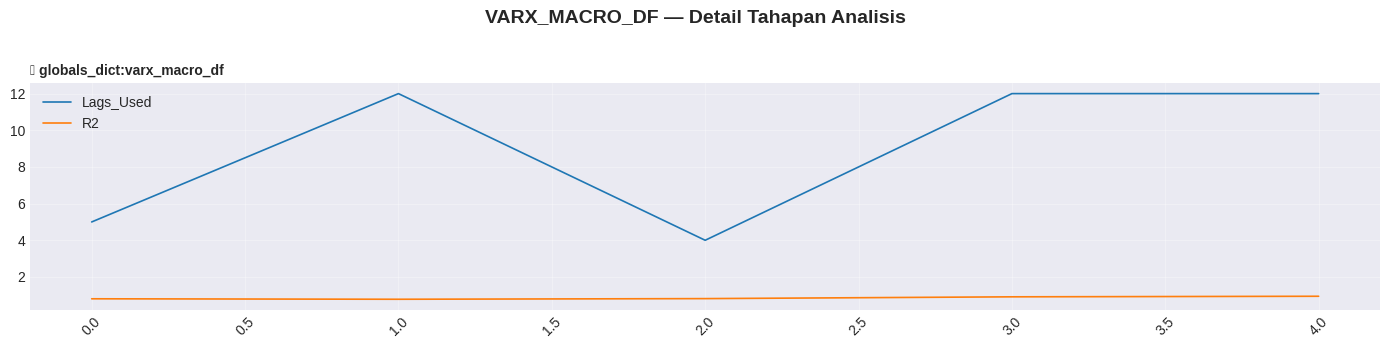


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: RESIDUALS — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


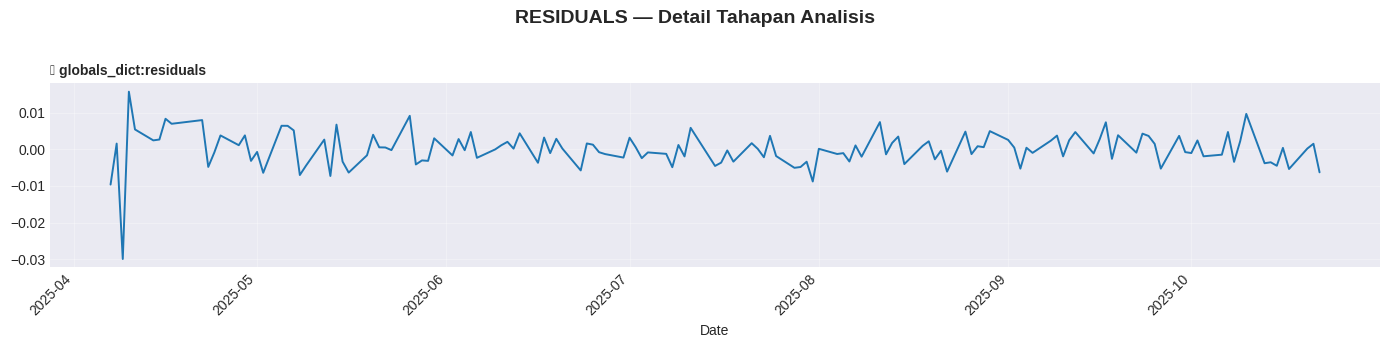


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: SIGNIFICANT_RESULTS — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


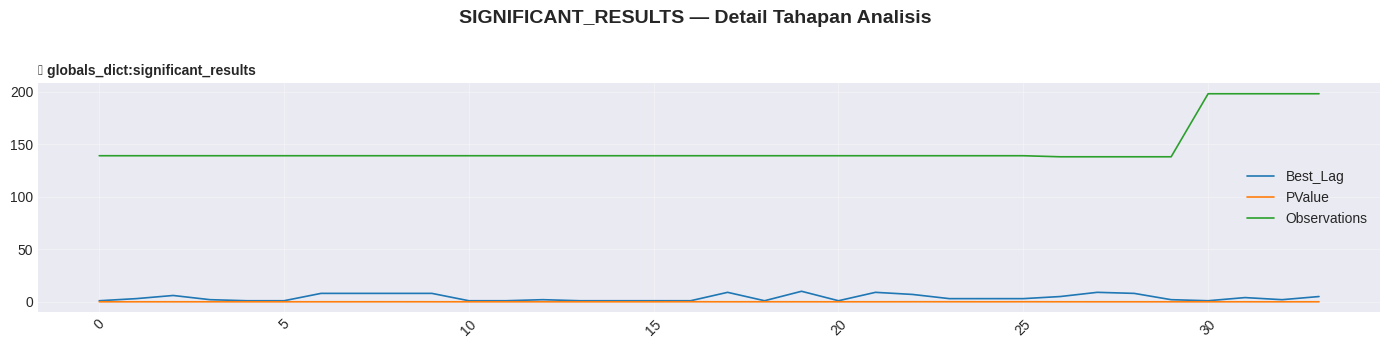


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: Y — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


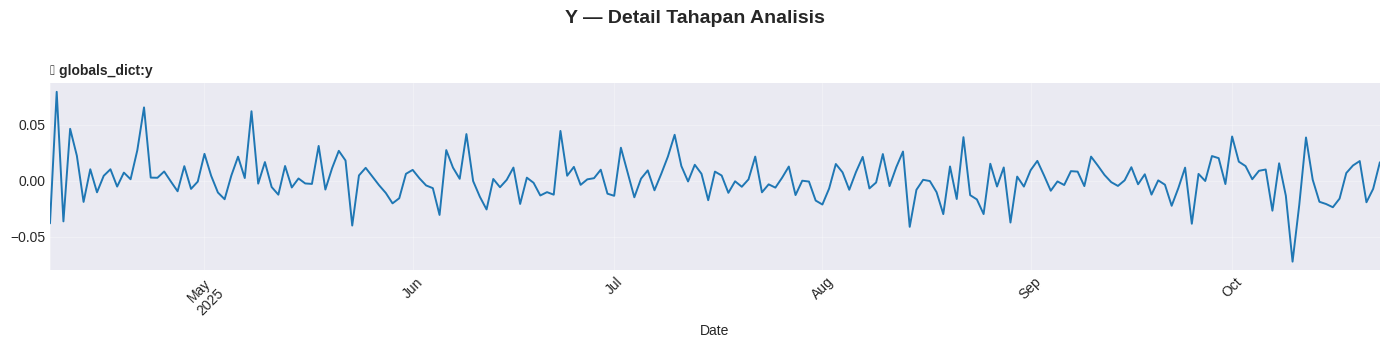


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: PREDS — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


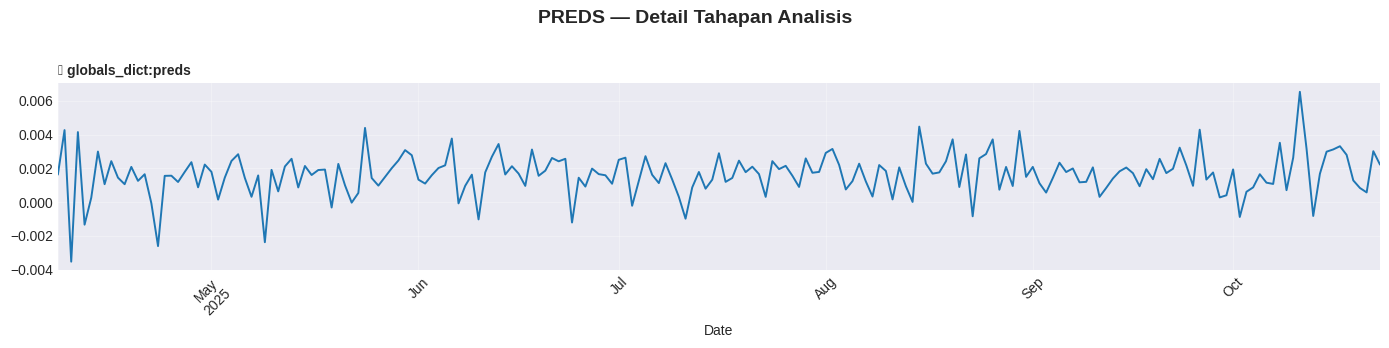


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: DF_VAR — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


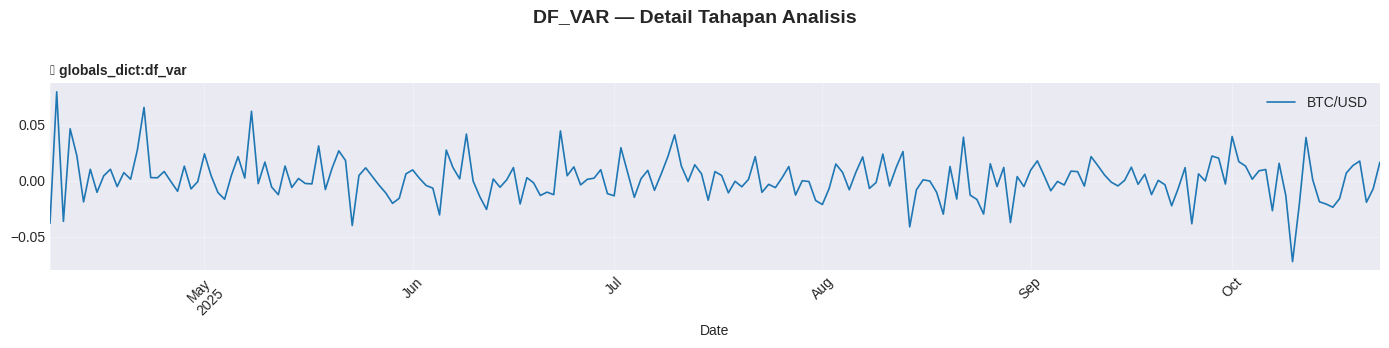


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: PM — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


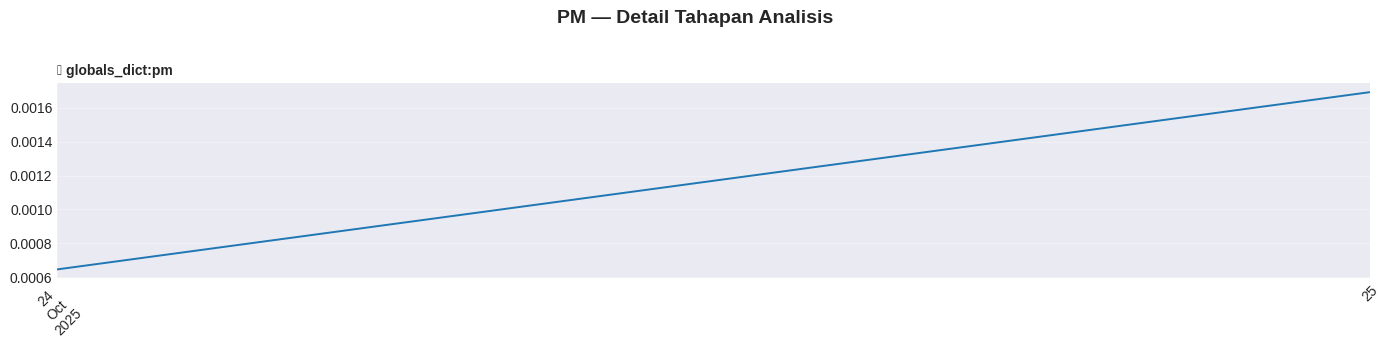


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: PRED_DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


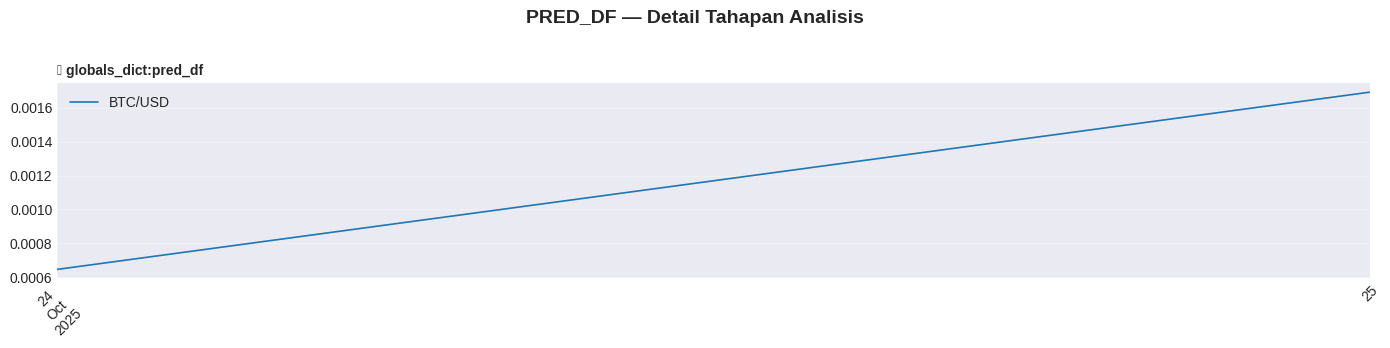


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: FORECAST_DF — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


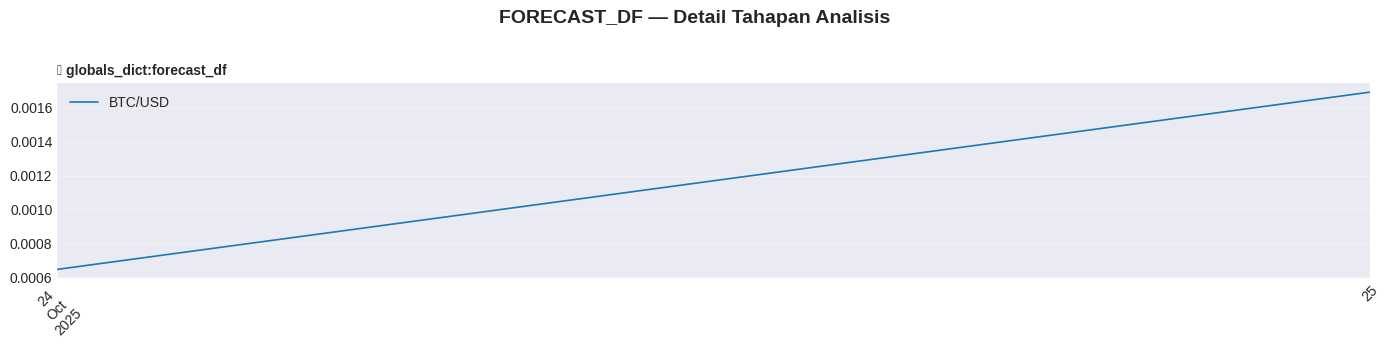


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: FORECAST_RETURNS — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


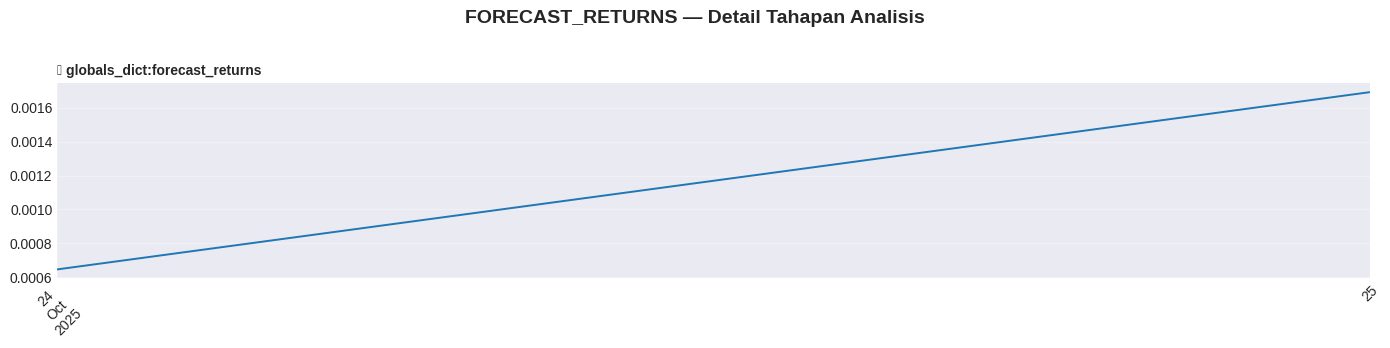


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: RESTORED_PRICES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


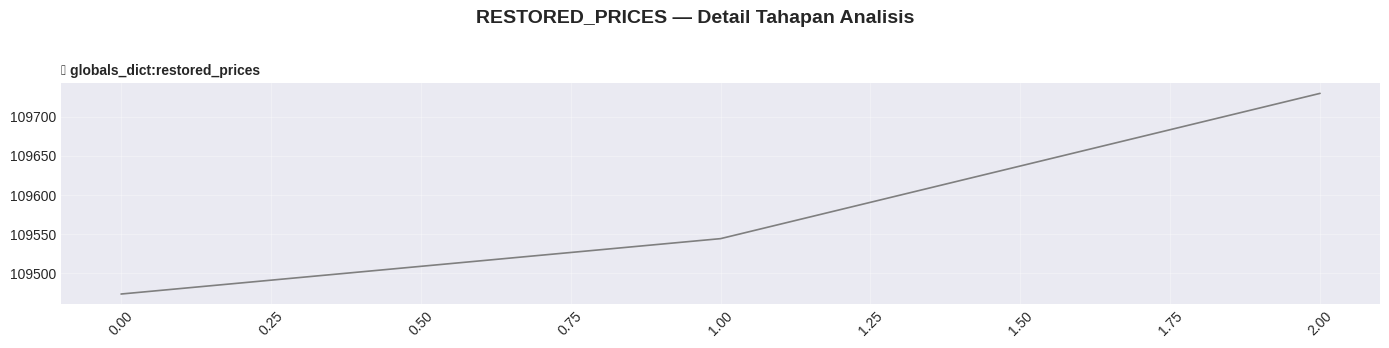


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 ENTITY: RESTORED_SERIES — total 1 proses analisis
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


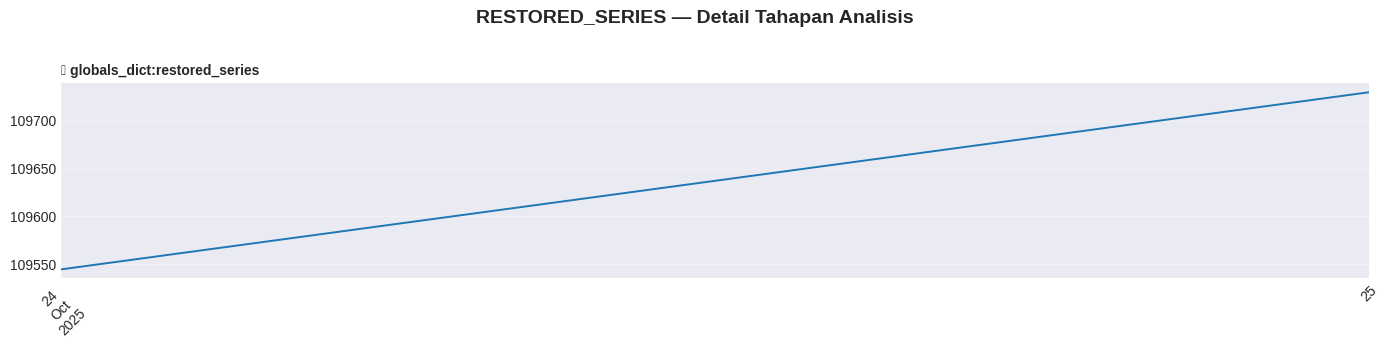

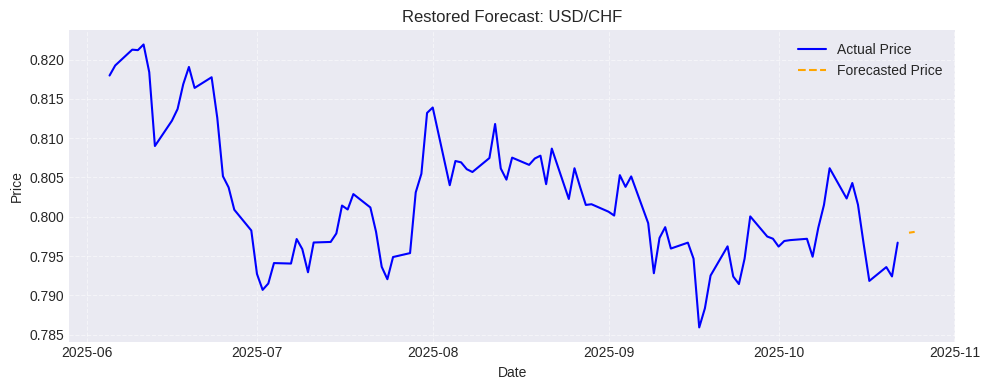

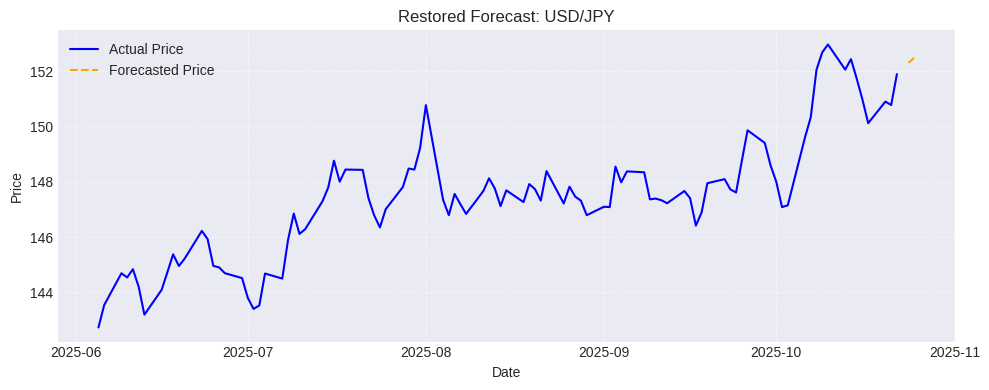

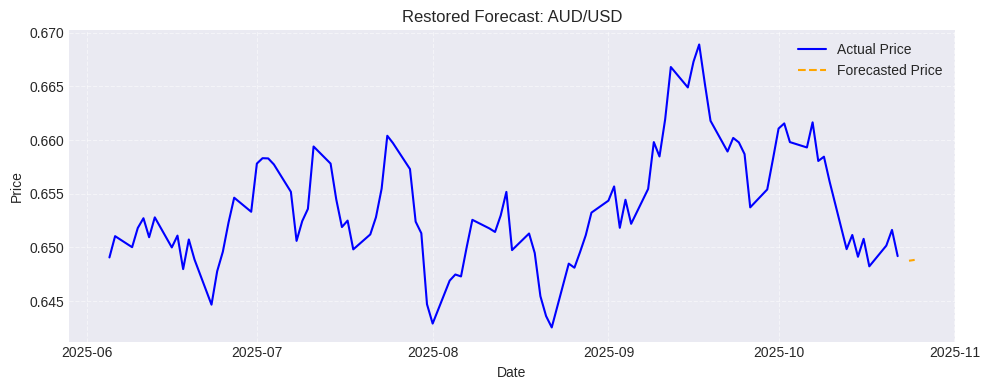

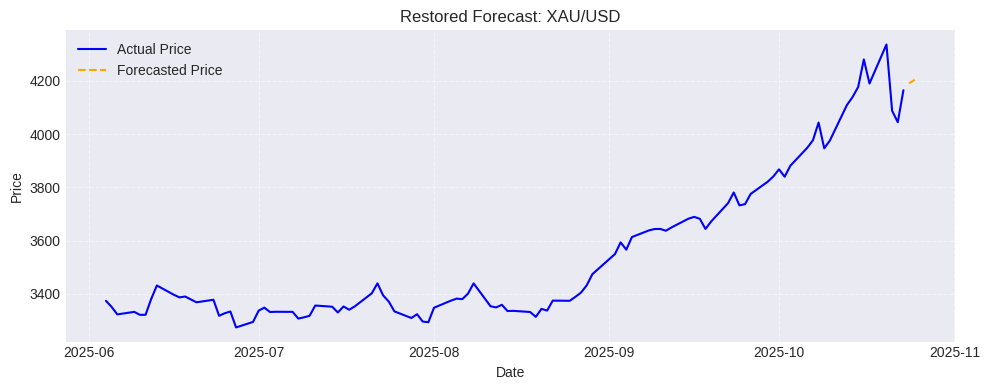

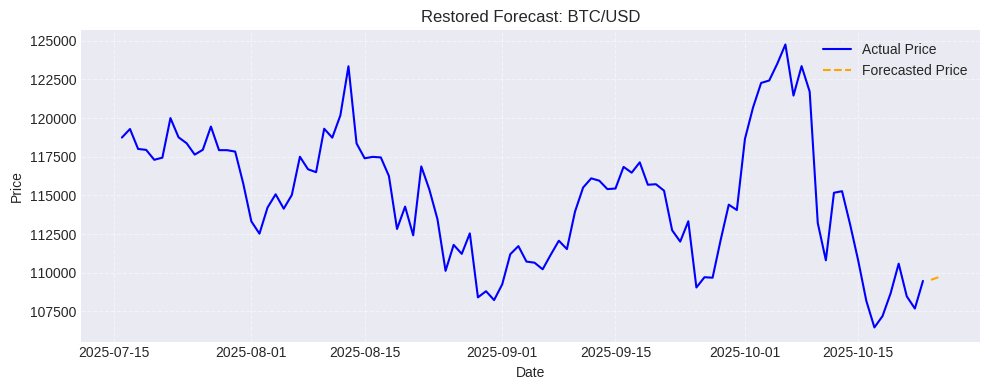

{'USD/CHF': {'forecast': 2025-10-24 00:00:00+00:00    0.797961
2025-10-25 00:00:00+00:00    0.798074
Freq: D, Name: forecast_price, dtype: float64, 'actual': Date
2025-04-07 00:00:00+00:00    0.85161
2025-04-08 00:00:00+00:00    0.85971
2025-04-09 00:00:00+00:00    0.84566
2025-04-10 00:00:00+00:00    0.85545
2025-04-11 00:00:00+00:00    0.82076
                              ...   
2025-10-16 00:00:00+00:00    0.79655
2025-10-17 00:00:00+00:00    0.79183
2025-10-20 00:00:00+00:00    0.79359
2025-10-21 00:00:00+00:00    0.79240
2025-10-22 00:00:00+00:00    0.79670
Name: Close, Length: 141, dtype: float64}, 'USD/JPY': {'forecast': 2025-10-24 00:00:00+00:00    152.302739
2025-10-25 00:00:00+00:00    152.479744
Freq: D, Name: forecast_price, dtype: float64, 'actual': Date
2025-04-07 00:00:00+00:00    145.432999
2025-04-08 00:00:00+00:00    147.789001
2025-04-09 00:00:00+00:00    145.845001
2025-04-10 00:00:00+00:00    147.399002
2025-04-11 00:00:00+00:00    143.746994
                     

In [44]:
# cell_id: collect_and_plot_entity_detailed_safe
# ============================================================
# 📊 VISUALISASI DETAIL PER ENTITY (PAIR / MAKRO) - VERSI STABIL
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# 1️⃣ Ambil semua dictionary dari memori global
globals_dict = globals()
candidate_dicts = {k: v for k, v in globals_dict.items() if isinstance(v, dict)}

# 2️⃣ Fungsi aman untuk cek apakah objek bisa diplot
def is_plotable(v):
    """Periksa apakah objek berisi data numerik yang bisa diplot"""
    try:
        if isinstance(v, pd.Series):
            return np.issubdtype(v.dropna().dtype, np.number)
        elif isinstance(v, pd.DataFrame):
            numeric_cols = v.select_dtypes(include=[np.number])
            return numeric_cols.shape[1] > 0
        elif isinstance(v, (list, np.ndarray)):
            return all(isinstance(x, (int, float, np.number)) for x in v if x is not None)
        else:
            return False
    except Exception:
        return False

# 3️⃣ Kumpulkan hanya hasil numerik yang valid
all_results_plot = {}
for dict_name, d in candidate_dicts.items():
    valid_items = {}
    for k, v in d.items():
        if is_plotable(v):
            valid_items[k] = v
    if valid_items:
        all_results_plot[dict_name] = valid_items

print(f"✅ {len(all_results_plot)} dictionary numerik berhasil dikumpulkan.\n")

# 4️⃣ Kelompokkan berdasarkan entity/pair
entity_results = {}
for dict_name, d in all_results_plot.items():
    for subkey, val in d.items():
        entity = subkey.upper()
        entity = re.sub(r'[^A-Z0-9/_-]', '', entity)
        if entity not in entity_results:
            entity_results[entity] = {}
        entity_results[entity][f"{dict_name}:{subkey}"] = val

print(f"📦 Total entity terdeteksi: {len(entity_results)}\n")

# 5️⃣ Tampilkan visualisasi per entity
for entity, dataset in entity_results.items():
    print(f"\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print(f"📈 ENTITY: {entity} — total {len(dataset)} proses analisis")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

    n = len(dataset)
    fig, axes = plt.subplots(n, 1, figsize=(14, 3.5 * n))
    if n == 1:
        axes = [axes]

    for i, (name, val) in enumerate(dataset.items()):
        ax = axes[i]
        try:
            if isinstance(val, pd.Series):
                val.plot(ax=ax, color='tab:blue', linewidth=1.4)
            elif isinstance(val, pd.DataFrame):
                val.select_dtypes(include=[np.number]).plot(ax=ax, linewidth=1.2)
            elif isinstance(val, (list, np.ndarray)):
                ax.plot(val, linewidth=1.2, color='tab:gray')

            ax.set_title(f"🔹 {name}", fontsize=10, fontweight='bold', loc='left')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', labelrotation=45)
        except Exception as e:
            ax.text(0.5, 0.5, f"Gagal plot\n{name}\n{e}",
                    ha='center', va='center', fontsize=8)
            ax.axis("off")

    plt.suptitle(f"{entity} — Detail Tahapan Analisis", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

for pair_name in restored_forecasts.keys():
    if pair_name not in base_dfs or base_dfs[pair_name].empty:
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(base_dfs[pair_name].iloc[-100:, 0], label="Actual Price", color="blue")
    plt.plot(restored_forecasts[pair_name], label="Forecasted Price", color="orange", linestyle="--")
    plt.title(f"Restored Forecast: {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
print(macro_varx_predictions)